# Credits

Updated to detectwaste by:
* Sylwia Majchrowska

In [1]:
%matplotlib inline
import sys
from pycocotools.coco import COCO
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
import skimage
import skimage.io as io
import copy

from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

from collections import Counter

In [2]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [3]:
colors_recykling = {'metals_and_plastics':'yellow',
                    'non-recyclable': 'gray',
                    'unknown':'gray',
                    'glass': 'green',
                    'paper': 'blue',
                    'bio': 'brown',
                    'other': 'pink'}

## TrashCan 1.0
- background: under watter
- classes: 8
- comment: captured frames of 3 videos (very similiar photos of the same objects)
- annotation: inastance masks

In [4]:
dataDir='/dih4/dih4_2/wimlds/data/TrashCan_v1/material_version'
dataType='all'
annFile='{}/instances_{}_trashcan.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [5]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(', '.join(nms)))

COCO categories: 
trash_etc, trash_fabric, trash_fishing_gear, trash_metal, trash_paper, trash_plastic, trash_rubber, trash_wood

COCO supercategories: 
trash_fabric, trash_paper, trash_fishing_gear, trash_metal, trash_wood, trash_rubber, trash_etc, trash_plastic


Image n°1671
Image name: /dih4/dih4_2/wimlds/data/TrashCan_v1/material_version/all/vid_000264_frame0000074.jpg


(-0.5, 479.5, 359.5, -0.5)

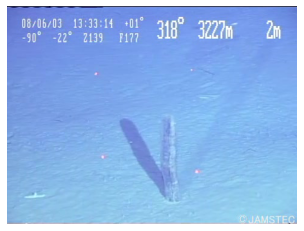

In [6]:
# load and display image
catIds = coco.getCatIds(catNms=['trash_wood']);
imgIds = coco.getImgIds(catIds=catIds);
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
#img_name = '%s/%s'%(dataDir, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)
plt.axis('off')

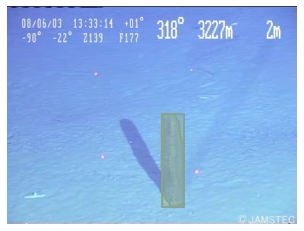

In [7]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

In [8]:
with open(annFile, 'r') as f:
    dataset = json.loads(f.read())

# select only trash
#trash_categories = [item for item in dataset['categories'] if item['name'].startswith('trash')]
cat_names = [item['name'] for item in dataset['categories'] if item['name'].startswith('trash')]
#trash_categories

# define variables
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

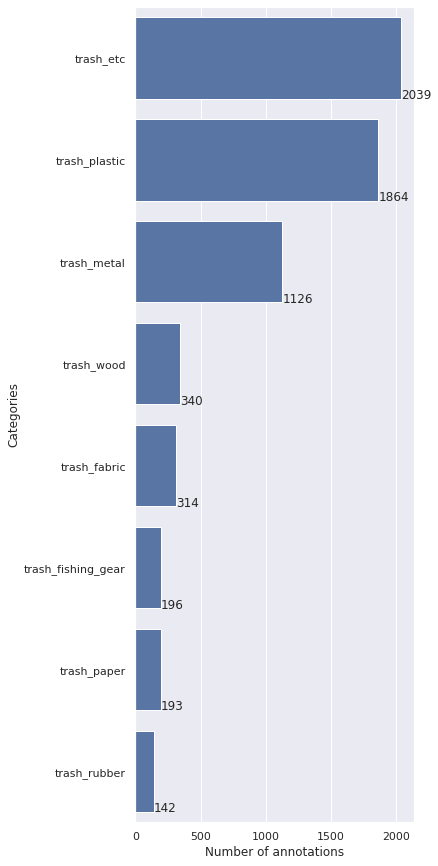

In [9]:
# Count annotations
cat_histogram = np.zeros(len(dataset['categories']),dtype=int)
for ann in dataset['annotations']:
    cat_histogram[ann['category_id'] - 1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,15))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
sns.set_color_codes("pastel")
sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")
show_values_on_bars(plot_1, "h", 0.3)

In [10]:
print(len(dataset['images']), len([ann for ann in dataset['annotations'] if ann['image_id'] in [i['id'] for i in dataset['images']]]))

7212 6214


In [11]:
def trashcan_to_detectwaste(label):
    metals_and_plastics = ['trash_plastic', 'trash_metal']
    
    non_recyclable = ['trash_fabric', 'trash_rubber', 'trash_paper']
    
    other = ['trash_fishing_gear']
    bio = ['trash_wood']
    unknown = ['trash_etc']

    if (label in metals_and_plastics):
        label="metals_and_plastics"
    elif(label in non_recyclable):
        label="non-recyclable"
    elif(label in other):
        label="other"
    elif(label in bio):
        label="bio"
    elif(label in unknown):
        label="unknown"
    else:
        print(label, "is non-trashcan label")
        label = "unknown"
    return label

In [12]:
# convert all taco anns to detect-waste anns
# let's change supercategory to detectwaste
detectwaste_categories = dataset['categories']
for ann in anns:    
    cat_id = ann['category_id']
    cat_trashcan = categories[cat_id-1]['name']
    detectwaste_categories[cat_id-1]['supercategory'] = trashcan_to_detectwaste(cat_trashcan)
# As there is no representation of "Plastified paper bag" in annotated data, change of this supercategory was done manually.
detectwaste_categories

[{'supercategory': 'unknown', 'id': 1, 'name': 'trash_etc'},
 {'supercategory': 'non-recyclable', 'id': 2, 'name': 'trash_fabric'},
 {'supercategory': 'other', 'id': 3, 'name': 'trash_fishing_gear'},
 {'supercategory': 'metals_and_plastics', 'id': 4, 'name': 'trash_metal'},
 {'supercategory': 'non-recyclable', 'id': 5, 'name': 'trash_paper'},
 {'supercategory': 'metals_and_plastics', 'id': 6, 'name': 'trash_plastic'},
 {'supercategory': 'non-recyclable', 'id': 7, 'name': 'trash_rubber'},
 {'supercategory': 'bio', 'id': 8, 'name': 'trash_wood'}]

In [13]:
detectwaste_ids = {}
detectwaste_cat_names = []
cat_id = 0
for cat in detectwaste_categories:
    if cat['supercategory'] not in detectwaste_ids:
        detectwaste_cat_names.append(cat['supercategory'])
        detectwaste_ids[cat['supercategory']] = cat_id
        cat_id += 1
        


trashcan_to_detectwaste_ids = {}
for i, cat in enumerate(detectwaste_categories):
    trashcan_to_detectwaste_ids[cat['id']] = detectwaste_ids[cat['supercategory']]
    
# print(taco_to_detectwaste_ids)



anns_detectwaste = anns.copy()
for i, ann in enumerate(anns):
    #print(ann['category_id'])
    anns_detectwaste[i]['category_id'] = trashcan_to_detectwaste_ids[ann['category_id']]
    anns_detectwaste[i].pop('segmentation', None)


Text(0.5, 1.0, 'Annotations per detectwaste category')

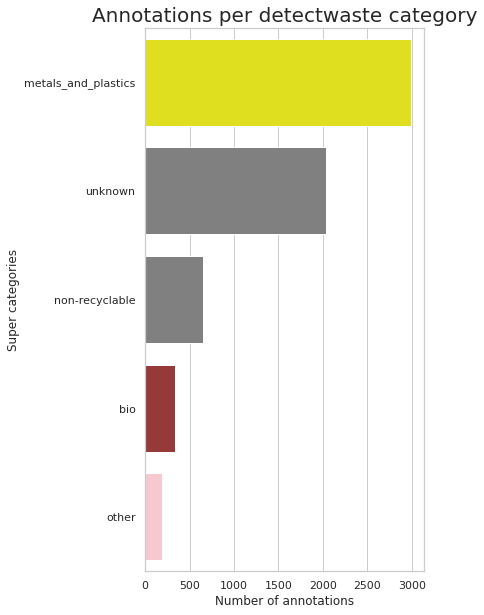

In [15]:
# Count annotations
detectwaste_cat_histogram = np.zeros(len(detectwaste_cat_names),dtype=int)

for ann in anns_detectwaste:
    cat_id = ann['category_id']
    detectwaste_cat_histogram[cat_id] +=1


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,10))

# Convert to DataFrame
d ={'Super categories': detectwaste_cat_names, 'Number of annotations': detectwaste_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)

sup_cat = df.loc[:,'Super categories'].tolist()
colors = [colors_recykling[cat] for cat in sup_cat]

sns.set_palette(sns.color_palette(colors))
plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
            label="Total")
plot_1.set_title('Annotations per detectwaste category',fontsize=20)

### bbox statistics

In [16]:
def bbox_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['bbox'][2] for pic in anns]
    picsh = [pic['bbox'][3] for pic in anns]
    bbox_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(bbox_size)
    if calc == 'median':
        return np.median(bbox_size)

def area_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['area'] for pic in anns]
    picsh = [pic['area'] for pic in anns]
    area_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(area_size)
    if calc == 'median':
        return np.median(area_size)

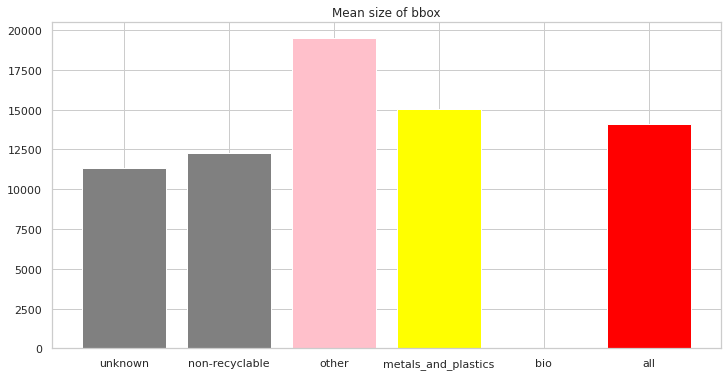

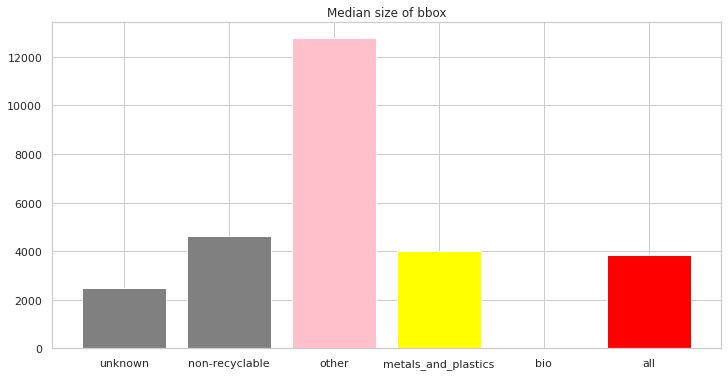

In [17]:
pylab.rcParams['figure.figsize'] = (12,6)

mean_bbox = []
median_bbox = []
for cat_nr, cat in enumerate(detectwaste_cat_names):
    
    temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
    mean_bbox.append(bbox_stats(temp_anns,)) 
    median_bbox.append(bbox_stats(temp_anns,'median'))
mean_bbox[-1] =0
median_bbox[-1] =0


# append stats for all for comparison
temp_detectwaste_cat_names = detectwaste_cat_names.copy()
temp_detectwaste_cat_names.append('all')
mean_bbox.append(bbox_stats(anns_detectwaste)) 
median_bbox.append(bbox_stats(anns_detectwaste,'median'))

colors = [colors_recykling[name] for name in detectwaste_cat_names]
colors.append('red')


plt.bar(temp_detectwaste_cat_names,mean_bbox, color=colors)
plt.title('Mean size of bbox')
plt.show()

plt.bar(temp_detectwaste_cat_names,median_bbox, color=colors)
plt.title('Median size of bbox')
plt.show()

['unknown', 'non-recyclable', 'other', 'metals_and_plastics', 'bio', 'all']


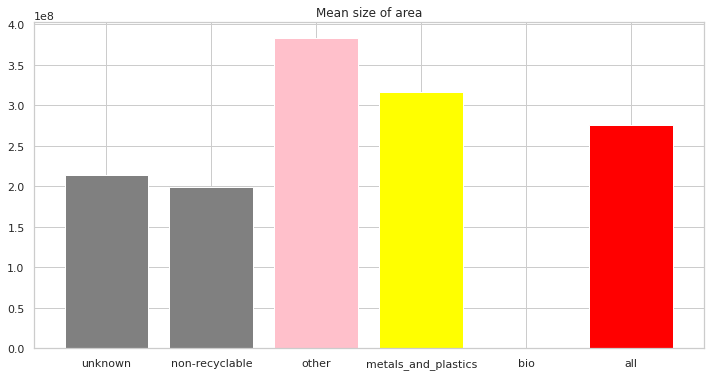

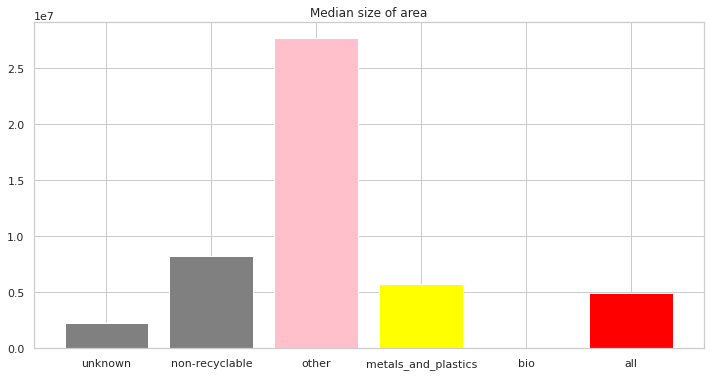

In [18]:
mean_area = []
median_area = []
for cat_nr, cat in enumerate(detectwaste_cat_names):
    temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
    mean_area.append(area_stats(temp_anns,)) 
    median_area.append(area_stats(temp_anns,'median'))

mean_area[-1] = 0
median_area[-1] = 0
mean_area.append(area_stats(anns_detectwaste)) 
median_area.append(area_stats(anns_detectwaste,'median'))
print(temp_detectwaste_cat_names)

plt.bar(temp_detectwaste_cat_names,mean_area, color=colors)
plt.title('Mean size of area')
plt.show()

plt.bar(temp_detectwaste_cat_names,median_area, color=colors)
plt.title('Median size of area')
plt.show()

### Number of bboxes per image

In [19]:
def no_bbox_per_image(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    return np.mean(list_of_duplicates)
def no_bbox_summary(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    print('Maximum bboxes: ',np.max(list_of_duplicates))
    print('Mean number of bboxes: ',np.mean(list_of_duplicates))
    print('Median number of bboxes: ',np.median(list_of_duplicates))


print('all:',no_bbox_per_image(anns_detectwaste))
for cat_nr, cat in enumerate(detectwaste_cat_names):
    try:
        temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
        print('\n', cat)
        no_bbox_summary(temp_anns)
    except:
        continue
    

all: 1.165313852813853

 unknown
Maximum bboxes:  6
Mean number of bboxes:  1.1202046035805626
Median number of bboxes:  1.0

 non-recyclable
Maximum bboxes:  3
Mean number of bboxes:  1.15
Median number of bboxes:  1.0

 other
Maximum bboxes:  1
Mean number of bboxes:  1.0
Median number of bboxes:  1.0

 metals_and_plastics
Maximum bboxes:  5
Mean number of bboxes:  1.0926829268292684
Median number of bboxes:  1.0

 bio
Maximum bboxes:  1
Mean number of bboxes:  1.0
Median number of bboxes:  1.0


### Number of images per image shape

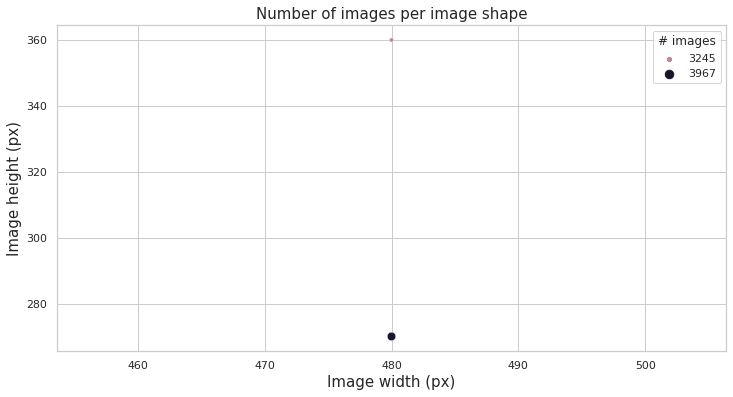

In [20]:
# Parsing image shapes (resolutions)
widths = []
heights = []
shape_freqs = []
img_shapes_keys = {}
for img in dataset['images']:
    key = str(img['width'])+'-'+str(img['height'])
    if key in img_shapes_keys:
        shape_id = img_shapes_keys[key]
        shape_freqs[shape_id] += 1
    else:
        img_shapes_keys[key] = len(widths)
        widths.append(img['width'])
        heights.append(img['height'])
        shape_freqs.append(1)


d ={'Image width (px)': widths, 'Image height (px)': heights, '# images': shape_freqs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
plot = sns.scatterplot(x="Image width (px)", y="Image height (px)", size='# images', hue="# images", palette = cmap,data=df)
plt.xlabel('Image width (px)', fontsize=15)
plt.ylabel('Image height (px)', fontsize=15)
plot = plot.set_title('Number of images per image shape',fontsize=15)

### Placement of central point of the bbox in the image

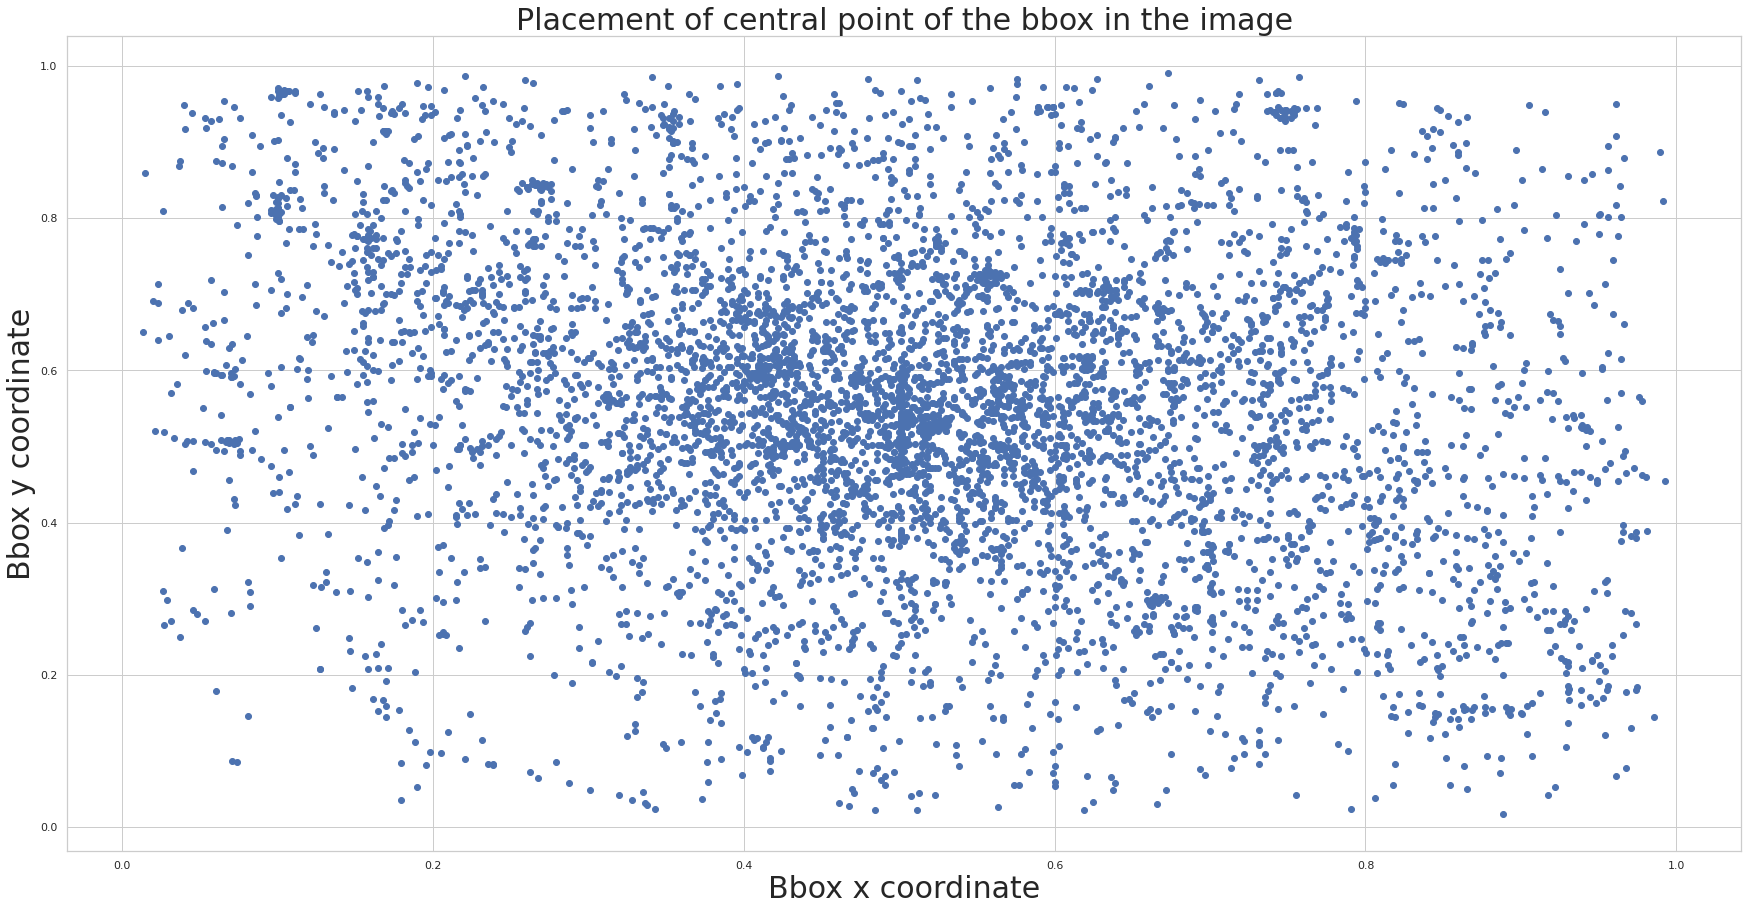

In [21]:
center_x = []
center_y = []
for i in range(0, len(anns_detectwaste)):
    for j in range (0, len(dataset['images'])):
        if dataset['images'][j]['id'] == anns_detectwaste[i]['image_id']:
            
            center_x.append((anns_detectwaste[i]['bbox'][0]+anns_detectwaste[i]['bbox'][2]/2)/dataset['images'][j]['width'])
            center_y.append((anns_detectwaste[i]['bbox'][1]+anns_detectwaste[i]['bbox'][3]/2)/dataset['images'][j]['height'])
plt.figure(figsize=(30,15))
plt.plot(center_x, center_y, 'bo')
plt.title('Placement of central point of the bbox in the image', fontsize=30)
plt.xlabel('Bbox x coordinate', fontsize=30)
plt.ylabel('Bbox y coordinate', fontsize=30)
plt.show()

### Number of annotations per image

/home/zklawikowska/project/env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean number of annotations per image: 0.8616195230171936


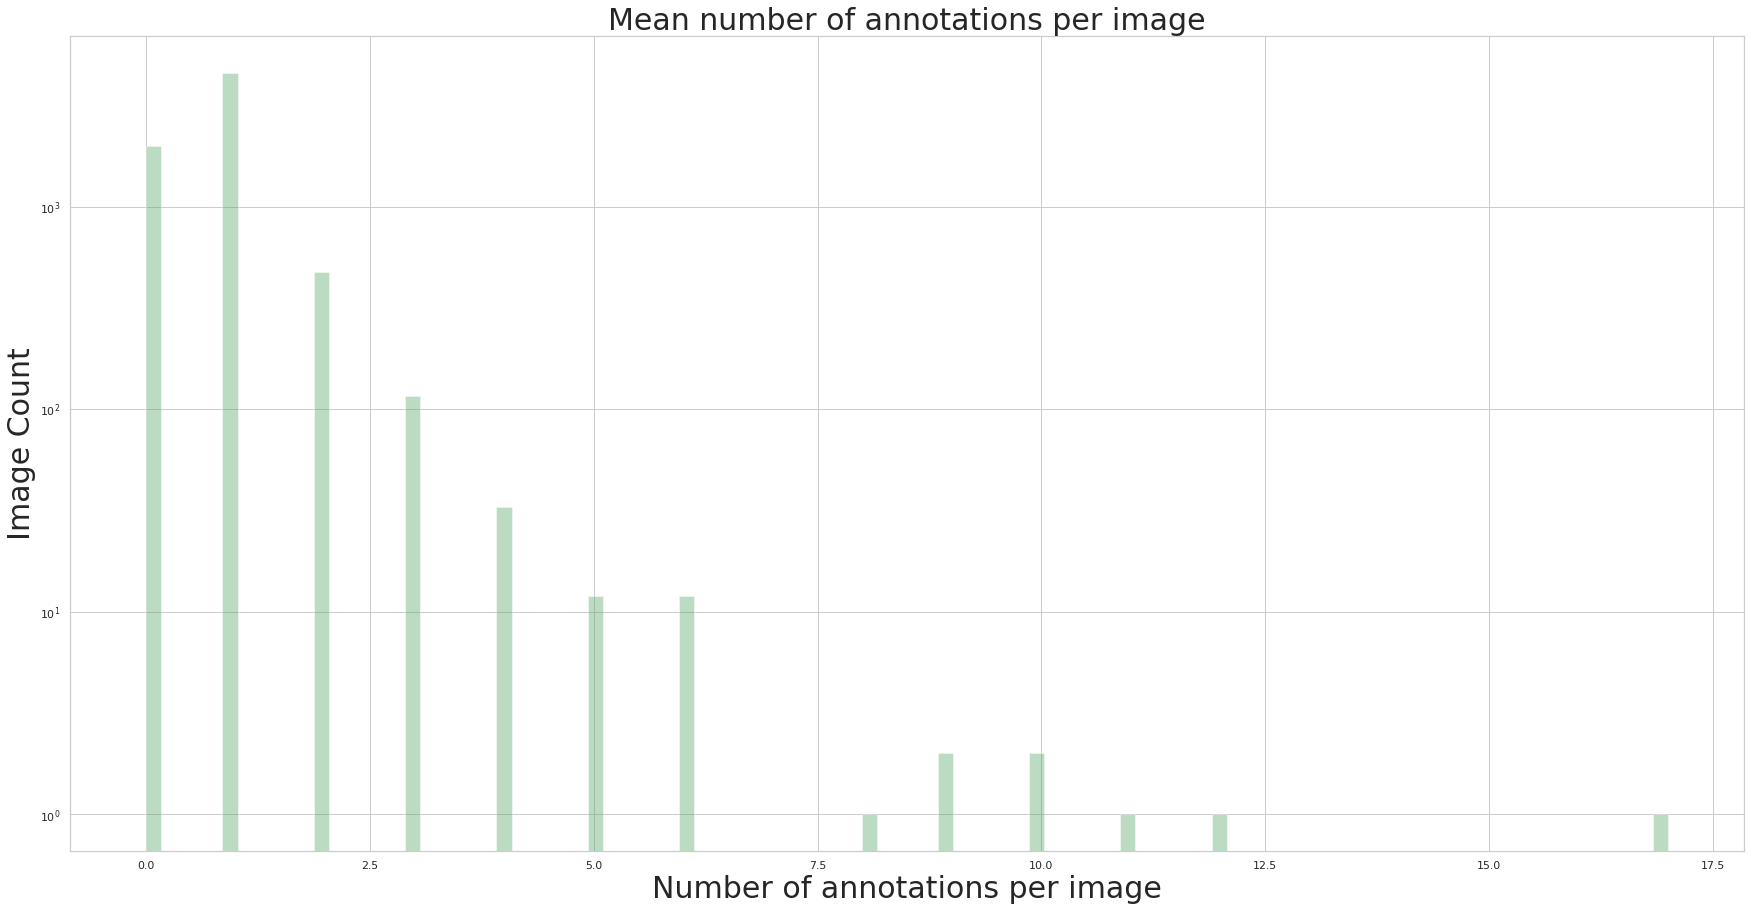

In [22]:
nr_annotation_per_image = []
annotations_per_image = []
for img in dataset['images']:
    annotations_per_image = []
    for i in range(0, len(anns_detectwaste)):
        if img['id'] == anns_detectwaste[i]['image_id']:
            annotations_per_image.append(anns_detectwaste[i]['id'])
    nr_annotation_per_image.append(len(annotations_per_image))

plt.figure(figsize=(30,15))
ax = sns.distplot(nr_annotation_per_image,kde=False,bins=100, color='g')
ax.set_yscale('log')
plt.title('Mean number of annotations per image', fontsize=30)
plt.xlabel('Number of annotations per image', fontsize=30)
plt.ylabel('Image Count', fontsize=30)

print('Mean number of annotations per image:',np.mean(nr_annotation_per_image))

### Bbox size - absolute and relative

According to MS COCO Evaluation. This dataset has:
89 small objects (area<32*32 px)
966 medium objects (area<96*96 px)
2077 large objects (area>96*96 px)
Number of bboxes smaller than 1024: 6150
Number of bboxes larger than 1024: 64
Number of missing annotations 235


Text(0.5, 1.0, 'Bounding-boxes size')

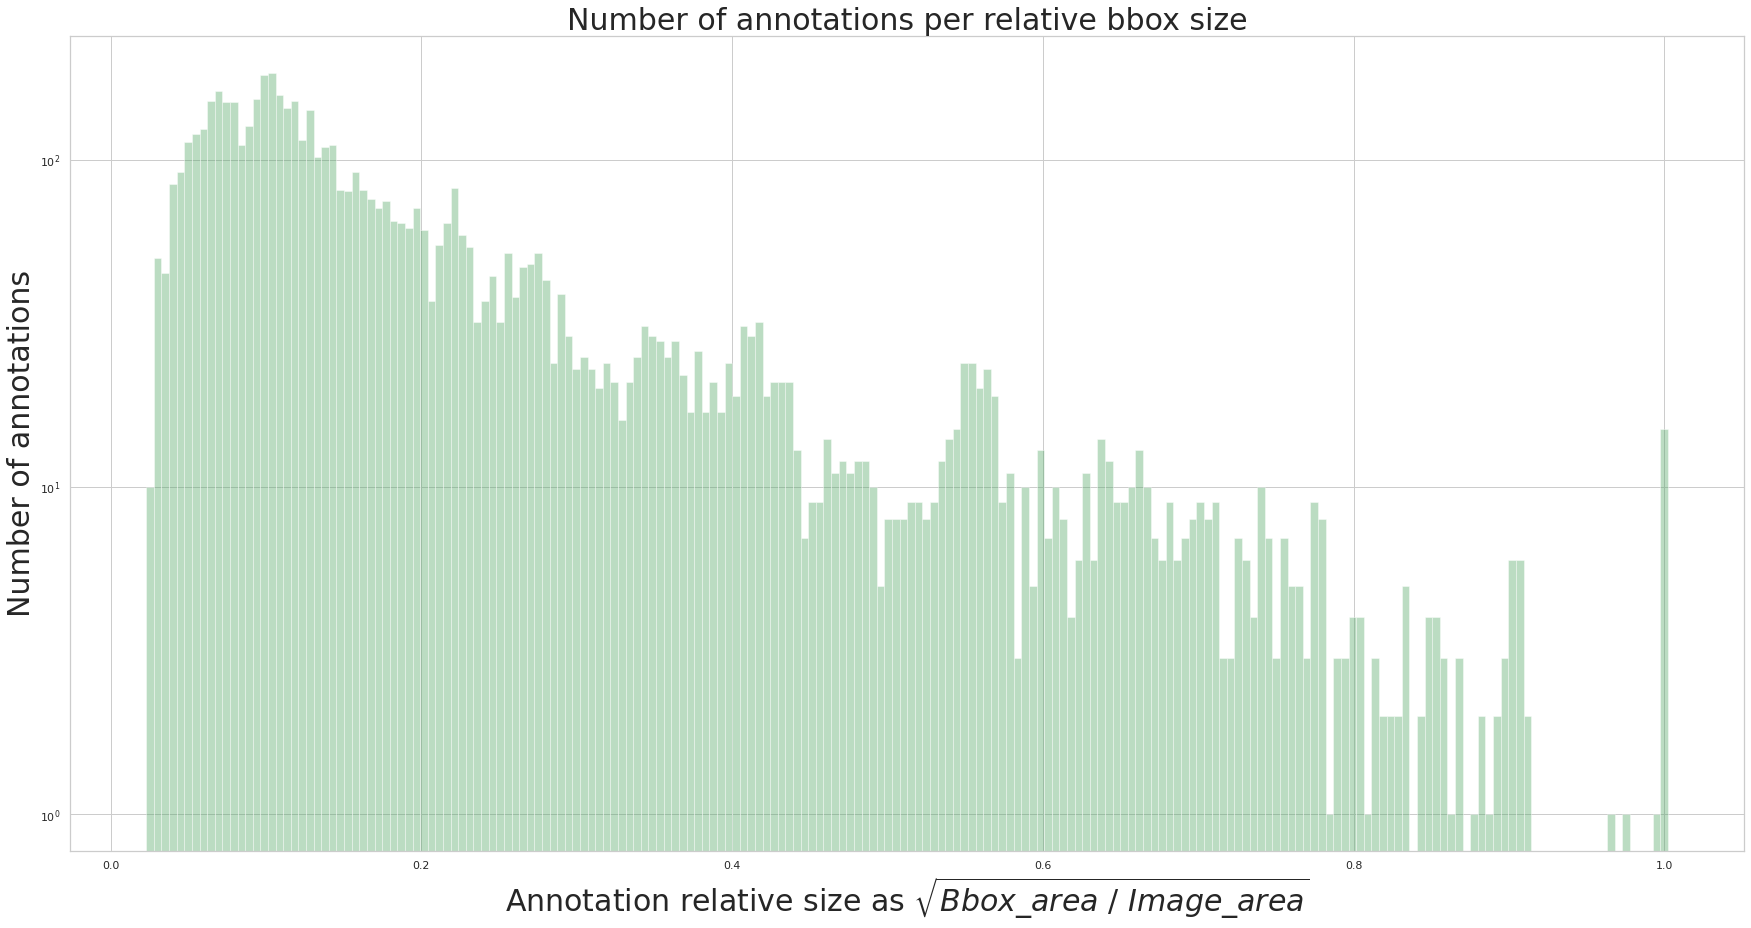

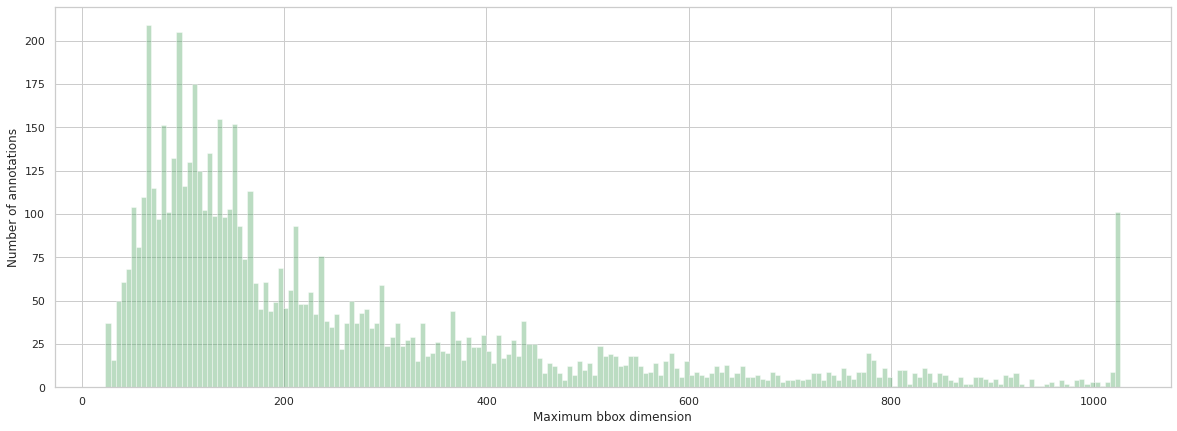

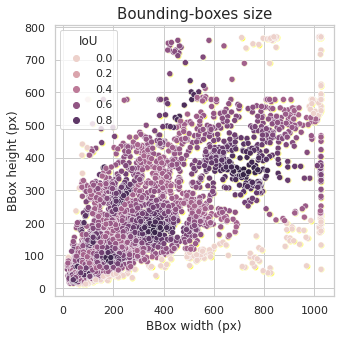

In [23]:
bbox_widths = []
bbox_heights = []
obj_areas_sqrt = []
obj_areas_sqrt_fraction = []
bbox_aspect_ratio = []
max_image_dim = 1024

for ann in anns_detectwaste:
    
    imgs = dataset['images']
    
    resize_scale = max_image_dim/max(imgs[0]['width'], imgs[0]['height'])
    # Uncomment this to work on original image size
#     resize_scale = 1
    
    bbox_widths.append(ann['bbox'][2]*resize_scale)
    bbox_heights.append(ann['bbox'][3]*resize_scale)
    obj_area = ann['bbox'][2]*ann['bbox'][3]*resize_scale**2 # ann['area']
    obj_areas_sqrt.append(np.sqrt(obj_area))
        
    img_area = imgs[0]['width']*imgs[0]['height']*resize_scale**2
    obj_areas_sqrt_fraction.append(np.sqrt(obj_area/img_area))
    

print('According to MS COCO Evaluation. This dataset has:')
print(np.sum(np.array(obj_areas_sqrt)<32), 'small objects (area<32*32 px)')
print(np.sum(np.array(obj_areas_sqrt)<64), 'medium objects (area<96*96 px)')
print(np.sum(np.array(obj_areas_sqrt)<96), 'large objects (area>96*96 px)')
    
# d ={'Bbox width (px)': bbox_widths, 'Bbox height (px)': bbox_heights, 'area': seg_areas}
# df = pd.DataFrame(d)

plt.figure(figsize=(30,15))
ax = sns.distplot(obj_areas_sqrt_fraction,kde=False, bins=200, color='g')
ax.set_yscale('log')
plt.title('Number of annotations per relative bbox size', fontsize=30)
plt.xlabel(r'Annotation relative size as $\sqrt{ Bbox\_area \ /  \ Image\_area}$', fontsize=30)
plt.ylabel('Number of annotations', fontsize=30)

plt.figure(figsize=(20,7))
ax = sns.distplot(np.maximum(np.array(bbox_widths),np.array(bbox_heights)),kde=False, bins=200, color='g')
ax = ax.set(xlabel='Maximum bbox dimension', ylabel='Number of annotations')

import colorsys
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", palette = cmap,data=df)

print('Number of bboxes smaller than 1024:',np.sum(np.array(bbox_widths)<1024))
print('Number of bboxes larger than 1024:',np.sum(np.array(bbox_widths)>1024))

# anchors = [(32,32),(64,64),(128,128),(256,256),(512,512)]
scales, ratios = np.meshgrid(np.array([16,32,64,128,256,512]), np.array([0.5,1,2]))
scales = scales.flatten()
ratios = ratios.flatten()
# Enumerate heights and widths from scales and ratios
anchor_heights = scales / np.sqrt(ratios)
anchor_widths = scales * np.sqrt(ratios)

IoUs = []
for i in range(len(bbox_widths)):
    bbox_area = bbox_widths[i]*bbox_heights[i]
    IoU_max = 0.0
    for j in range(len(anchor_heights)):
        anchor_area = anchor_heights[j]*anchor_widths[j]
        intersection_area = min(anchor_widths[j],bbox_widths[i])*min(anchor_heights[j], bbox_heights[i])
        IoU = intersection_area / (bbox_area + anchor_area - intersection_area)
        if IoU>0.5:
            IoU_max = IoU
    IoUs.append(IoU_max)
    
print('Number of missing annotations', np.sum(np.array(IoUs)==0.0))
  
# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights, 'IoU': IoUs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", hue = 'IoU',data=df)
plt.title('Bounding-boxes size', fontsize=15)

## Trash-ICRA19
- background: under watter
- classes: 7
- comment: captured frames of 3 videos (very similiar photos of the same objects)
- annotation: bboxes

In [24]:
dataDir='/dih4/dih4_2/wimlds/data/trash_icra19/'
dataType='all'
annFile='{}/{}_icra_coco.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


In [25]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(', '.join(nms)))

COCO categories: 
plastic, paper, unknown, cloth, rubber, metal, wood

COCO supercategories: 
none


Image n°7133
Image name: /dih4/dih4_2/wimlds/data/trash_icra19//all/obj0707_frame0000010.jpg


(-0.5, 479.5, 359.5, -0.5)

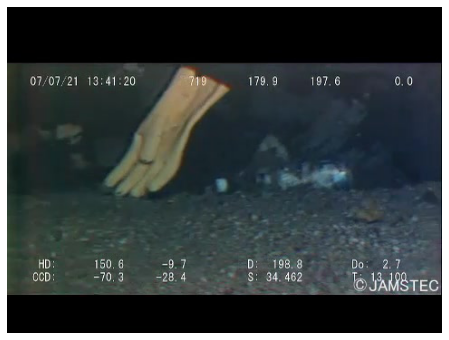

In [26]:
# load and display image
catIds = coco.getCatIds(catNms=['rubber']);
imgIds = coco.getImgIds(catIds=catIds);
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
#img_name = '%s/%s'%(dataDir, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)
plt.axis('off')

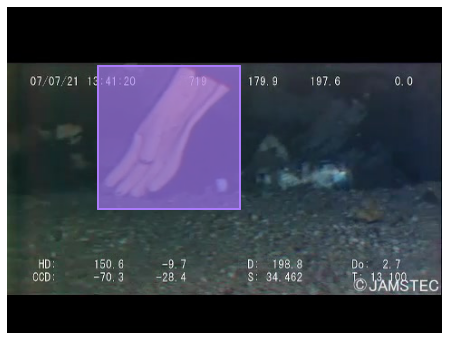

In [27]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

In [28]:
with open(annFile, 'r') as f:
    dataset = json.loads(f.read())

# select only trash
allowed_items = ['plastic', 'unknown', 'cloth', 'rubber', 'metal', 'wood', 'platstic', 'paper', 'papper']
cat_names = [item['name'] for item in dataset['categories'] if item['name'] in allowed_items]
trash_categories = [item for item in dataset['categories'] if item['name'] in allowed_items]

print(trash_categories)

# define variables
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

[{'supercategory': 'none', 'id': 1, 'name': 'plastic'}, {'supercategory': 'none', 'id': 2, 'name': 'paper'}, {'supercategory': 'none', 'id': 3, 'name': 'unknown'}, {'supercategory': 'none', 'id': 4, 'name': 'cloth'}, {'supercategory': 'none', 'id': 5, 'name': 'rubber'}, {'supercategory': 'none', 'id': 6, 'name': 'metal'}, {'supercategory': 'none', 'id': 7, 'name': 'wood'}]


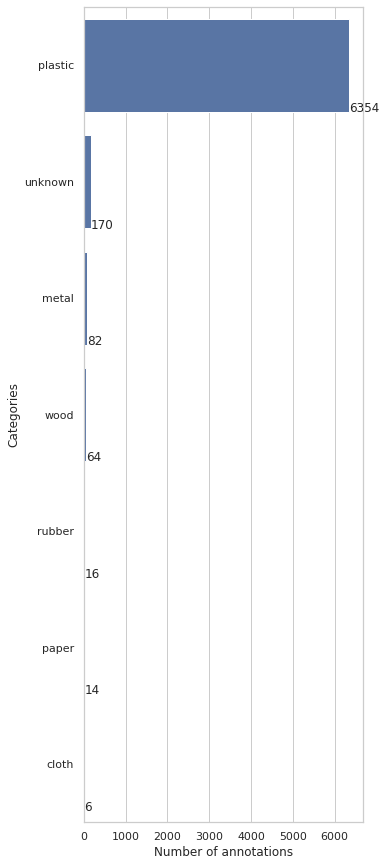

In [29]:
# Count annotations
cat_histogram = np.zeros(len(trash_categories),dtype=int)
for ann in dataset['annotations']:
    cat_histogram[ann['category_id'] - 1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,15))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
sns.set_color_codes("pastel")
sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")
show_values_on_bars(plot_1, "h", 0.3)

In [30]:
print(len(dataset['images']), len([ann for ann in dataset['annotations'] if ann['image_id'] in [i['id'] for i in dataset['images']]]))

7668 6706


In [31]:
def trashicra_to_detectwaste(label):
    metals_and_plastics = ['plastic', 'metal', 'rubber']
    non_recyclable = ['cloth', 'paper']
    bio = ['wood']
    unknown = ['unknown']

    if (label in metals_and_plastics):
        label="metals_and_plastics"
    elif(label in non_recyclable):
        label="non-recyclable"
    elif(label in bio):
        label="bio"
    elif(label in unknown):
        label="unknown"
    else:
        print(label, "is non-trashicra label")
        label = "unknown"
    return label

In [32]:
# convert all taco anns to detect-waste anns
# let's change supercategory to detectwaste
detectwaste_categories = dataset['categories']
for ann in anns:    
    cat_id = ann['category_id']
    cat_trashicra = categories[cat_id-1]['name']
    detectwaste_categories[cat_id-1]['supercategory'] = trashicra_to_detectwaste(cat_trashicra)
# As there is no representation of "Plastified paper bag" in annotated data, change of this supercategory was done manually.
detectwaste_categories

[{'supercategory': 'metals_and_plastics', 'id': 1, 'name': 'plastic'},
 {'supercategory': 'non-recyclable', 'id': 2, 'name': 'paper'},
 {'supercategory': 'unknown', 'id': 3, 'name': 'unknown'},
 {'supercategory': 'non-recyclable', 'id': 4, 'name': 'cloth'},
 {'supercategory': 'metals_and_plastics', 'id': 5, 'name': 'rubber'},
 {'supercategory': 'metals_and_plastics', 'id': 6, 'name': 'metal'},
 {'supercategory': 'bio', 'id': 7, 'name': 'wood'}]

In [33]:
detectwaste_ids = {}
detectwaste_cat_names = []
cat_id = 0
for cat in detectwaste_categories:
    if cat['supercategory'] not in detectwaste_ids:
        detectwaste_cat_names.append(cat['supercategory'])
        detectwaste_ids[cat['supercategory']] = cat_id
        cat_id += 1
        


trashicra_to_detectwaste_ids = {}
for i, cat in enumerate(detectwaste_categories):
    trashicra_to_detectwaste_ids[cat['id']] = detectwaste_ids[cat['supercategory']]
    
# print(taco_to_detectwaste_ids)



anns_detectwaste = anns.copy()
for i, ann in enumerate(anns):
    #print(ann['category_id'])
    anns_detectwaste[i]['category_id'] = trashicra_to_detectwaste_ids[ann['category_id']]
    anns_detectwaste[i].pop('segmentation', None)


Text(0.5, 1.0, 'Annotations per detectwaste category')

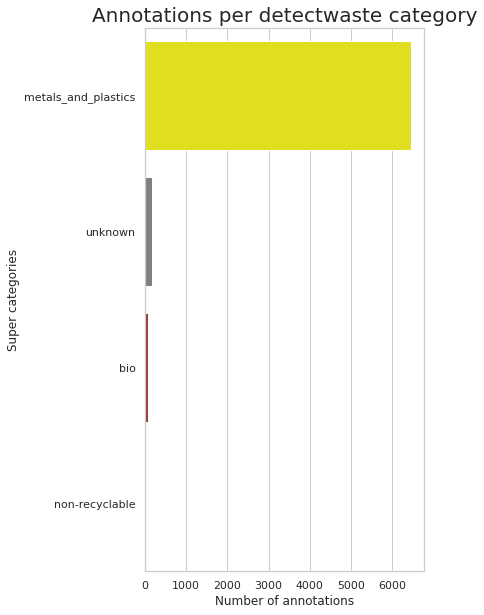

In [34]:
# Count annotations
detectwaste_cat_histogram = np.zeros(len(detectwaste_cat_names),dtype=int)

for ann in anns_detectwaste:
    cat_id = ann['category_id']
    detectwaste_cat_histogram[cat_id] +=1


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,10))

# Convert to DataFrame
d ={'Super categories': detectwaste_cat_names, 'Number of annotations': detectwaste_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)

sup_cat = df.loc[:,'Super categories'].tolist()
colors = [colors_recykling[cat] for cat in sup_cat]

sns.set_palette(sns.color_palette(colors))
plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
            label="Total")
plot_1.set_title('Annotations per detectwaste category',fontsize=20)

### bbox statistics

In [35]:
def bbox_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['bbox'][2] for pic in anns]
    picsh = [pic['bbox'][3] for pic in anns]
    bbox_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(bbox_size)
    if calc == 'median':
        return np.median(bbox_size)

def area_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['area'] for pic in anns]
    picsh = [pic['area'] for pic in anns]
    area_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(area_size)
    if calc == 'median':
        return np.median(area_size)

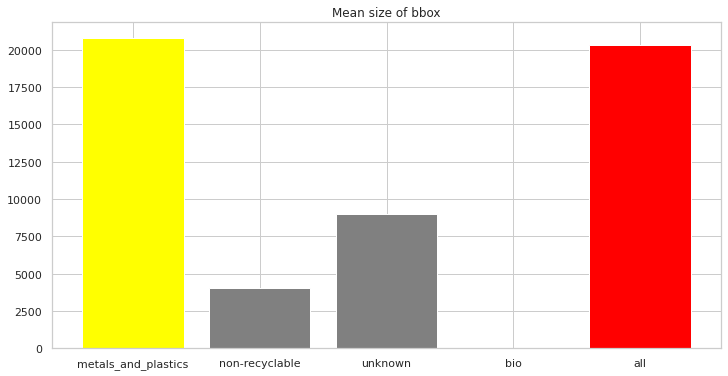

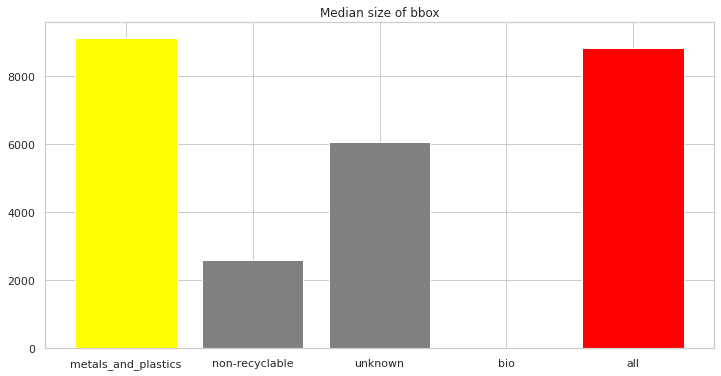

In [36]:
pylab.rcParams['figure.figsize'] = (12,6)

mean_bbox = []
median_bbox = []
for cat_nr, cat in enumerate(detectwaste_cat_names):
    
    temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
    mean_bbox.append(bbox_stats(temp_anns,)) 
    median_bbox.append(bbox_stats(temp_anns,'median'))
mean_bbox[-1] =0
median_bbox[-1] =0


# append stats for all for comparison
temp_detectwaste_cat_names = detectwaste_cat_names.copy()
temp_detectwaste_cat_names.append('all')
mean_bbox.append(bbox_stats(anns_detectwaste)) 
median_bbox.append(bbox_stats(anns_detectwaste,'median'))

colors = [colors_recykling[name] for name in detectwaste_cat_names]
colors.append('red')


plt.bar(temp_detectwaste_cat_names,mean_bbox, color=colors)
plt.title('Mean size of bbox')
plt.show()

plt.bar(temp_detectwaste_cat_names,median_bbox, color=colors)
plt.title('Median size of bbox')
plt.show()

['metals_and_plastics', 'non-recyclable', 'unknown', 'bio', 'all']


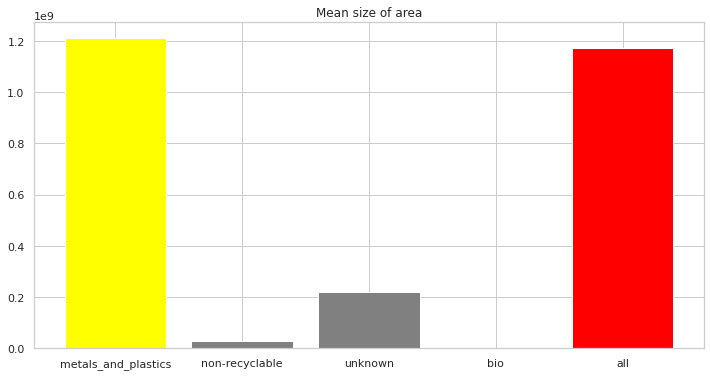

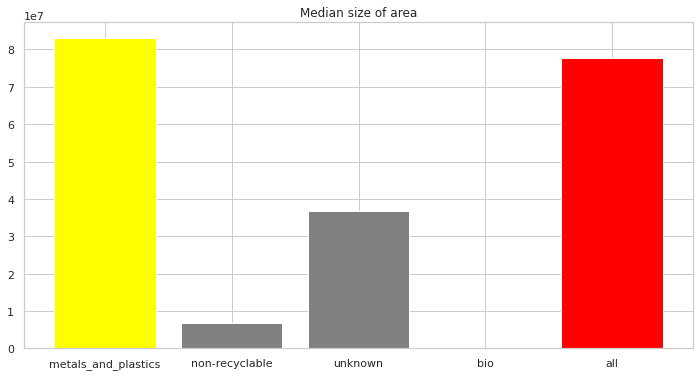

In [37]:
mean_area = []
median_area = []
for cat_nr, cat in enumerate(detectwaste_cat_names):
    temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
    mean_area.append(area_stats(temp_anns,)) 
    median_area.append(area_stats(temp_anns,'median'))

mean_area[-1] = 0
median_area[-1] = 0
mean_area.append(area_stats(anns_detectwaste)) 
median_area.append(area_stats(anns_detectwaste,'median'))
print(temp_detectwaste_cat_names)

plt.bar(temp_detectwaste_cat_names,mean_area, color=colors)
plt.title('Mean size of area')
plt.show()

plt.bar(temp_detectwaste_cat_names,median_area, color=colors)
plt.title('Median size of area')
plt.show()

### Number of bboxes per image

In [38]:
def no_bbox_per_image(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    return np.mean(list_of_duplicates)
def no_bbox_summary(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    print('Maximum bboxes: ',np.max(list_of_duplicates))
    print('Mean number of bboxes: ',np.mean(list_of_duplicates))
    print('Median number of bboxes: ',np.median(list_of_duplicates))


print('all:',no_bbox_per_image(anns_detectwaste))
for cat_nr, cat in enumerate(detectwaste_cat_names):
    try:
        temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
        print('\n', cat)
        no_bbox_summary(temp_anns)
    except:
        continue
    

all: 1.086734693877551

 metals_and_plastics
Maximum bboxes:  4
Mean number of bboxes:  1.0732838589981446
Median number of bboxes:  1.0

 non-recyclable

 unknown

 bio


### Number of images per image shape

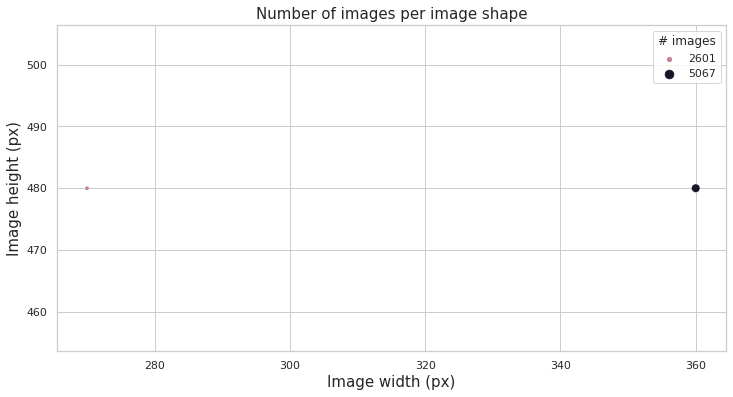

In [39]:
# Parsing image shapes (resolutions)
widths = []
heights = []
shape_freqs = []
img_shapes_keys = {}
for img in dataset['images']:
    key = str(img['width'])+'-'+str(img['height'])
    if key in img_shapes_keys:
        shape_id = img_shapes_keys[key]
        shape_freqs[shape_id] += 1
    else:
        img_shapes_keys[key] = len(widths)
        widths.append(img['width'])
        heights.append(img['height'])
        shape_freqs.append(1)


d ={'Image width (px)': widths, 'Image height (px)': heights, '# images': shape_freqs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
plot = sns.scatterplot(x="Image width (px)", y="Image height (px)", size='# images', hue="# images", palette = cmap,data=df)
plt.xlabel('Image width (px)', fontsize=15)
plt.ylabel('Image height (px)', fontsize=15)
plot = plot.set_title('Number of images per image shape',fontsize=15)

### Placement of central point of the bbox in the image

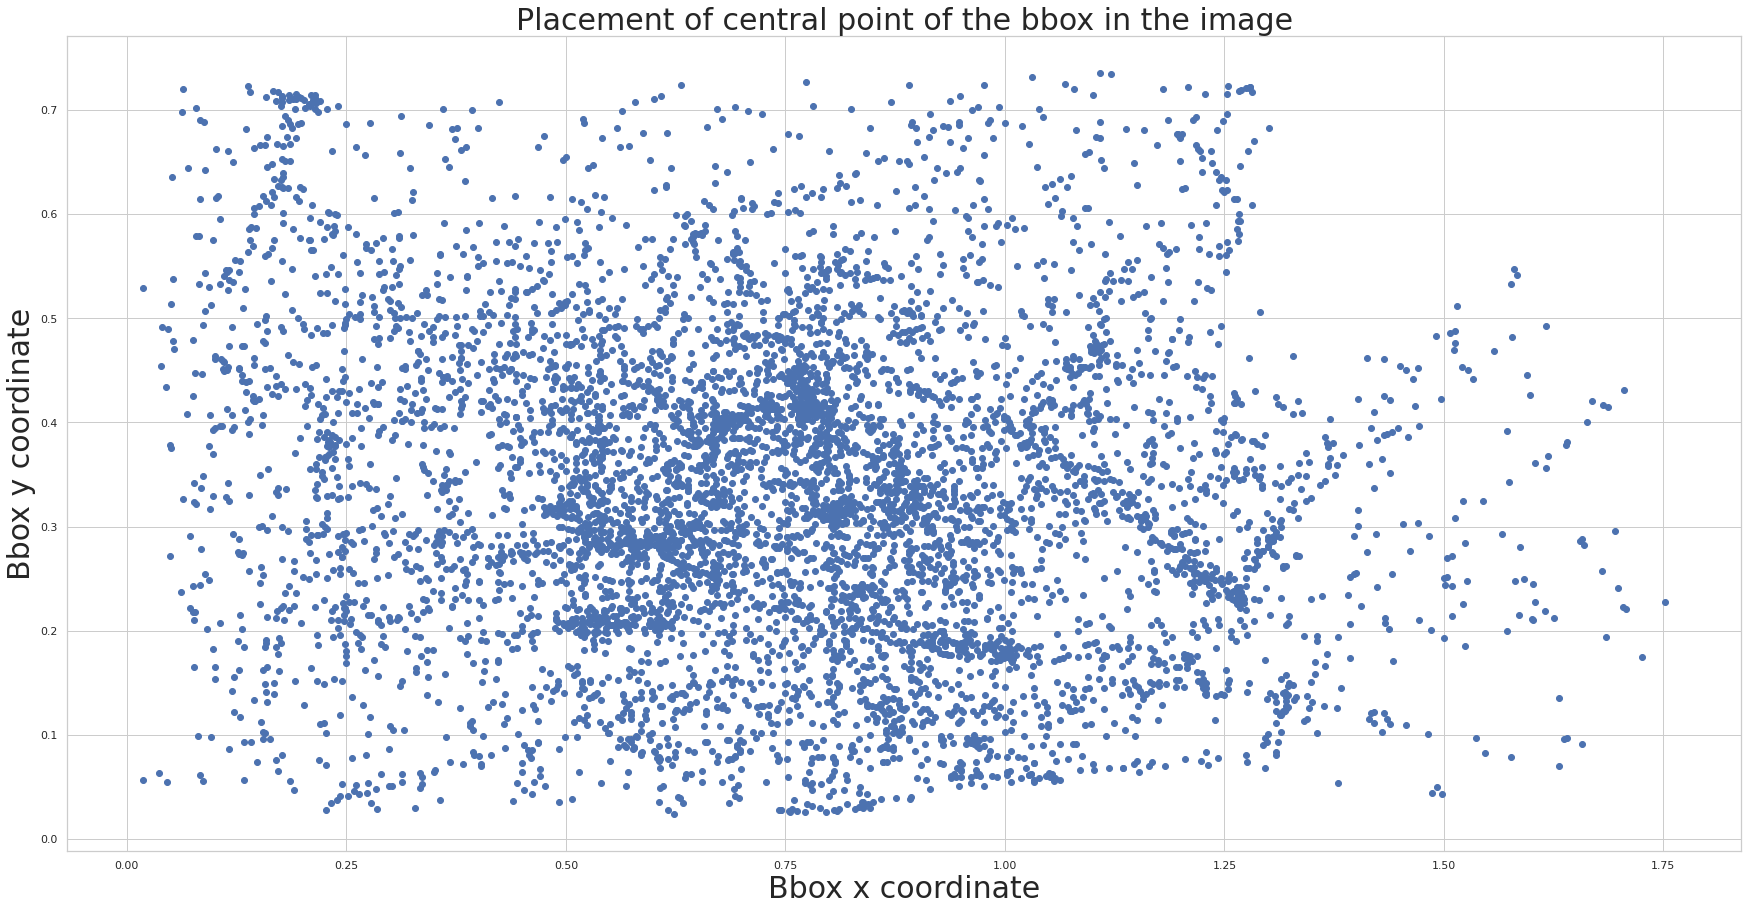

In [40]:
center_x = []
center_y = []
for i in range(0, len(anns_detectwaste)):
    for j in range (0, len(dataset['images'])):
        if dataset['images'][j]['id'] == anns_detectwaste[i]['image_id']:
            
            center_x.append((anns_detectwaste[i]['bbox'][0]+anns_detectwaste[i]['bbox'][2]/2)/dataset['images'][j]['width'])
            center_y.append((anns_detectwaste[i]['bbox'][1]+anns_detectwaste[i]['bbox'][3]/2)/dataset['images'][j]['height'])
plt.figure(figsize=(30,15))
plt.plot(center_x, center_y, 'bo')
plt.title('Placement of central point of the bbox in the image', fontsize=30)
plt.xlabel('Bbox x coordinate', fontsize=30)
plt.ylabel('Bbox y coordinate', fontsize=30)
plt.show()

### Number of annotations per image

/home/zklawikowska/project/env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean number of annotations per image: 0.8745435576421492


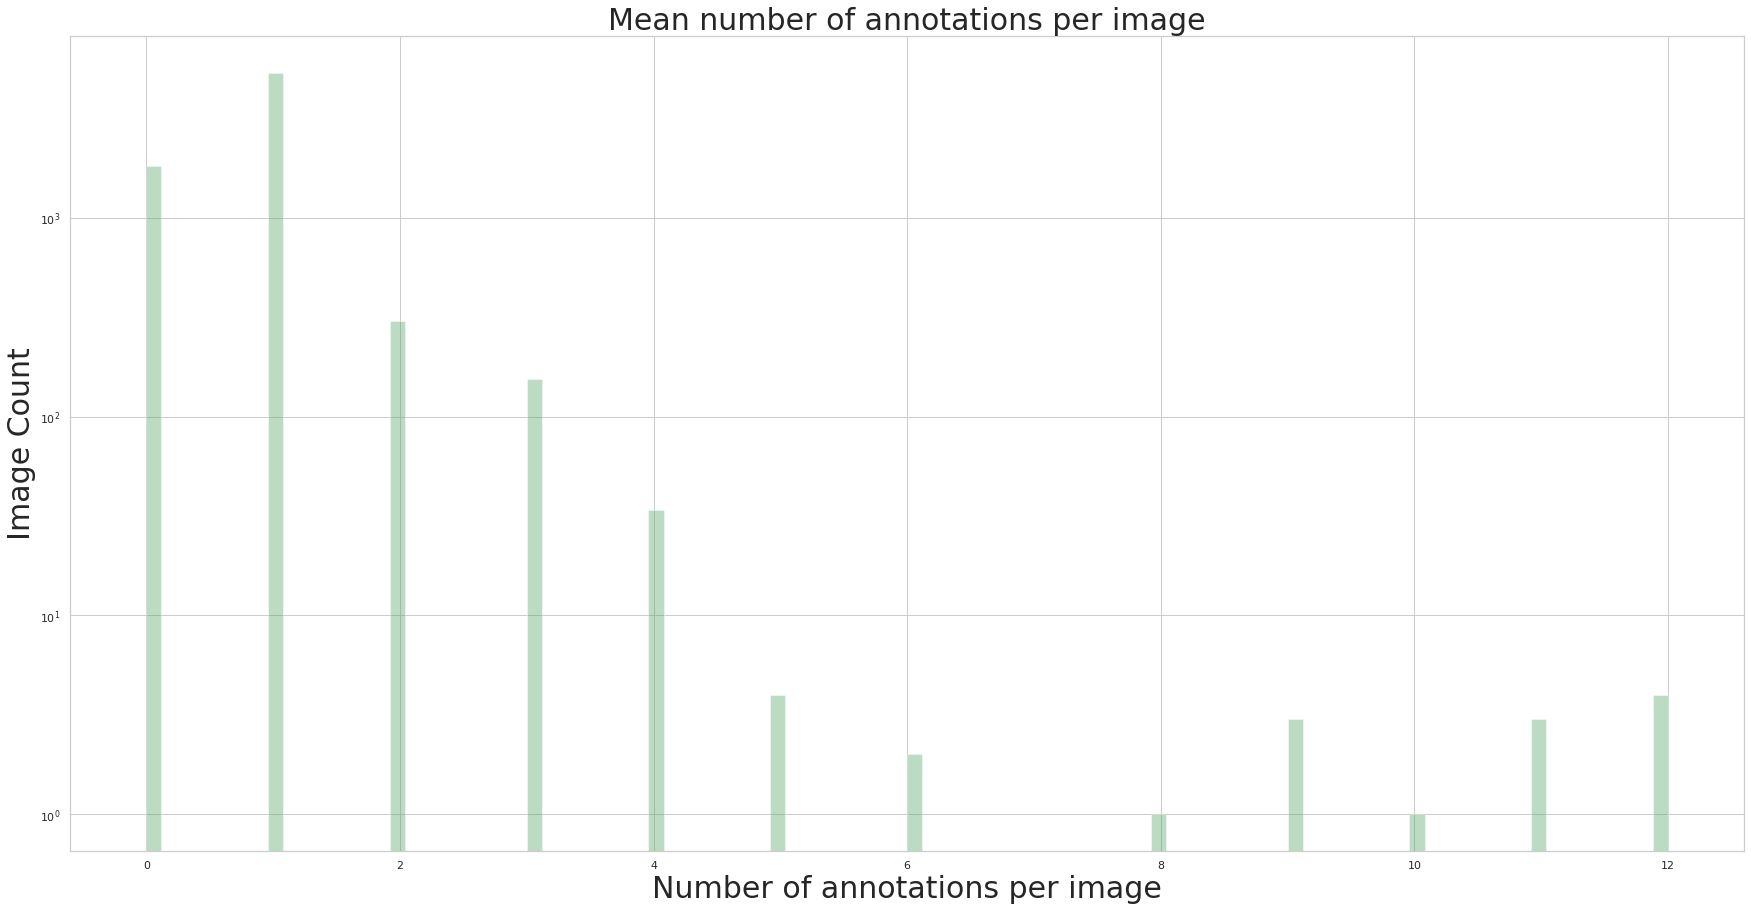

In [41]:
nr_annotation_per_image = []
annotations_per_image = []
for img in dataset['images']:
    annotations_per_image = []
    for i in range(0, len(anns_detectwaste)):
        if img['id'] == anns_detectwaste[i]['image_id']:
            annotations_per_image.append(anns_detectwaste[i]['id'])
    nr_annotation_per_image.append(len(annotations_per_image))

plt.figure(figsize=(30,15))
ax = sns.distplot(nr_annotation_per_image,kde=False,bins=100, color='g')
ax.set_yscale('log')
plt.title('Mean number of annotations per image', fontsize=30)
plt.xlabel('Number of annotations per image', fontsize=30)
plt.ylabel('Image Count', fontsize=30)

print('Mean number of annotations per image:',np.mean(nr_annotation_per_image))

### Bbox size - absolute and relative

According to MS COCO Evaluation. This dataset has:
0 small objects (area<32*32 px)
50 medium objects (area<96*96 px)
567 large objects (area>96*96 px)
Number of bboxes smaller than 1024: 6706
Number of bboxes larger than 1024: 0
Number of missing annotations 122


Text(0.5, 1.0, 'Bounding-boxes size')

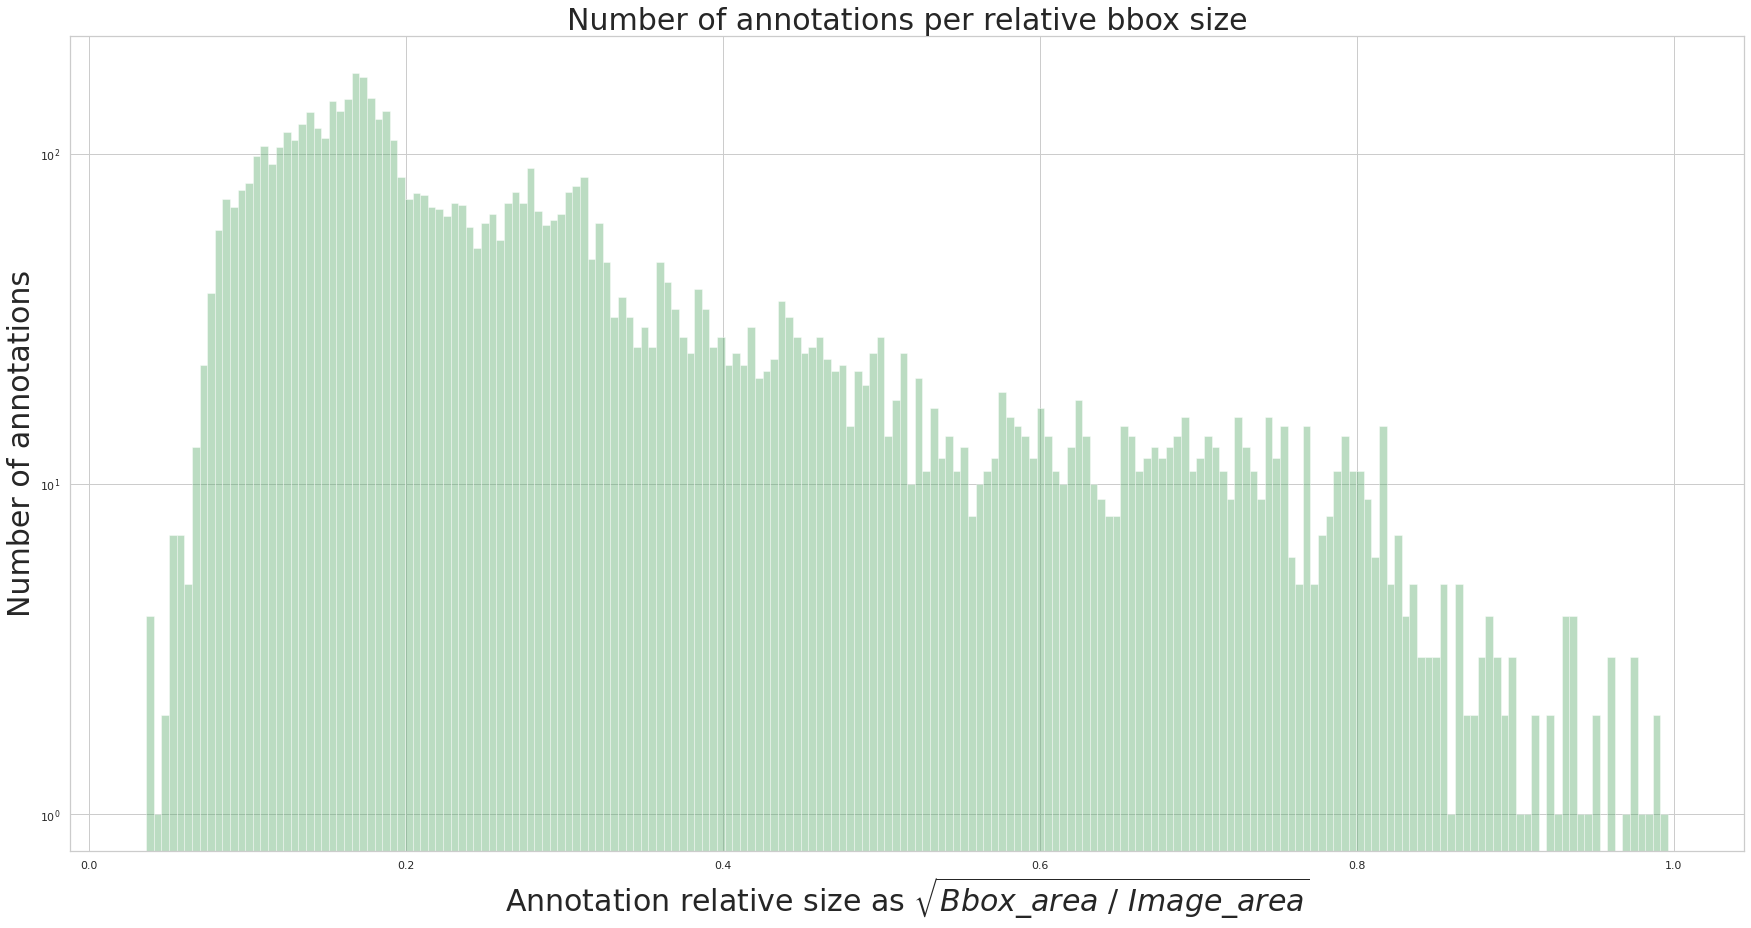

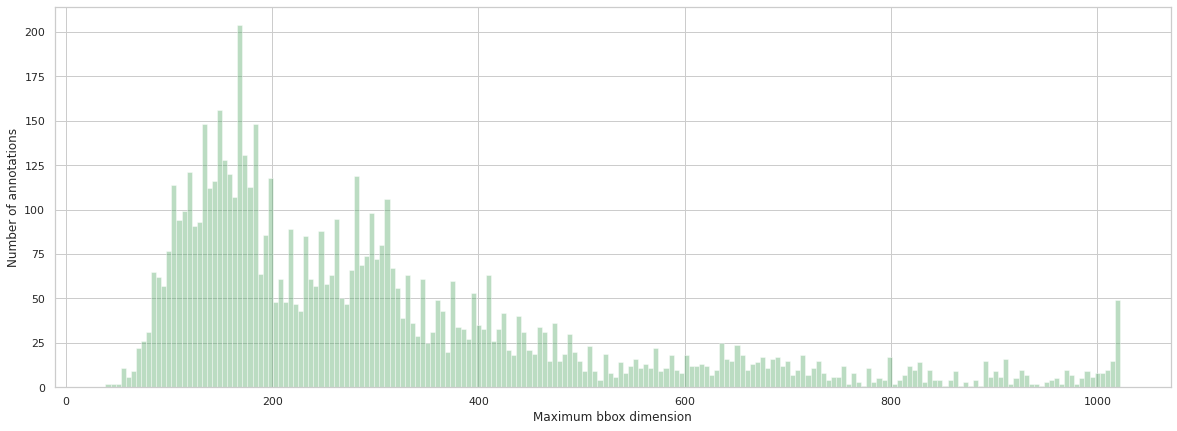

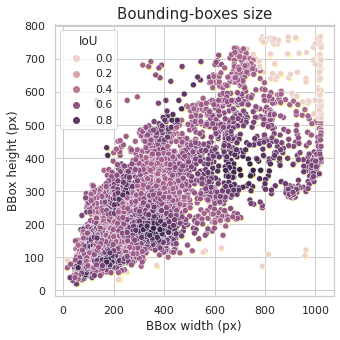

In [42]:
bbox_widths = []
bbox_heights = []
obj_areas_sqrt = []
obj_areas_sqrt_fraction = []
bbox_aspect_ratio = []
max_image_dim = 1024

for ann in anns_detectwaste:
    
    imgs = dataset['images']
    
    resize_scale = max_image_dim/max(imgs[0]['width'], imgs[0]['height'])
    # Uncomment this to work on original image size
#     resize_scale = 1
    
    bbox_widths.append(ann['bbox'][2]*resize_scale)
    bbox_heights.append(ann['bbox'][3]*resize_scale)
    obj_area = ann['bbox'][2]*ann['bbox'][3]*resize_scale**2 # ann['area']
    obj_areas_sqrt.append(np.sqrt(obj_area))
        
    img_area = imgs[0]['width']*imgs[0]['height']*resize_scale**2
    obj_areas_sqrt_fraction.append(np.sqrt(obj_area/img_area))
    

print('According to MS COCO Evaluation. This dataset has:')
print(np.sum(np.array(obj_areas_sqrt)<32), 'small objects (area<32*32 px)')
print(np.sum(np.array(obj_areas_sqrt)<64), 'medium objects (area<96*96 px)')
print(np.sum(np.array(obj_areas_sqrt)<96), 'large objects (area>96*96 px)')
    
# d ={'Bbox width (px)': bbox_widths, 'Bbox height (px)': bbox_heights, 'area': seg_areas}
# df = pd.DataFrame(d)

plt.figure(figsize=(30,15))
ax = sns.distplot(obj_areas_sqrt_fraction,kde=False, bins=200, color='g')
ax.set_yscale('log')
plt.title('Number of annotations per relative bbox size', fontsize=30)
plt.xlabel(r'Annotation relative size as $\sqrt{ Bbox\_area \ /  \ Image\_area}$', fontsize=30)
plt.ylabel('Number of annotations', fontsize=30)

plt.figure(figsize=(20,7))
ax = sns.distplot(np.maximum(np.array(bbox_widths),np.array(bbox_heights)),kde=False, bins=200, color='g')
ax = ax.set(xlabel='Maximum bbox dimension', ylabel='Number of annotations')

import colorsys
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", palette = cmap,data=df)

print('Number of bboxes smaller than 1024:',np.sum(np.array(bbox_widths)<1024))
print('Number of bboxes larger than 1024:',np.sum(np.array(bbox_widths)>1024))

# anchors = [(32,32),(64,64),(128,128),(256,256),(512,512)]
scales, ratios = np.meshgrid(np.array([16,32,64,128,256,512]), np.array([0.5,1,2]))
scales = scales.flatten()
ratios = ratios.flatten()
# Enumerate heights and widths from scales and ratios
anchor_heights = scales / np.sqrt(ratios)
anchor_widths = scales * np.sqrt(ratios)

IoUs = []
for i in range(len(bbox_widths)):
    bbox_area = bbox_widths[i]*bbox_heights[i]
    IoU_max = 0.0
    for j in range(len(anchor_heights)):
        anchor_area = anchor_heights[j]*anchor_widths[j]
        intersection_area = min(anchor_widths[j],bbox_widths[i])*min(anchor_heights[j], bbox_heights[i])
        IoU = intersection_area / (bbox_area + anchor_area - intersection_area)
        if IoU>0.5:
            IoU_max = IoU
    IoUs.append(IoU_max)
    
print('Number of missing annotations', np.sum(np.array(IoUs)==0.0))
  
# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights, 'IoU': IoUs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", hue = 'IoU',data=df)
plt.title('Bounding-boxes size', fontsize=15)

## UAVVaste
- background: outside
- classes: 1
- comment: very distance trash (from dron)
- annotation: instance masks

In [4]:
dataDir='/dih4/dih4_2/wimlds/data/uavvaste'
dataType='images'
annFile='{}/annotations.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [5]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(', '.join(nms)))

COCO categories: 
rubbish

COCO supercategories: 



Image n°198
Image name: /dih4/dih4_2/wimlds/data/uavvaste/images/batch_s02_img_135.jpg


(-0.5, 3667.5, 1627.5, -0.5)

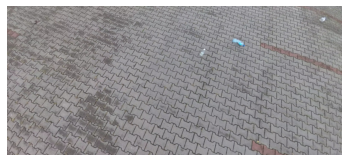

In [6]:
# load and display image
catIds = coco.getCatIds(catNms=['rubber']);
imgIds = coco.getImgIds(catIds=catIds);
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
#img_name = '%s/%s'%(dataDir, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)
plt.axis('off')

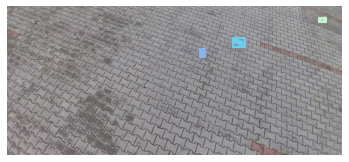

In [7]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

In [8]:
with open(annFile, 'r') as f:
    dataset = json.loads(f.read())

cat_names = [item['name'] for item in dataset['categories'] if item['name']]
trash_categories = dataset['categories']
    
# define variables
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

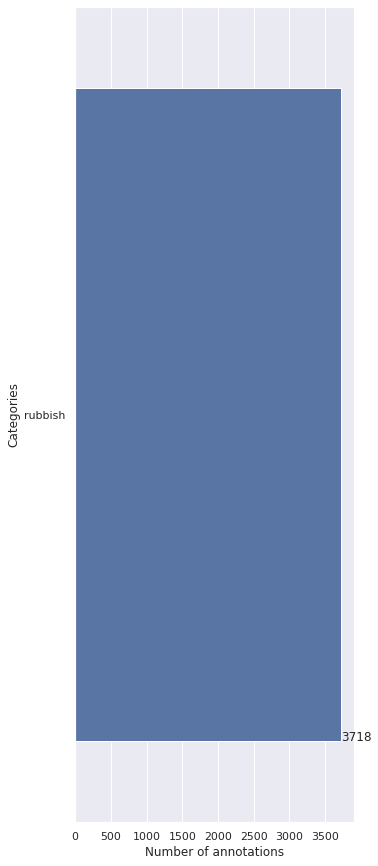

In [9]:
# Count annotations
cat_histogram = np.zeros(len(trash_categories),dtype=int)
for ann in dataset['annotations']:
    cat_histogram[ann['category_id'] - 1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,15))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
sns.set_color_codes("pastel")
sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")
show_values_on_bars(plot_1, "h", 0.3)

In [10]:
print(len(dataset['images']), len([ann for ann in dataset['annotations'] if ann['image_id'] in [i['id'] for i in dataset['images']]]))

772 3718


In [18]:
def UAVVaste_to_detectwaste(label):    
    return "unknown"

In [21]:
# convert all taco anns to detect-waste anns
# let's change supercategory to detectwaste
detectwaste_categories = dataset['categories']
for ann in anns:    
    cat_id = ann['category_id']
    
    cat_UAVVaste = categories[cat_id-1]['name']
    
    detectwaste_categories[cat_id-1]['supercategory'] = UAVVaste_to_detectwaste(cat_UAVVaste)
# # As there is no representation of "Plastified paper bag" in annotated data, change of this supercategory was done manually.
detectwaste_categories

[{'supercategory': 'unknown', 'id': 1, 'name': 'rubbish'}]

In [23]:
detectwaste_ids = {}
detectwaste_cat_names = []
cat_id = 0
for cat in detectwaste_categories:
    if cat['supercategory'] not in detectwaste_ids:
        detectwaste_cat_names.append(cat['supercategory'])
        detectwaste_ids[cat['supercategory']] = cat_id
        cat_id += 1
        


UAVVaste_to_detectwaste_ids = {}
for i, cat in enumerate(detectwaste_categories):
    UAVVaste_to_detectwaste_ids[cat['id']] = detectwaste_ids[cat['supercategory']]
    
# print(taco_to_detectwaste_ids)



anns_detectwaste = anns.copy()
for i, ann in enumerate(anns):
    #print(ann['category_id'])
    anns_detectwaste[i]['category_id'] = UAVVaste_to_detectwaste_ids[ann['category_id']]
    anns_detectwaste[i].pop('segmentation', None)


Text(0.5, 1.0, 'Annotations per detectwaste category')

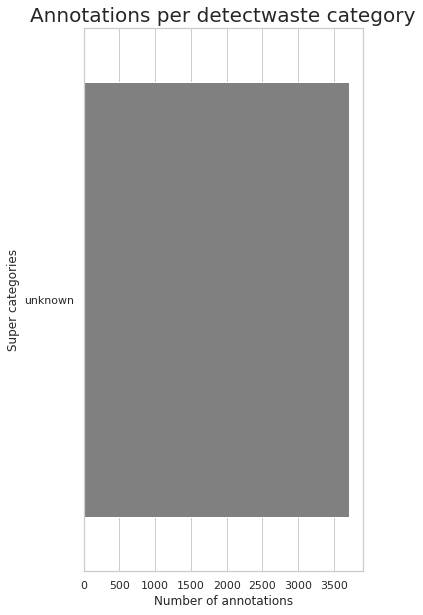

In [24]:
# Count annotations
detectwaste_cat_histogram = np.zeros(len(detectwaste_cat_names),dtype=int)

for ann in anns_detectwaste:
    cat_id = ann['category_id']
    detectwaste_cat_histogram[cat_id] +=1


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,10))

# Convert to DataFrame
d ={'Super categories': detectwaste_cat_names, 'Number of annotations': detectwaste_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)

sup_cat = df.loc[:,'Super categories'].tolist()
colors = [colors_recykling[cat] for cat in sup_cat]

sns.set_palette(sns.color_palette(colors))
plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
            label="Total")
plot_1.set_title('Annotations per detectwaste category',fontsize=20)

### bbox statistics

In [25]:
def bbox_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['bbox'][2] for pic in anns]
    picsh = [pic['bbox'][3] for pic in anns]
    bbox_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(bbox_size)
    if calc == 'median':
        return np.median(bbox_size)

def area_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['area'] for pic in anns]
    picsh = [pic['area'] for pic in anns]
    area_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(area_size)
    if calc == 'median':
        return np.median(area_size)

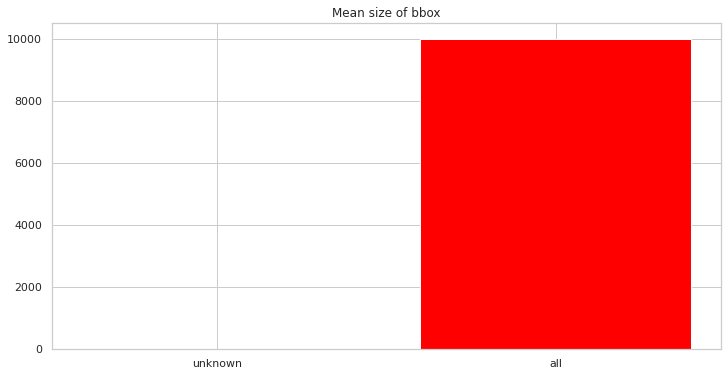

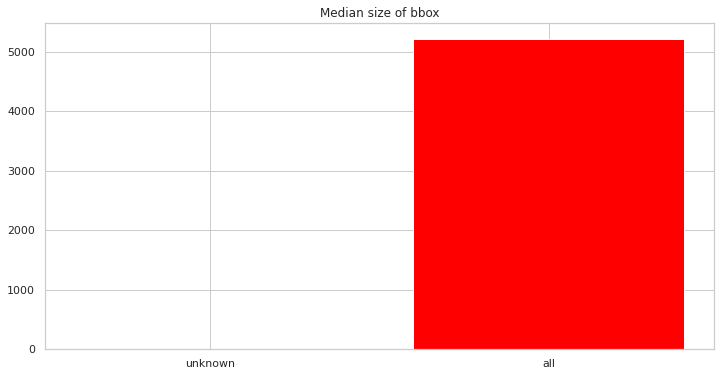

[0, 10011.181011296396]

In [27]:
pylab.rcParams['figure.figsize'] = (12,6)

mean_bbox = []
median_bbox = []
for cat_nr, cat in enumerate(detectwaste_cat_names):
    
    temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
    mean_bbox.append(bbox_stats(temp_anns,)) 
    median_bbox.append(bbox_stats(temp_anns,'median'))
mean_bbox[-1] =0
median_bbox[-1] =0


# append stats for all for comparison
temp_detectwaste_cat_names = detectwaste_cat_names.copy()
temp_detectwaste_cat_names.append('all')
mean_bbox.append(bbox_stats(anns_detectwaste)) 
median_bbox.append(bbox_stats(anns_detectwaste,'median'))

colors = [colors_recykling[name] for name in detectwaste_cat_names]
colors.append('red')


plt.bar(temp_detectwaste_cat_names,mean_bbox, color=colors)
plt.title('Mean size of bbox')
plt.show()

plt.bar(temp_detectwaste_cat_names,median_bbox, color=colors)
plt.title('Median size of bbox')
plt.show()


['unknown', 'all']


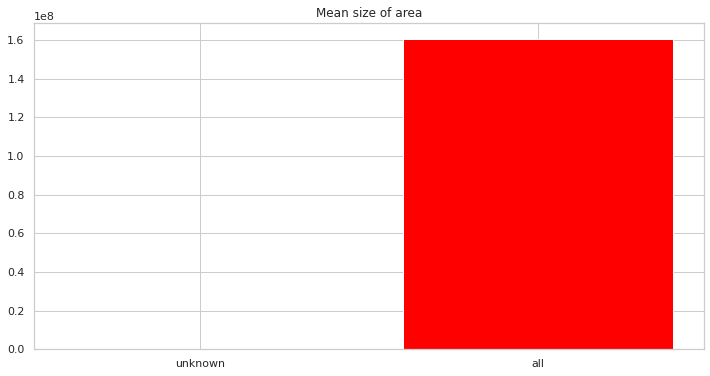

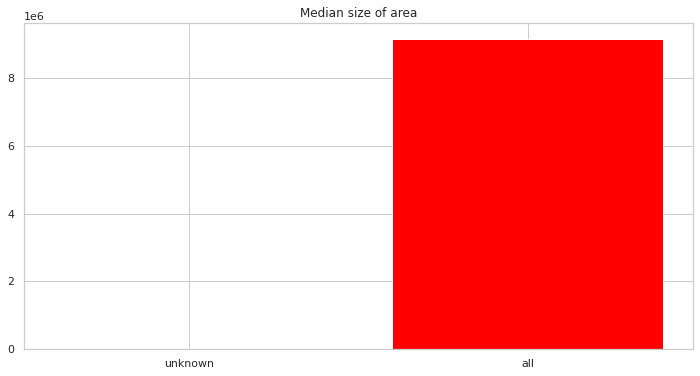

In [28]:
mean_area = []
median_area = []
for cat_nr, cat in enumerate(detectwaste_cat_names):
    temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
    mean_area.append(area_stats(temp_anns,)) 
    median_area.append(area_stats(temp_anns,'median'))

mean_area[-1] = 0
median_area[-1] = 0
mean_area.append(area_stats(anns_detectwaste)) 
median_area.append(area_stats(anns_detectwaste,'median'))
print(temp_detectwaste_cat_names)

plt.bar(temp_detectwaste_cat_names,mean_area, color=colors)
plt.title('Mean size of area')
plt.show()

plt.bar(temp_detectwaste_cat_names,median_area, color=colors)
plt.title('Median size of area')
plt.show()

### Number of bboxes per image

In [29]:
def no_bbox_per_image(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    return np.mean(list_of_duplicates)
def no_bbox_summary(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    print('Maximum bboxes: ',np.max(list_of_duplicates))
    print('Mean number of bboxes: ',np.mean(list_of_duplicates))
    print('Median number of bboxes: ',np.median(list_of_duplicates))


print('all:',no_bbox_per_image(anns_detectwaste))
for cat_nr, cat in enumerate(detectwaste_cat_names):
    try:
        temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
        print('\n', cat)
        no_bbox_summary(temp_anns)
    except:
        continue
    

all: 4.816062176165803

 unknown
Maximum bboxes:  65
Mean number of bboxes:  4.816062176165803
Median number of bboxes:  4.0


### Number of images per image shape

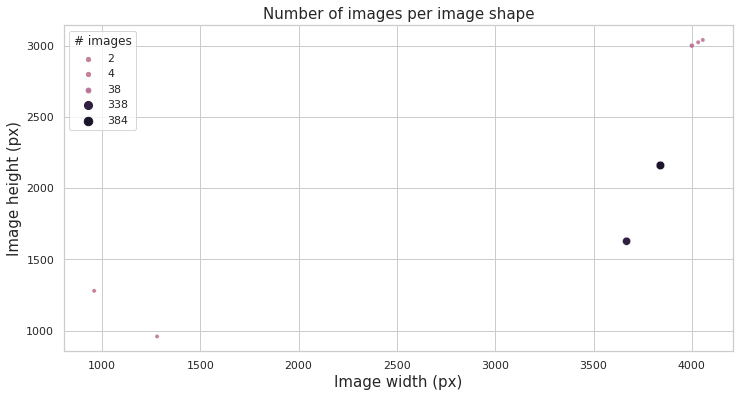

In [30]:
# Parsing image shapes (resolutions)
widths = []
heights = []
shape_freqs = []
img_shapes_keys = {}
for img in dataset['images']:
    key = str(img['width'])+'-'+str(img['height'])
    if key in img_shapes_keys:
        shape_id = img_shapes_keys[key]
        shape_freqs[shape_id] += 1
    else:
        img_shapes_keys[key] = len(widths)
        widths.append(img['width'])
        heights.append(img['height'])
        shape_freqs.append(1)


d ={'Image width (px)': widths, 'Image height (px)': heights, '# images': shape_freqs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
plot = sns.scatterplot(x="Image width (px)", y="Image height (px)", size='# images', hue="# images", palette = cmap,data=df)
plt.xlabel('Image width (px)', fontsize=15)
plt.ylabel('Image height (px)', fontsize=15)
plot = plot.set_title('Number of images per image shape',fontsize=15)

### Placement of central point of the bbox in the image

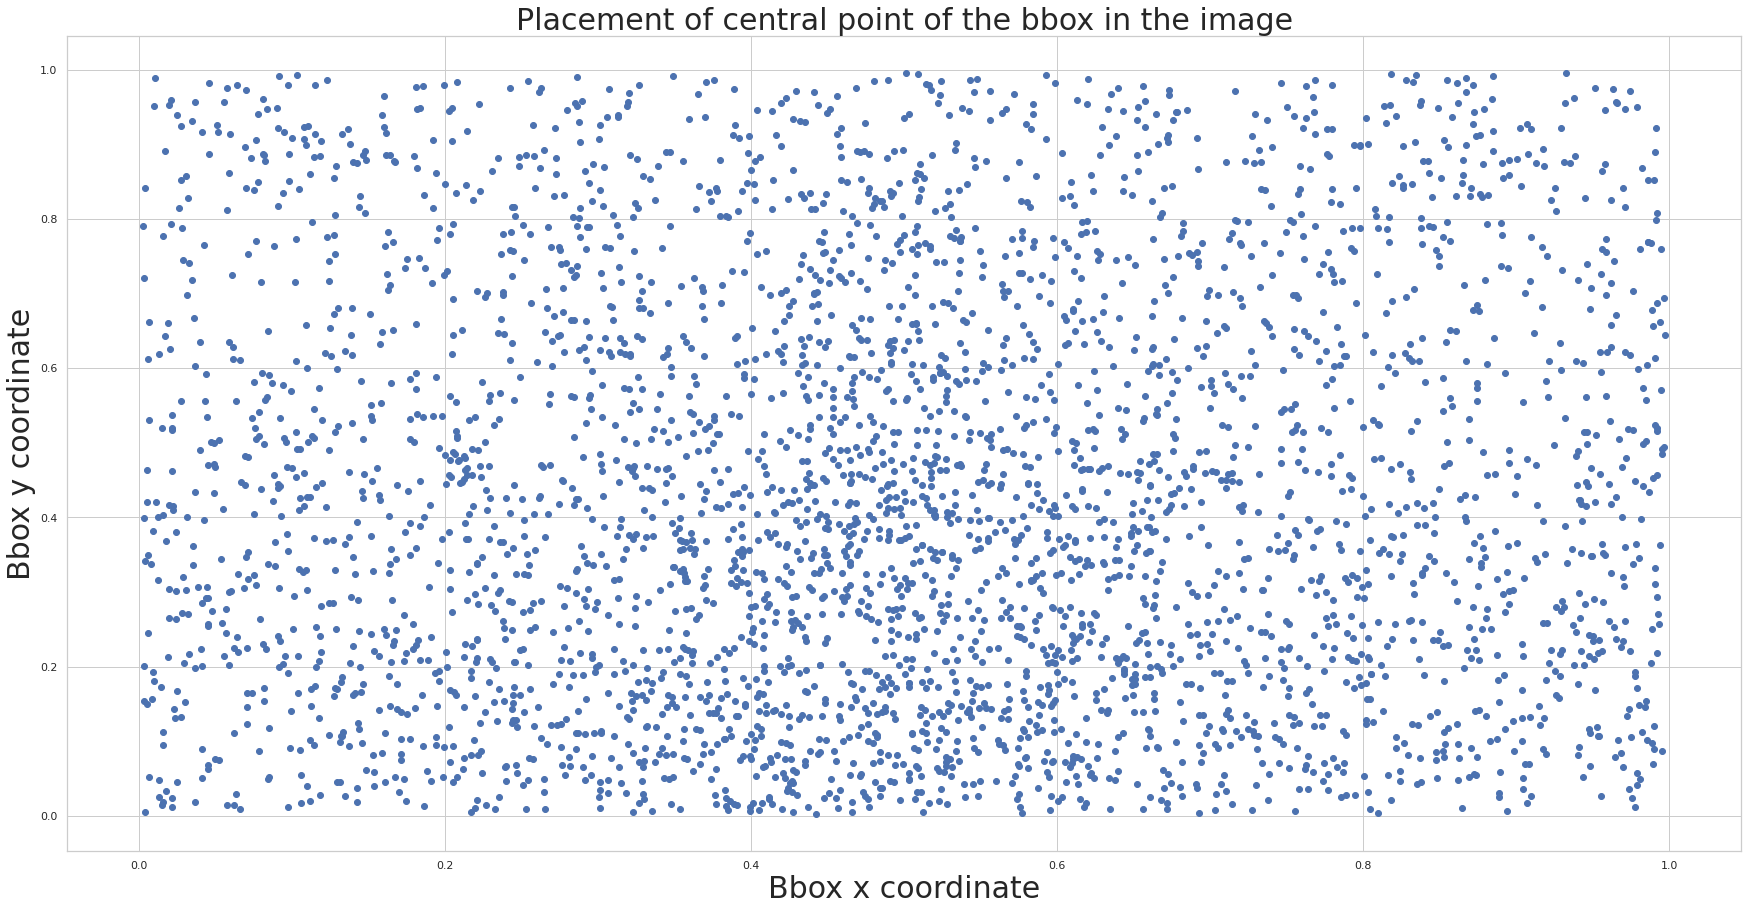

In [31]:
center_x = []
center_y = []
for i in range(0, len(anns_detectwaste)):
    for j in range (0, len(dataset['images'])):
        if dataset['images'][j]['id'] == anns_detectwaste[i]['image_id']:
            
            center_x.append((anns_detectwaste[i]['bbox'][0]+anns_detectwaste[i]['bbox'][2]/2)/dataset['images'][j]['width'])
            center_y.append((anns_detectwaste[i]['bbox'][1]+anns_detectwaste[i]['bbox'][3]/2)/dataset['images'][j]['height'])
plt.figure(figsize=(30,15))
plt.plot(center_x, center_y, 'bo')
plt.title('Placement of central point of the bbox in the image', fontsize=30)
plt.xlabel('Bbox x coordinate', fontsize=30)
plt.ylabel('Bbox y coordinate', fontsize=30)
plt.show()

### Number of annotations per image

/home/zklawikowska/project/env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean number of annotations per image: 4.816062176165803


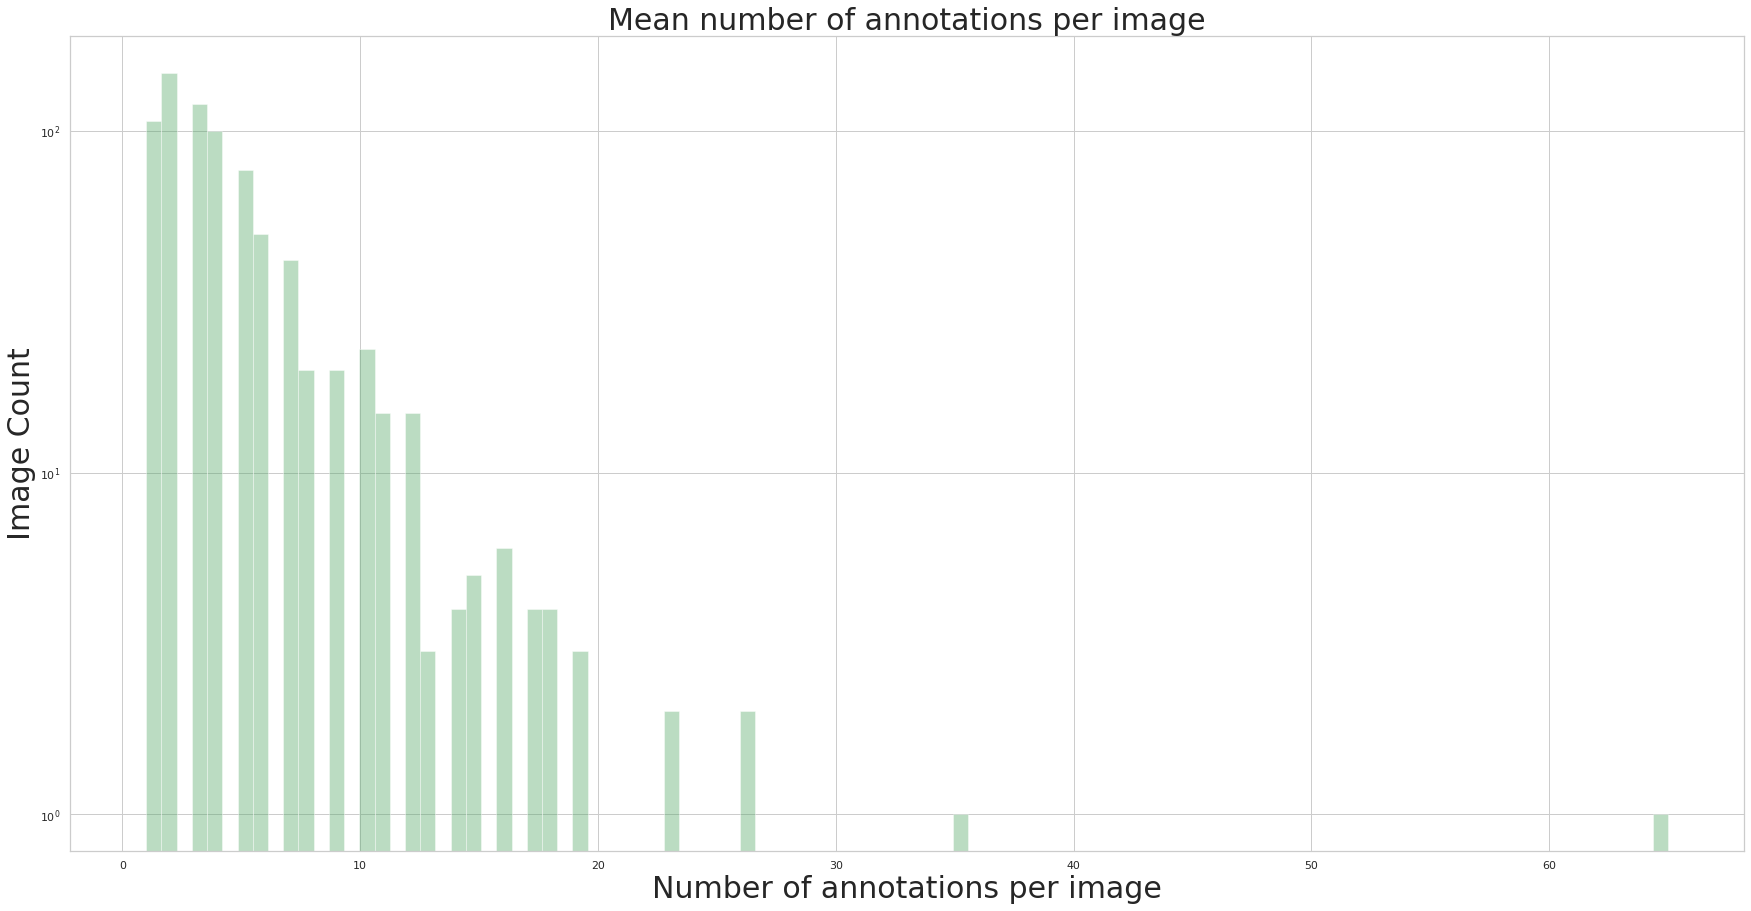

In [32]:
nr_annotation_per_image = []
annotations_per_image = []
for img in dataset['images']:
    annotations_per_image = []
    for i in range(0, len(anns_detectwaste)):
        if img['id'] == anns_detectwaste[i]['image_id']:
            annotations_per_image.append(anns_detectwaste[i]['id'])
    nr_annotation_per_image.append(len(annotations_per_image))

plt.figure(figsize=(30,15))
ax = sns.distplot(nr_annotation_per_image,kde=False,bins=100, color='g')
ax.set_yscale('log')
plt.title('Mean number of annotations per image', fontsize=30)
plt.xlabel('Number of annotations per image', fontsize=30)
plt.ylabel('Image Count', fontsize=30)

print('Mean number of annotations per image:',np.mean(nr_annotation_per_image))

### Bbox size - absolute and relative

According to MS COCO Evaluation. This dataset has:
3084 small objects (area<32*32 px)
3660 medium objects (area<96*96 px)
3703 large objects (area>96*96 px)
Number of bboxes smaller than 1024: 3718
Number of bboxes larger than 1024: 0
Number of missing annotations 696


Text(0.5, 1.0, 'Bounding-boxes size')

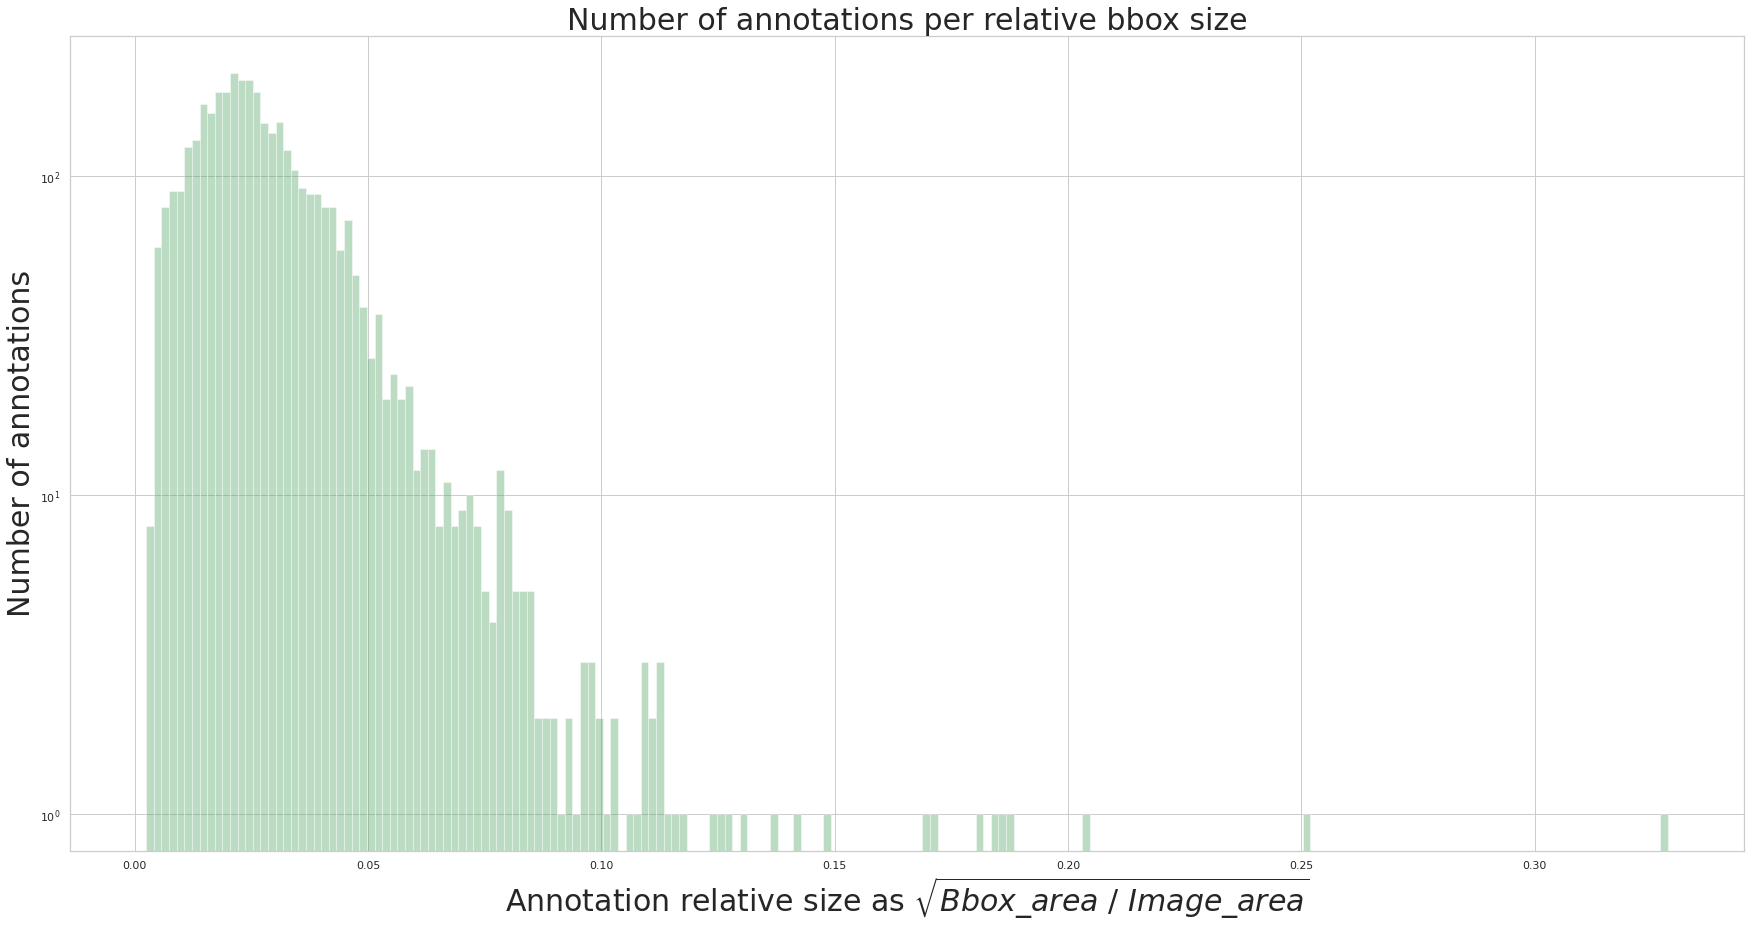

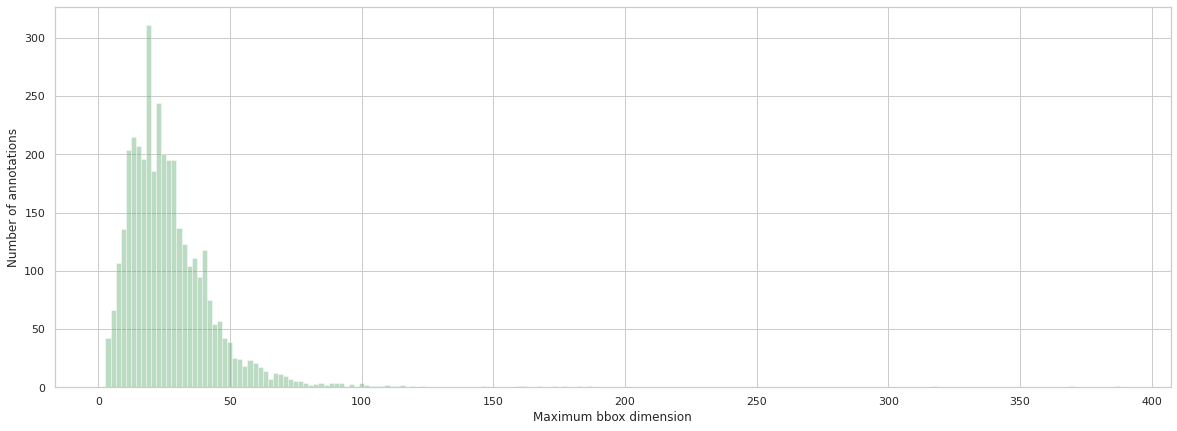

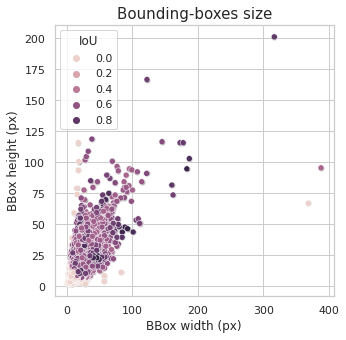

In [33]:
bbox_widths = []
bbox_heights = []
obj_areas_sqrt = []
obj_areas_sqrt_fraction = []
bbox_aspect_ratio = []
max_image_dim = 1024

for ann in anns_detectwaste:
    
    imgs = dataset['images']
    
    resize_scale = max_image_dim/max(imgs[0]['width'], imgs[0]['height'])
    # Uncomment this to work on original image size
#     resize_scale = 1
    
    bbox_widths.append(ann['bbox'][2]*resize_scale)
    bbox_heights.append(ann['bbox'][3]*resize_scale)
    obj_area = ann['bbox'][2]*ann['bbox'][3]*resize_scale**2 # ann['area']
    obj_areas_sqrt.append(np.sqrt(obj_area))
        
    img_area = imgs[0]['width']*imgs[0]['height']*resize_scale**2
    obj_areas_sqrt_fraction.append(np.sqrt(obj_area/img_area))
    

print('According to MS COCO Evaluation. This dataset has:')
print(np.sum(np.array(obj_areas_sqrt)<32), 'small objects (area<32*32 px)')
print(np.sum(np.array(obj_areas_sqrt)<64), 'medium objects (area<96*96 px)')
print(np.sum(np.array(obj_areas_sqrt)<96), 'large objects (area>96*96 px)')
    
# d ={'Bbox width (px)': bbox_widths, 'Bbox height (px)': bbox_heights, 'area': seg_areas}
# df = pd.DataFrame(d)

plt.figure(figsize=(30,15))
ax = sns.distplot(obj_areas_sqrt_fraction,kde=False, bins=200, color='g')
ax.set_yscale('log')
plt.title('Number of annotations per relative bbox size', fontsize=30)
plt.xlabel(r'Annotation relative size as $\sqrt{ Bbox\_area \ /  \ Image\_area}$', fontsize=30)
plt.ylabel('Number of annotations', fontsize=30)

plt.figure(figsize=(20,7))
ax = sns.distplot(np.maximum(np.array(bbox_widths),np.array(bbox_heights)),kde=False, bins=200, color='g')
ax = ax.set(xlabel='Maximum bbox dimension', ylabel='Number of annotations')

import colorsys
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", palette = cmap,data=df)

print('Number of bboxes smaller than 1024:',np.sum(np.array(bbox_widths)<1024))
print('Number of bboxes larger than 1024:',np.sum(np.array(bbox_widths)>1024))

# anchors = [(32,32),(64,64),(128,128),(256,256),(512,512)]
scales, ratios = np.meshgrid(np.array([16,32,64,128,256,512]), np.array([0.5,1,2]))
scales = scales.flatten()
ratios = ratios.flatten()
# Enumerate heights and widths from scales and ratios
anchor_heights = scales / np.sqrt(ratios)
anchor_widths = scales * np.sqrt(ratios)

IoUs = []
for i in range(len(bbox_widths)):
    bbox_area = bbox_widths[i]*bbox_heights[i]
    IoU_max = 0.0
    for j in range(len(anchor_heights)):
        anchor_area = anchor_heights[j]*anchor_widths[j]
        intersection_area = min(anchor_widths[j],bbox_widths[i])*min(anchor_heights[j], bbox_heights[i])
        IoU = intersection_area / (bbox_area + anchor_area - intersection_area)
        if IoU>0.5:
            IoU_max = IoU
    IoUs.append(IoU_max)
    
print('Number of missing annotations', np.sum(np.array(IoUs)==0.0))
  
# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights, 'IoU': IoUs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", hue = 'IoU',data=df)
plt.title('Bounding-boxes size', fontsize=15)

## Drink waste
- background: indoor
- classes: 4
- comment: very similiar photos of the same objects
- annotation: bboxes

In [34]:
dataDir='/dih4/dih4_2/wimlds/data/'
dataType='drinking-waste/YOLO_imgs'
annFile='{}/drinkwaste_coco.json'.format(dataDir)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [35]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(', '.join(nms)))

COCO categories: 
AluCan, Glass, HDPEM, PET

COCO supercategories: 
Disinfect_5obj


Image n°2138
Image name: /dih4/dih4_2/wimlds/data//drinking-waste/YOLO_imgs/Glass878.jpg


(-0.5, 511.5, 682.5, -0.5)

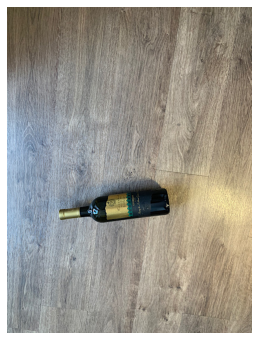

In [36]:
# load and display image
catIds = coco.getCatIds(catNms=['Glass']);
imgIds = coco.getImgIds(catIds=catIds);
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
#img_name = '%s/%s'%(dataDir, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)
plt.axis('off')

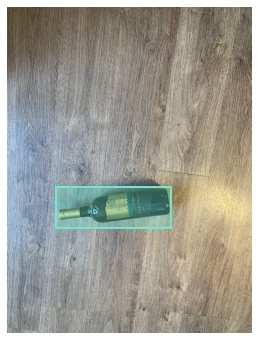

In [37]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

In [38]:
with open(annFile, 'r') as f:
    dataset = json.loads(f.read())

cat_names = [item['name'] for item in dataset['categories'] if item['name']]
trash_categories = dataset['categories']
    
# define variables
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

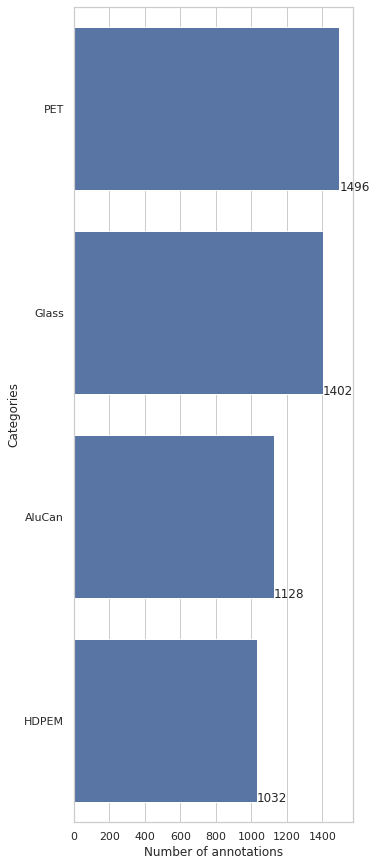

In [39]:
# Count annotations
cat_histogram = np.zeros(len(trash_categories),dtype=int)
for ann in dataset['annotations']:
    cat_histogram[ann['category_id'] - 1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,15))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
sns.set_color_codes("pastel")
sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")
show_values_on_bars(plot_1, "h", 0.3)

In [40]:
def drinkingwaste_to_detectwaste(label):
    metals_and_plastics = ['PET', 'HDPEM', 'AluCan']
    glass = ['Glass']

    if (label in metals_and_plastics):
        label="metals_and_plastics"
    elif(label in glass):
        label="glass"
    else:
        print(label, "is non-drinkingwaste label")
        label = "unknown"
    return label

In [42]:
# convert all taco anns to detect-waste anns
# let's change supercategory to detectwaste
detectwaste_categories = dataset['categories']
for ann in anns:    
    cat_id = ann['category_id']
    cat_drinkingwaste = categories[cat_id-1]['name']
    detectwaste_categories[cat_id-1]['supercategory'] = drinkingwaste_to_detectwaste(cat_drinkingwaste)
# As there is no representation of "Plastified paper bag" in annotated data, change of this supercategory was done manually.
detectwaste_categories

[{'supercategory': 'metals_and_plastics', 'id': 1, 'name': 'AluCan'},
 {'supercategory': 'glass', 'id': 2, 'name': 'Glass'},
 {'supercategory': 'metals_and_plastics', 'id': 3, 'name': 'HDPEM'},
 {'supercategory': 'metals_and_plastics', 'id': 4, 'name': 'PET'}]

In [43]:
detectwaste_ids = {}
detectwaste_cat_names = []
cat_id = 0
for cat in detectwaste_categories:
    if cat['supercategory'] not in detectwaste_ids:
        detectwaste_cat_names.append(cat['supercategory'])
        detectwaste_ids[cat['supercategory']] = cat_id
        cat_id += 1
        


drinkingwaste_to_detectwaste_ids = {}
for i, cat in enumerate(detectwaste_categories):
    drinkingwaste_to_detectwaste_ids[cat['id']] = detectwaste_ids[cat['supercategory']]
    
# print(taco_to_detectwaste_ids)



anns_detectwaste = anns.copy()
for i, ann in enumerate(anns):
    #print(ann['category_id'])
    anns_detectwaste[i]['category_id'] = drinkingwaste_to_detectwaste_ids[ann['category_id']]
    anns_detectwaste[i].pop('segmentation', None)


Text(0.5, 1.0, 'Annotations per detectwaste category')

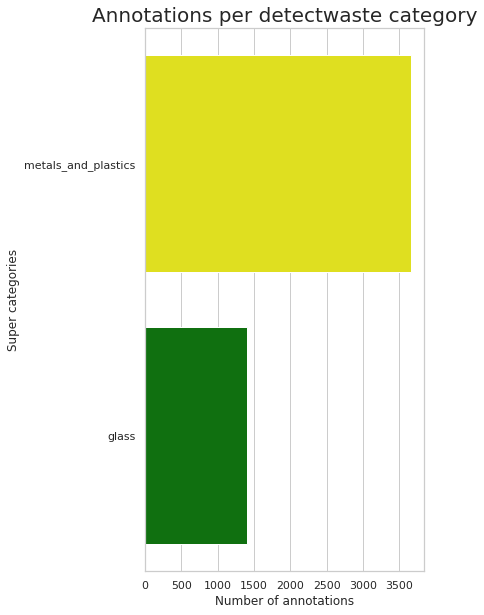

In [44]:
# Count annotations
detectwaste_cat_histogram = np.zeros(len(detectwaste_cat_names),dtype=int)

for ann in anns_detectwaste:
    cat_id = ann['category_id']
    detectwaste_cat_histogram[cat_id] +=1


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,10))

# Convert to DataFrame
d ={'Super categories': detectwaste_cat_names, 'Number of annotations': detectwaste_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)

sup_cat = df.loc[:,'Super categories'].tolist()
colors = [colors_recykling[cat] for cat in sup_cat]

sns.set_palette(sns.color_palette(colors))
plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
            label="Total")
plot_1.set_title('Annotations per detectwaste category',fontsize=20)

### bbox statistics

In [45]:
def bbox_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['bbox'][2] for pic in anns]
    picsh = [pic['bbox'][3] for pic in anns]
    bbox_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(bbox_size)
    if calc == 'median':
        return np.median(bbox_size)

def area_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['area'] for pic in anns]
    picsh = [pic['area'] for pic in anns]
    area_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(area_size)
    if calc == 'median':
        return np.median(area_size)

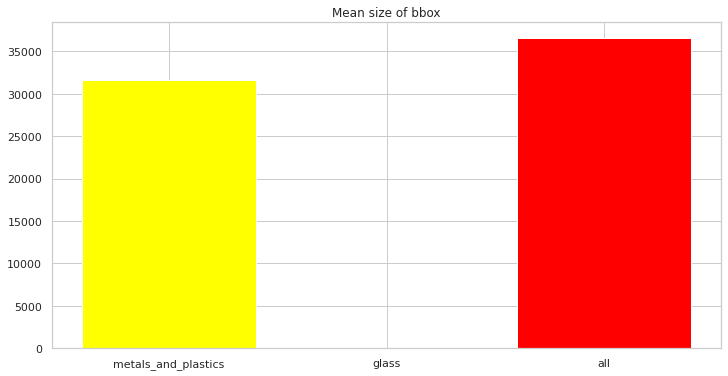

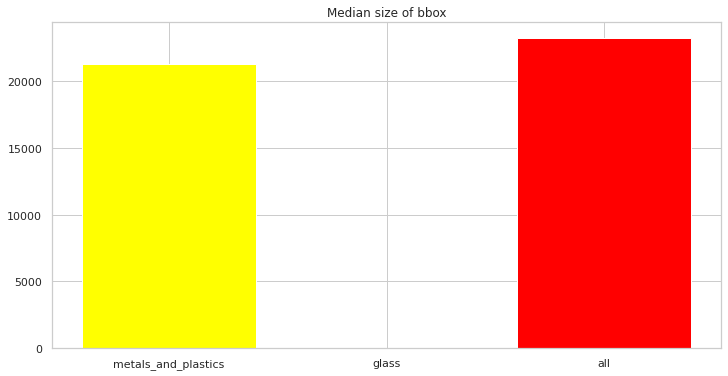

In [46]:
pylab.rcParams['figure.figsize'] = (12,6)

mean_bbox = []
median_bbox = []
for cat_nr, cat in enumerate(detectwaste_cat_names):
    
    temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
    mean_bbox.append(bbox_stats(temp_anns,)) 
    median_bbox.append(bbox_stats(temp_anns,'median'))
mean_bbox[-1] =0
median_bbox[-1] =0


# append stats for all for comparison
temp_detectwaste_cat_names = detectwaste_cat_names.copy()
temp_detectwaste_cat_names.append('all')
mean_bbox.append(bbox_stats(anns_detectwaste)) 
median_bbox.append(bbox_stats(anns_detectwaste,'median'))

colors = [colors_recykling[name] for name in detectwaste_cat_names]
colors.append('red')


plt.bar(temp_detectwaste_cat_names,mean_bbox, color=colors)
plt.title('Mean size of bbox')
plt.show()

plt.bar(temp_detectwaste_cat_names,median_bbox, color=colors)
plt.title('Median size of bbox')
plt.show()

['metals_and_plastics', 'glass', 'all']


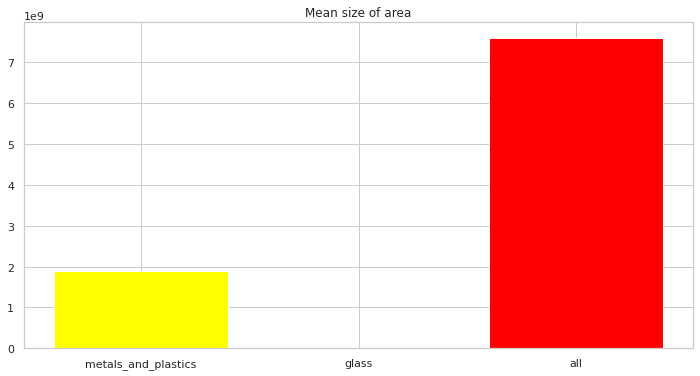

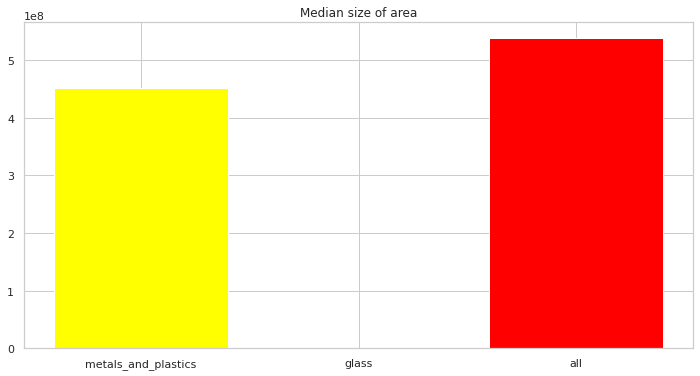

In [47]:
mean_area = []
median_area = []
for cat_nr, cat in enumerate(detectwaste_cat_names):
    temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
    mean_area.append(area_stats(temp_anns,)) 
    median_area.append(area_stats(temp_anns,'median'))

mean_area[-1] = 0
median_area[-1] = 0
mean_area.append(area_stats(anns_detectwaste)) 
median_area.append(area_stats(anns_detectwaste,'median'))
print(temp_detectwaste_cat_names)

plt.bar(temp_detectwaste_cat_names,mean_area, color=colors)
plt.title('Mean size of area')
plt.show()

plt.bar(temp_detectwaste_cat_names,median_area, color=colors)
plt.title('Median size of area')
plt.show()

### Number of bboxes per image

In [48]:
def no_bbox_per_image(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    return np.mean(list_of_duplicates)
def no_bbox_summary(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    print('Maximum bboxes: ',np.max(list_of_duplicates))
    print('Mean number of bboxes: ',np.mean(list_of_duplicates))
    print('Median number of bboxes: ',np.median(list_of_duplicates))


print('all:',no_bbox_per_image(anns_detectwaste))
for cat_nr, cat in enumerate(detectwaste_cat_names):
    try:
        temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
        print('\n', cat)
        no_bbox_summary(temp_anns)
    except:
        continue
    

all: 1.0513406776138017

 metals_and_plastics
Maximum bboxes:  2
Mean number of bboxes:  1.000419639110365
Median number of bboxes:  1.0

 glass
Maximum bboxes:  3
Mean number of bboxes:  1.2058823529411764
Median number of bboxes:  1.0


### Number of images per image shape

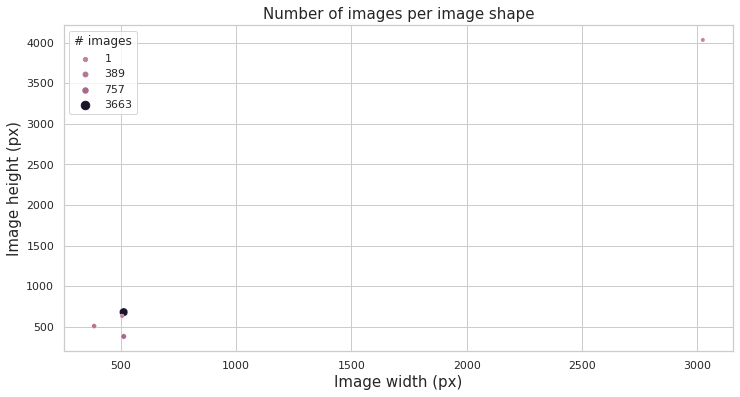

In [49]:
# Parsing image shapes (resolutions)
widths = []
heights = []
shape_freqs = []
img_shapes_keys = {}
for img in dataset['images']:
    key = str(img['width'])+'-'+str(img['height'])
    if key in img_shapes_keys:
        shape_id = img_shapes_keys[key]
        shape_freqs[shape_id] += 1
    else:
        img_shapes_keys[key] = len(widths)
        widths.append(img['width'])
        heights.append(img['height'])
        shape_freqs.append(1)


d ={'Image width (px)': widths, 'Image height (px)': heights, '# images': shape_freqs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
plot = sns.scatterplot(x="Image width (px)", y="Image height (px)", size='# images', hue="# images", palette = cmap,data=df)
plt.xlabel('Image width (px)', fontsize=15)
plt.ylabel('Image height (px)', fontsize=15)
plot = plot.set_title('Number of images per image shape',fontsize=15)

### Placement of central point of the bbox in the image

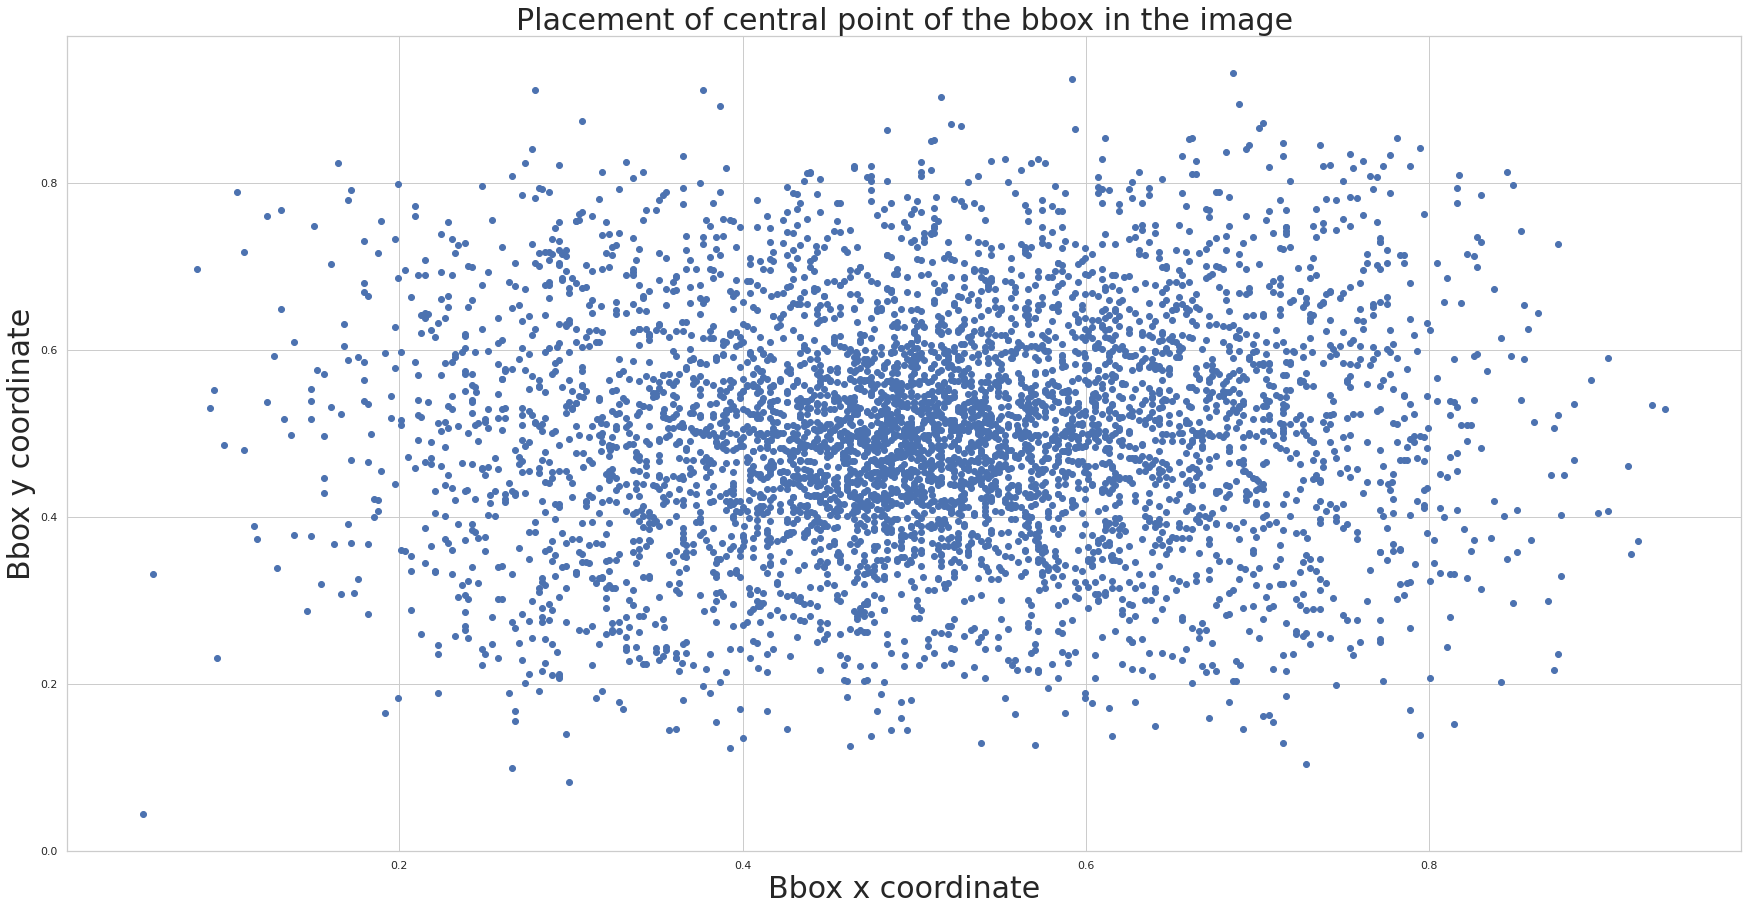

In [50]:
center_x = []
center_y = []
for i in range(0, len(anns_detectwaste)):
    for j in range (0, len(dataset['images'])):
        if dataset['images'][j]['id'] == anns_detectwaste[i]['image_id']:
            
            center_x.append((anns_detectwaste[i]['bbox'][0]+anns_detectwaste[i]['bbox'][2]/2)/dataset['images'][j]['width'])
            center_y.append((anns_detectwaste[i]['bbox'][1]+anns_detectwaste[i]['bbox'][3]/2)/dataset['images'][j]['height'])
plt.figure(figsize=(30,15))
plt.plot(center_x, center_y, 'bo')
plt.title('Placement of central point of the bbox in the image', fontsize=30)
plt.xlabel('Bbox x coordinate', fontsize=30)
plt.ylabel('Bbox y coordinate', fontsize=30)
plt.show()

### Number of annotations per image

/home/zklawikowska/project/env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean number of annotations per image: 1.0513406776138017


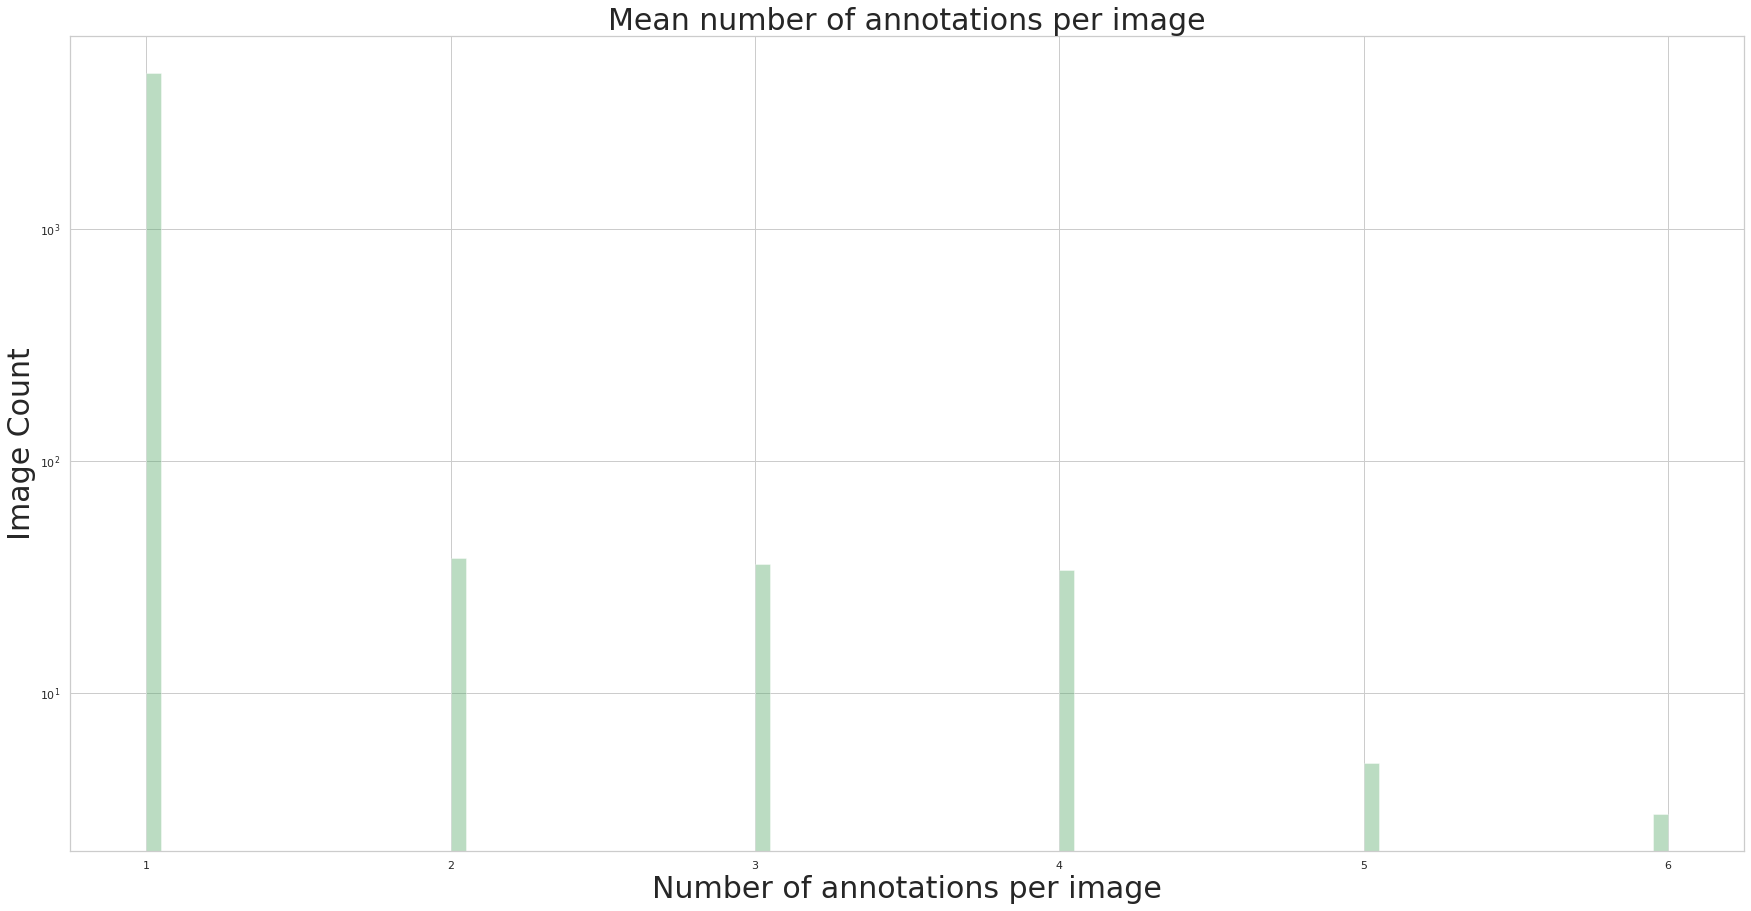

In [53]:
nr_annotation_per_image = []
annotations_per_image = []
for img in dataset['images']:
    annotations_per_image = []
    for i in range(0, len(anns_detectwaste)):
        if img['id'] == anns_detectwaste[i]['image_id']:
            annotations_per_image.append(anns_detectwaste[i]['id'])
    nr_annotation_per_image.append(len(annotations_per_image))

plt.figure(figsize=(30,15))
ax = sns.distplot(nr_annotation_per_image,kde=False,bins=100, color='g')
ax.set_yscale('log')
plt.title('Mean number of annotations per image', fontsize=30)
plt.xlabel('Number of annotations per image', fontsize=30)
plt.ylabel('Image Count', fontsize=30)

print('Mean number of annotations per image:',np.mean(nr_annotation_per_image))

### Bbox size - absolute and relative

According to MS COCO Evaluation. This dataset has:
0 small objects (area<32*32 px)
0 medium objects (area<96*96 px)
32 large objects (area>96*96 px)
Number of bboxes smaller than 1024: 5057
Number of bboxes larger than 1024: 1
Number of missing annotations 8


Text(0.5, 1.0, 'Bounding-boxes size')

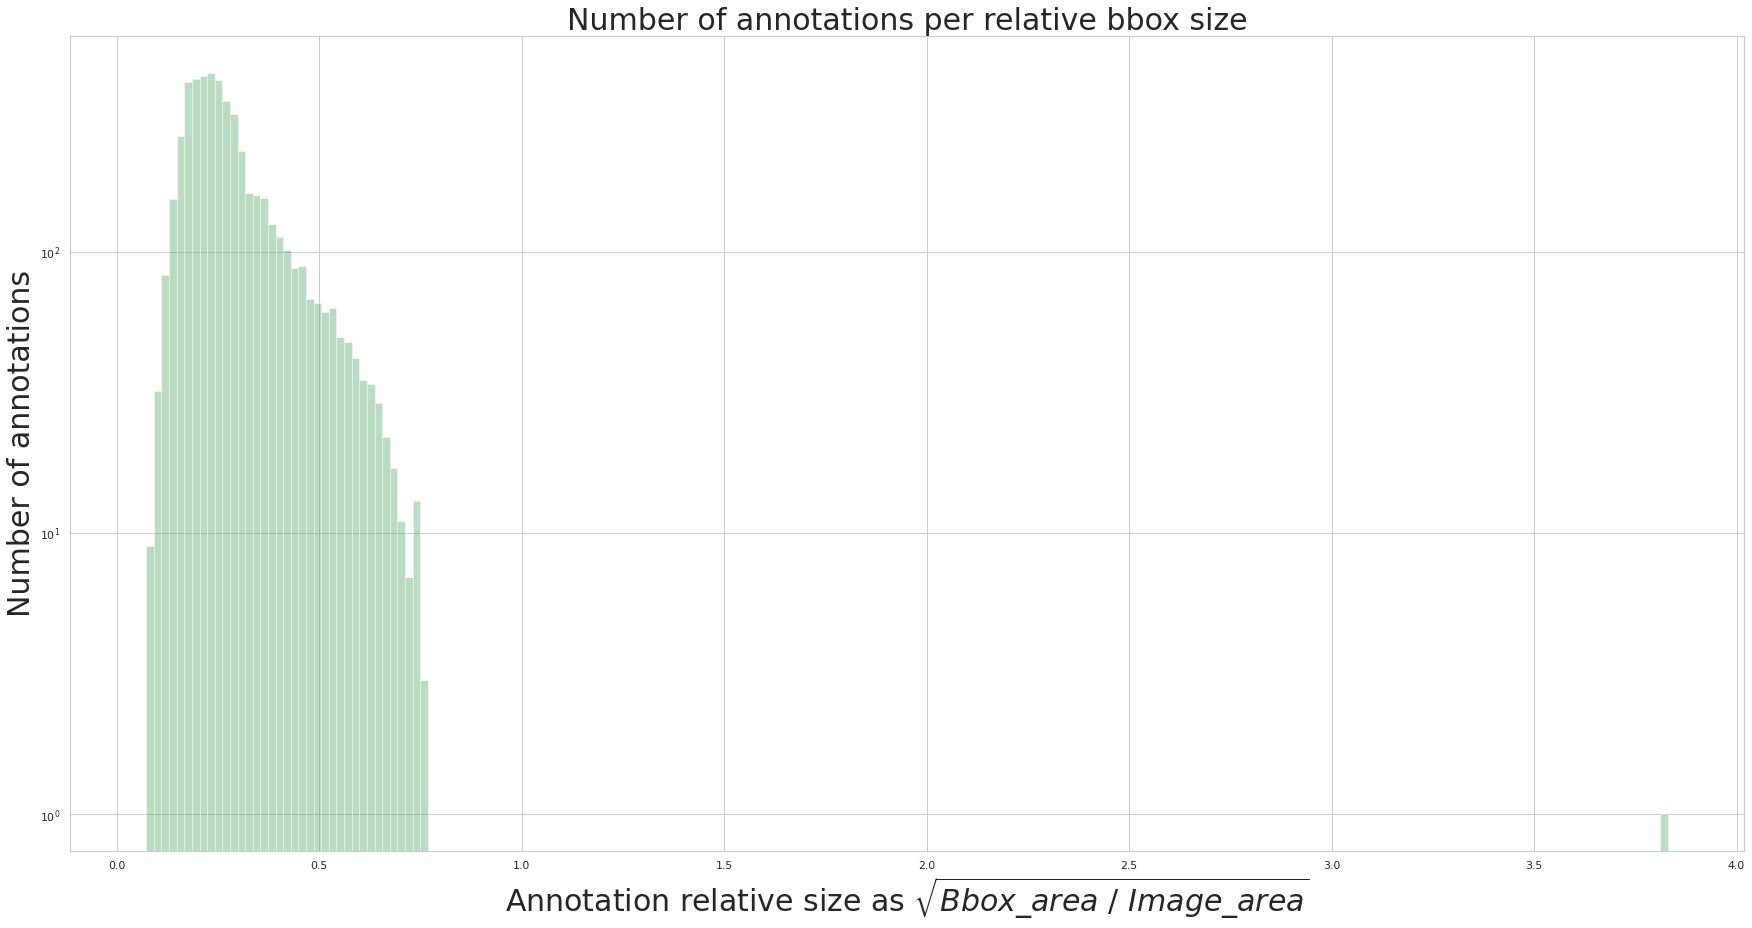

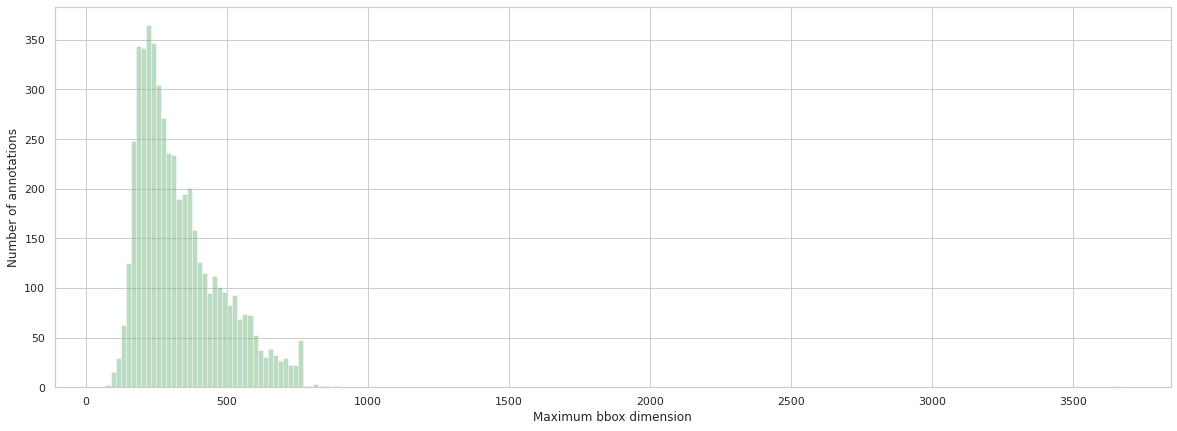

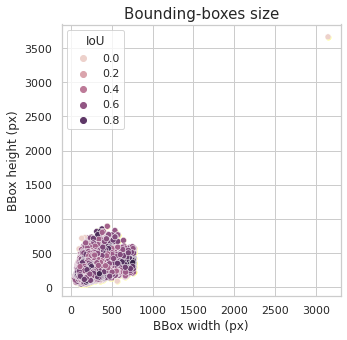

In [54]:
bbox_widths = []
bbox_heights = []
obj_areas_sqrt = []
obj_areas_sqrt_fraction = []
bbox_aspect_ratio = []
max_image_dim = 1024

for ann in anns_detectwaste:
    
    imgs = dataset['images']
    
    resize_scale = max_image_dim/max(imgs[0]['width'], imgs[0]['height'])
    # Uncomment this to work on original image size
#     resize_scale = 1
    
    bbox_widths.append(ann['bbox'][2]*resize_scale)
    bbox_heights.append(ann['bbox'][3]*resize_scale)
    obj_area = ann['bbox'][2]*ann['bbox'][3]*resize_scale**2 # ann['area']
    obj_areas_sqrt.append(np.sqrt(obj_area))
        
    img_area = imgs[0]['width']*imgs[0]['height']*resize_scale**2
    obj_areas_sqrt_fraction.append(np.sqrt(obj_area/img_area))
    

print('According to MS COCO Evaluation. This dataset has:')
print(np.sum(np.array(obj_areas_sqrt)<32), 'small objects (area<32*32 px)')
print(np.sum(np.array(obj_areas_sqrt)<64), 'medium objects (area<96*96 px)')
print(np.sum(np.array(obj_areas_sqrt)<96), 'large objects (area>96*96 px)')
    
# d ={'Bbox width (px)': bbox_widths, 'Bbox height (px)': bbox_heights, 'area': seg_areas}
# df = pd.DataFrame(d)

plt.figure(figsize=(30,15))
ax = sns.distplot(obj_areas_sqrt_fraction,kde=False, bins=200, color='g')
ax.set_yscale('log')
plt.title('Number of annotations per relative bbox size', fontsize=30)
plt.xlabel(r'Annotation relative size as $\sqrt{ Bbox\_area \ /  \ Image\_area}$', fontsize=30)
plt.ylabel('Number of annotations', fontsize=30)

plt.figure(figsize=(20,7))
ax = sns.distplot(np.maximum(np.array(bbox_widths),np.array(bbox_heights)),kde=False, bins=200, color='g')
ax = ax.set(xlabel='Maximum bbox dimension', ylabel='Number of annotations')

import colorsys
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", palette = cmap,data=df)

print('Number of bboxes smaller than 1024:',np.sum(np.array(bbox_widths)<1024))
print('Number of bboxes larger than 1024:',np.sum(np.array(bbox_widths)>1024))

# anchors = [(32,32),(64,64),(128,128),(256,256),(512,512)]
scales, ratios = np.meshgrid(np.array([16,32,64,128,256,512]), np.array([0.5,1,2]))
scales = scales.flatten()
ratios = ratios.flatten()
# Enumerate heights and widths from scales and ratios
anchor_heights = scales / np.sqrt(ratios)
anchor_widths = scales * np.sqrt(ratios)

IoUs = []
for i in range(len(bbox_widths)):
    bbox_area = bbox_widths[i]*bbox_heights[i]
    IoU_max = 0.0
    for j in range(len(anchor_heights)):
        anchor_area = anchor_heights[j]*anchor_widths[j]
        intersection_area = min(anchor_widths[j],bbox_widths[i])*min(anchor_heights[j], bbox_heights[i])
        IoU = intersection_area / (bbox_area + anchor_area - intersection_area)
        if IoU>0.5:
            IoU_max = IoU
    IoUs.append(IoU_max)
    
print('Number of missing annotations', np.sum(np.array(IoUs)==0.0))
  
# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights, 'IoU': IoUs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", hue = 'IoU',data=df)
plt.title('Bounding-boxes size', fontsize=15)

## MJU-Waste v1.0
- background: indoor, in hand
- classes: 1
- comment: such simply background, labolatory
- annotation: instance masks (and depth - RGBD images)

In [55]:
dataDir='/dih4/dih4_2/wimlds/data/mju-waste-v1'
dataType='JPEGImages'
type_ann='all'
annFile='{}/mju-waste/{}.json'.format(dataDir, type_ann)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [56]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(', '.join(nms)))

COCO categories: 
Rubbish

COCO supercategories: 
Waste


Image n°2208
Image name: /dih4/dih4_2/wimlds/data/mju-waste-v1/JPEGImages/2019-12-10_16_21_26-15_color.png


(-0.5, 639.5, 479.5, -0.5)

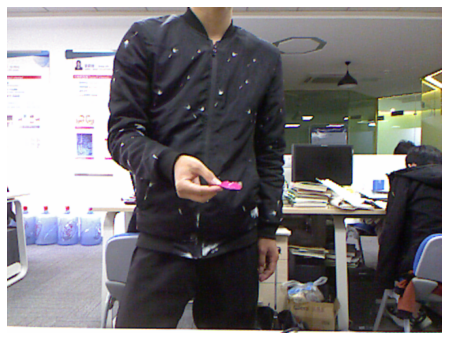

In [57]:
# load and display image
catIds = coco.getCatIds(catNms=['Rubbish']);
imgIds = coco.getImgIds(catIds=catIds);
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
#img_name = '%s/%s'%(dataDir, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)
plt.axis('off')

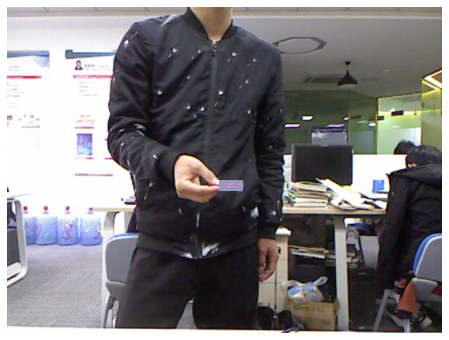

In [59]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

In [60]:
with open(annFile, 'r') as f:
    dataset = json.loads(f.read())

cat_names = [item['name'] for item in dataset['categories'] if item['name']]
trash_categories = dataset['categories']
    
# define variables
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

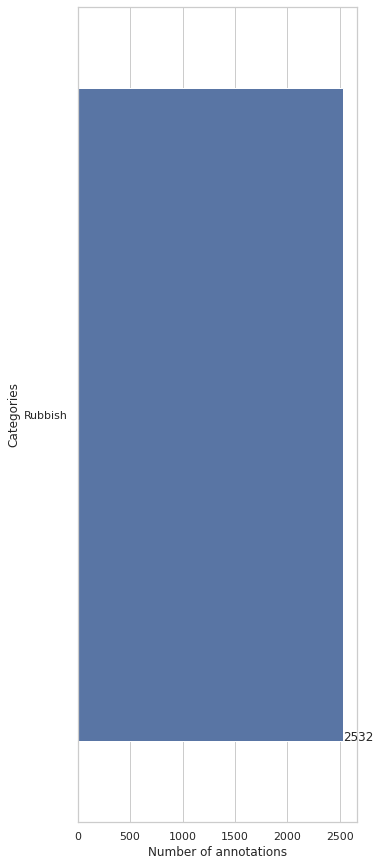

In [61]:
# Count annotations
cat_histogram = np.zeros(len(trash_categories),dtype=int)
for ann in dataset['annotations']:
    cat_histogram[ann['category_id'] - 1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,15))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
sns.set_color_codes("pastel")
sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")
show_values_on_bars(plot_1, "h", 0.3)

In [62]:
print(len(dataset['images']), len([ann for ann in dataset['annotations'] if ann['image_id'] in [i['id'] for i in dataset['images']]]))

2475 2532


In [63]:
def MJUwaste_to_detectwaste(label):    
    return "unknown"

In [64]:
# convert all taco anns to detect-waste anns
# let's change supercategory to detectwaste
detectwaste_categories = dataset['categories']
for ann in anns:    
    cat_id = ann['category_id']
    
    cat_MJUwaste = categories[cat_id-1]['name']
    
    detectwaste_categories[cat_id-1]['supercategory'] = MJUwaste_to_detectwaste(cat_MJUwaste)
# # As there is no representation of "Plastified paper bag" in annotated data, change of this supercategory was done manually.
detectwaste_categories

[{'id': 1, 'name': 'Rubbish', 'supercategory': 'unknown'}]

In [65]:
detectwaste_ids = {}
detectwaste_cat_names = []
cat_id = 0
for cat in detectwaste_categories:
    if cat['supercategory'] not in detectwaste_ids:
        detectwaste_cat_names.append(cat['supercategory'])
        detectwaste_ids[cat['supercategory']] = cat_id
        cat_id += 1
        


MJUwaste_to_detectwaste_ids = {}
for i, cat in enumerate(detectwaste_categories):
    MJUwaste_to_detectwaste_ids[cat['id']] = detectwaste_ids[cat['supercategory']]
    
# print(taco_to_detectwaste_ids)



anns_detectwaste = anns.copy()
for i, ann in enumerate(anns):
    #print(ann['category_id'])
    anns_detectwaste[i]['category_id'] = MJUwaste_to_detectwaste_ids[ann['category_id']]
    anns_detectwaste[i].pop('segmentation', None)


Text(0.5, 1.0, 'Annotations per detectwaste category')

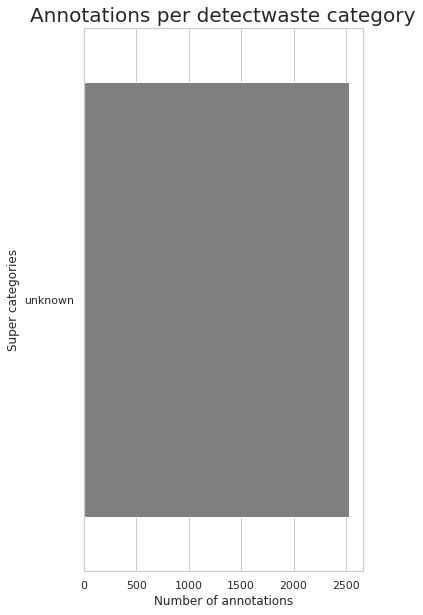

In [66]:
# Count annotations
detectwaste_cat_histogram = np.zeros(len(detectwaste_cat_names),dtype=int)

for ann in anns_detectwaste:
    cat_id = ann['category_id']
    detectwaste_cat_histogram[cat_id] +=1


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,10))

# Convert to DataFrame
d ={'Super categories': detectwaste_cat_names, 'Number of annotations': detectwaste_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)

sup_cat = df.loc[:,'Super categories'].tolist()
colors = [colors_recykling[cat] for cat in sup_cat]

sns.set_palette(sns.color_palette(colors))
plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
            label="Total")
plot_1.set_title('Annotations per detectwaste category',fontsize=20)

### bbox statistics

In [67]:
def bbox_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['bbox'][2] for pic in anns]
    picsh = [pic['bbox'][3] for pic in anns]
    bbox_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(bbox_size)
    if calc == 'median':
        return np.median(bbox_size)

def area_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['area'] for pic in anns]
    picsh = [pic['area'] for pic in anns]
    area_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(area_size)
    if calc == 'median':
        return np.median(area_size)

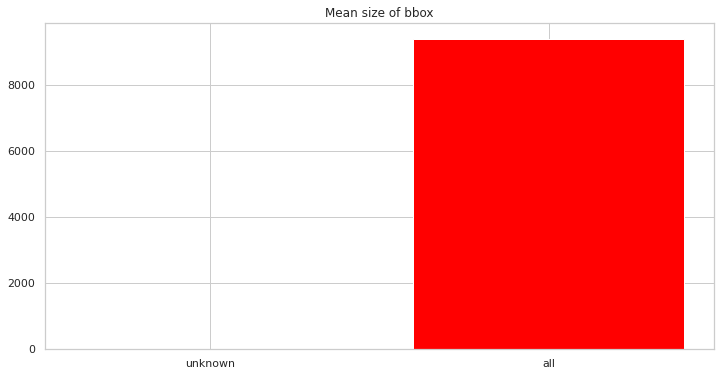

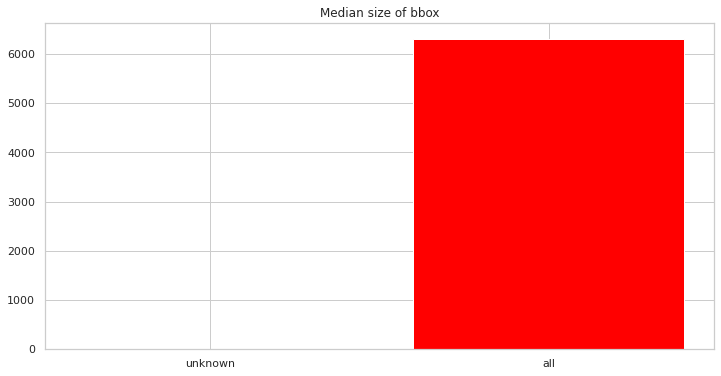

In [68]:
pylab.rcParams['figure.figsize'] = (12,6)

mean_bbox = []
median_bbox = []
for cat_nr, cat in enumerate(detectwaste_cat_names):
    
    temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
    mean_bbox.append(bbox_stats(temp_anns,)) 
    median_bbox.append(bbox_stats(temp_anns,'median'))
mean_bbox[-1] =0
median_bbox[-1] =0


# append stats for all for comparison
temp_detectwaste_cat_names = detectwaste_cat_names.copy()
temp_detectwaste_cat_names.append('all')
mean_bbox.append(bbox_stats(anns_detectwaste)) 
median_bbox.append(bbox_stats(anns_detectwaste,'median'))

colors = [colors_recykling[name] for name in detectwaste_cat_names]
colors.append('red')


plt.bar(temp_detectwaste_cat_names,mean_bbox, color=colors)
plt.title('Mean size of bbox')
plt.show()

plt.bar(temp_detectwaste_cat_names,median_bbox, color=colors)
plt.title('Median size of bbox')
plt.show()


['unknown', 'all']


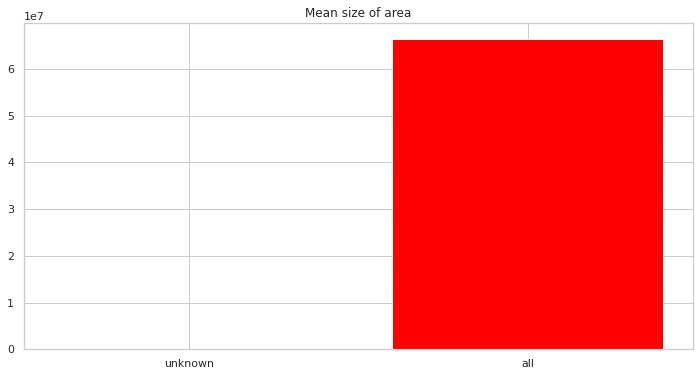

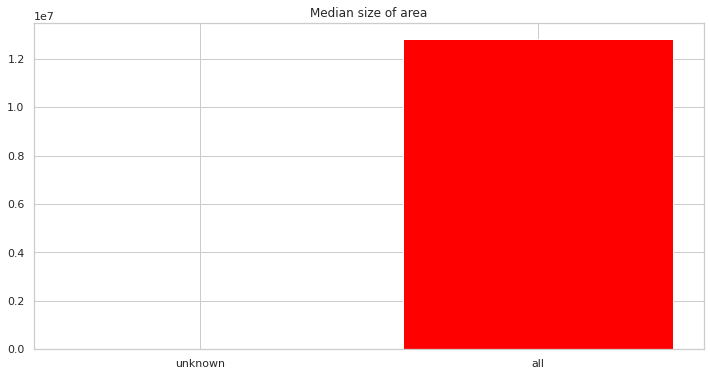

In [69]:
mean_area = []
median_area = []
for cat_nr, cat in enumerate(detectwaste_cat_names):
    temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
    mean_area.append(area_stats(temp_anns,)) 
    median_area.append(area_stats(temp_anns,'median'))

mean_area[-1] = 0
median_area[-1] = 0
mean_area.append(area_stats(anns_detectwaste)) 
median_area.append(area_stats(anns_detectwaste,'median'))
print(temp_detectwaste_cat_names)

plt.bar(temp_detectwaste_cat_names,mean_area, color=colors)
plt.title('Mean size of area')
plt.show()

plt.bar(temp_detectwaste_cat_names,median_area, color=colors)
plt.title('Median size of area')
plt.show()

### Number of bboxes per image

In [70]:
def no_bbox_per_image(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    return np.mean(list_of_duplicates)
def no_bbox_summary(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    print('Maximum bboxes: ',np.max(list_of_duplicates))
    print('Mean number of bboxes: ',np.mean(list_of_duplicates))
    print('Median number of bboxes: ',np.median(list_of_duplicates))


print('all:',no_bbox_per_image(anns_detectwaste))
for cat_nr, cat in enumerate(detectwaste_cat_names):
    try:
        temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
        print('\n', cat)
        no_bbox_summary(temp_anns)
    except:
        continue
    

all: 1.0281263522284725

 unknown
Maximum bboxes:  5
Mean number of bboxes:  1.0281263522284725
Median number of bboxes:  1.0


### Number of images per image shape

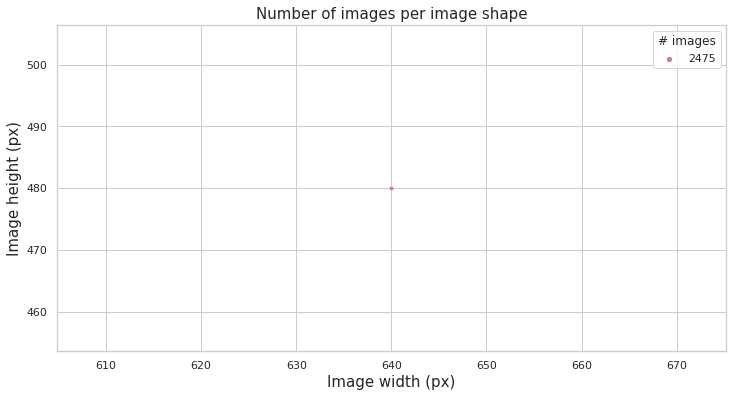

In [71]:
# Parsing image shapes (resolutions)
widths = []
heights = []
shape_freqs = []
img_shapes_keys = {}
for img in dataset['images']:
    key = str(img['width'])+'-'+str(img['height'])
    if key in img_shapes_keys:
        shape_id = img_shapes_keys[key]
        shape_freqs[shape_id] += 1
    else:
        img_shapes_keys[key] = len(widths)
        widths.append(img['width'])
        heights.append(img['height'])
        shape_freqs.append(1)


d ={'Image width (px)': widths, 'Image height (px)': heights, '# images': shape_freqs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
plot = sns.scatterplot(x="Image width (px)", y="Image height (px)", size='# images', hue="# images", palette = cmap,data=df)
plt.xlabel('Image width (px)', fontsize=15)
plt.ylabel('Image height (px)', fontsize=15)
plot = plot.set_title('Number of images per image shape',fontsize=15)

### Placement of central point of the bbox in the image

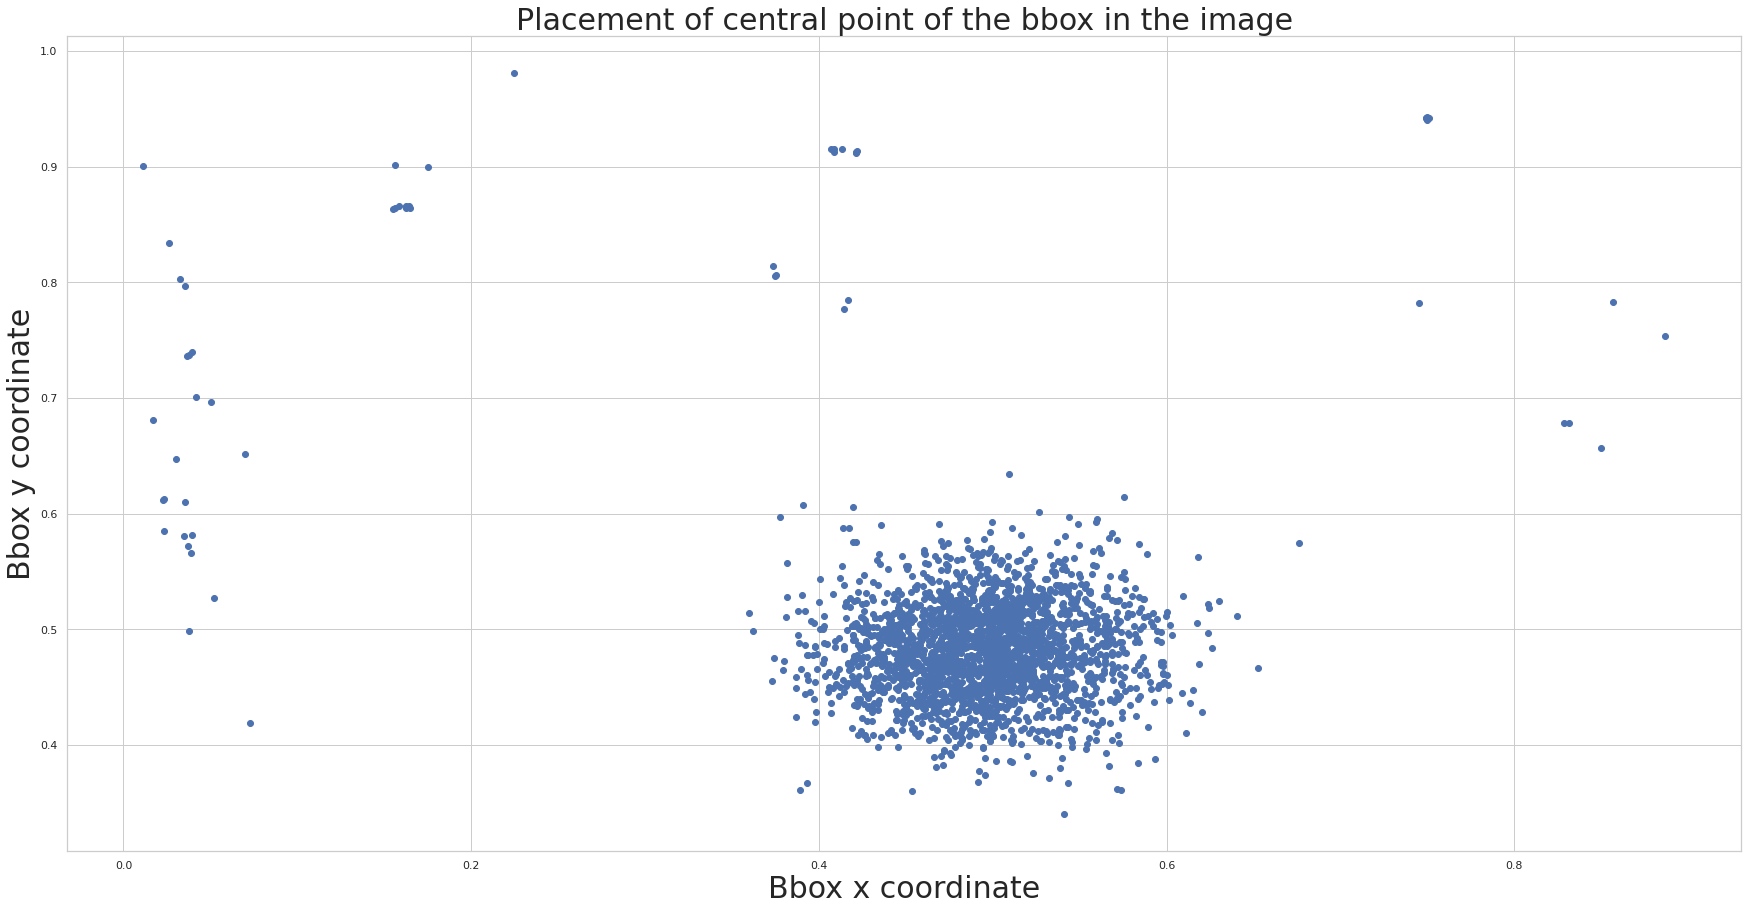

In [72]:
center_x = []
center_y = []
for i in range(0, len(anns_detectwaste)):
    for j in range (0, len(dataset['images'])):
        if dataset['images'][j]['id'] == anns_detectwaste[i]['image_id']:
            
            center_x.append((anns_detectwaste[i]['bbox'][0]+anns_detectwaste[i]['bbox'][2]/2)/dataset['images'][j]['width'])
            center_y.append((anns_detectwaste[i]['bbox'][1]+anns_detectwaste[i]['bbox'][3]/2)/dataset['images'][j]['height'])
plt.figure(figsize=(30,15))
plt.plot(center_x, center_y, 'bo')
plt.title('Placement of central point of the bbox in the image', fontsize=30)
plt.xlabel('Bbox x coordinate', fontsize=30)
plt.ylabel('Bbox y coordinate', fontsize=30)
plt.show()

### Number of annotations per image

/home/zklawikowska/project/env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean number of annotations per image: 1.023030303030303


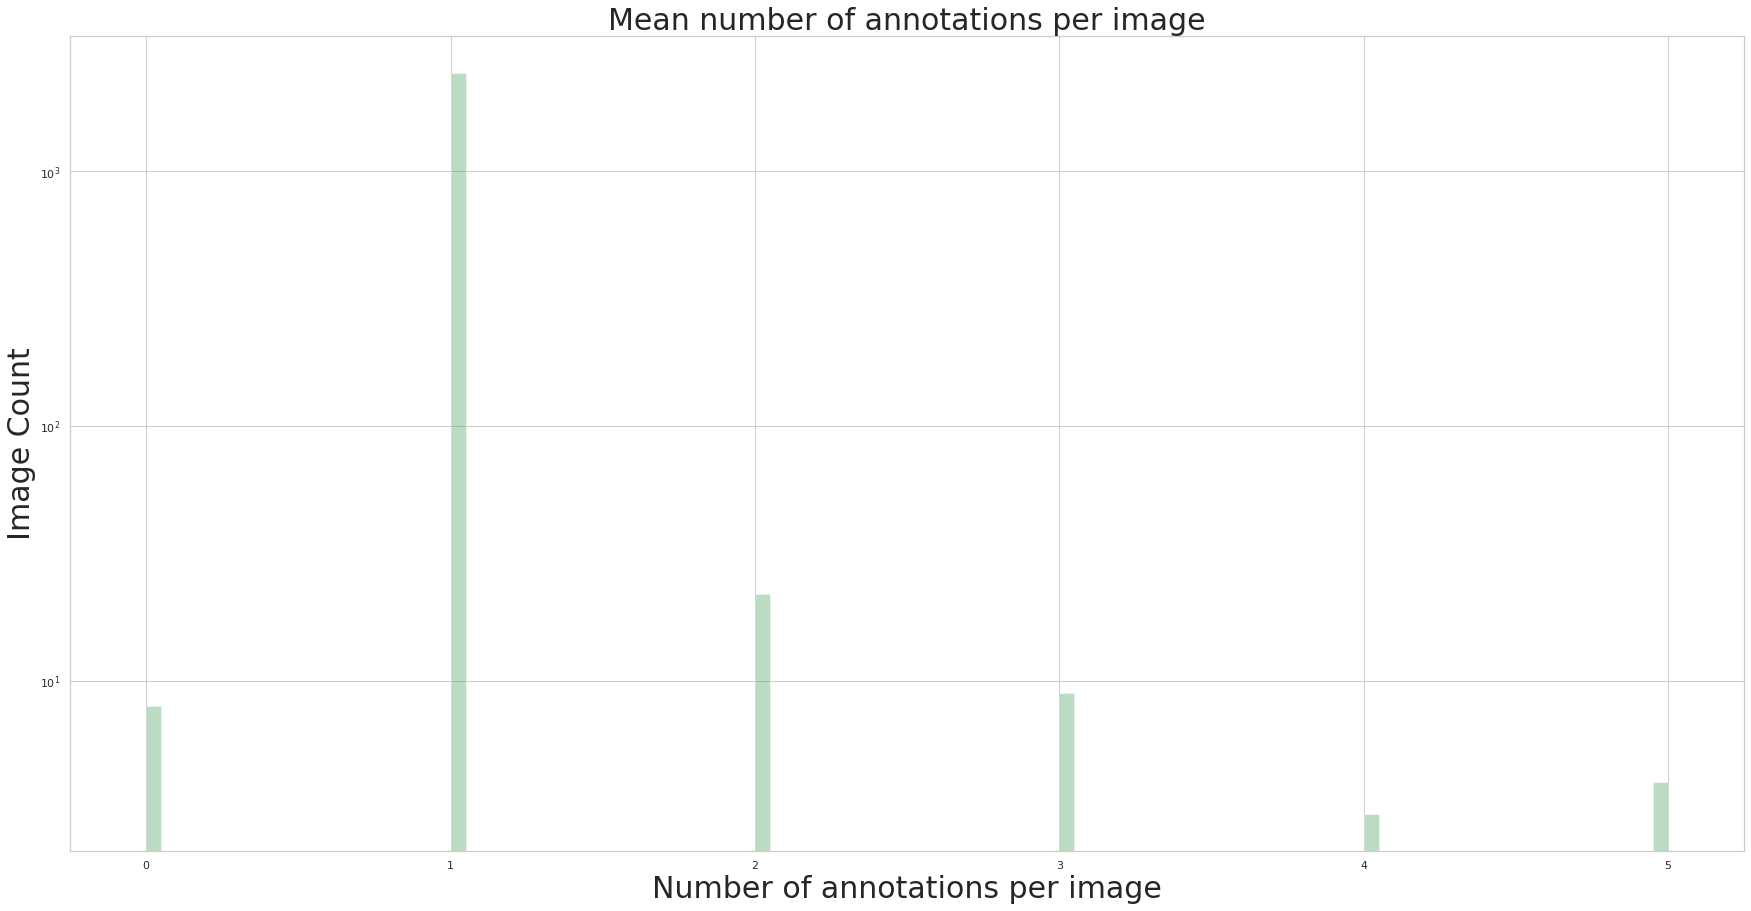

In [73]:
nr_annotation_per_image = []
annotations_per_image = []
for img in dataset['images']:
    annotations_per_image = []
    for i in range(0, len(anns_detectwaste)):
        if img['id'] == anns_detectwaste[i]['image_id']:
            annotations_per_image.append(anns_detectwaste[i]['id'])
    nr_annotation_per_image.append(len(annotations_per_image))

plt.figure(figsize=(30,15))
ax = sns.distplot(nr_annotation_per_image,kde=False,bins=100, color='g')
ax.set_yscale('log')
plt.title('Mean number of annotations per image', fontsize=30)
plt.xlabel('Number of annotations per image', fontsize=30)
plt.ylabel('Image Count', fontsize=30)

print('Mean number of annotations per image:',np.mean(nr_annotation_per_image))

### Bbox size - absolute and relative

According to MS COCO Evaluation. This dataset has:
4 small objects (area<32*32 px)
152 medium objects (area<96*96 px)
707 large objects (area>96*96 px)
Number of bboxes smaller than 1024: 2532
Number of bboxes larger than 1024: 0
Number of missing annotations 35


Text(0.5, 1.0, 'Bounding-boxes size')

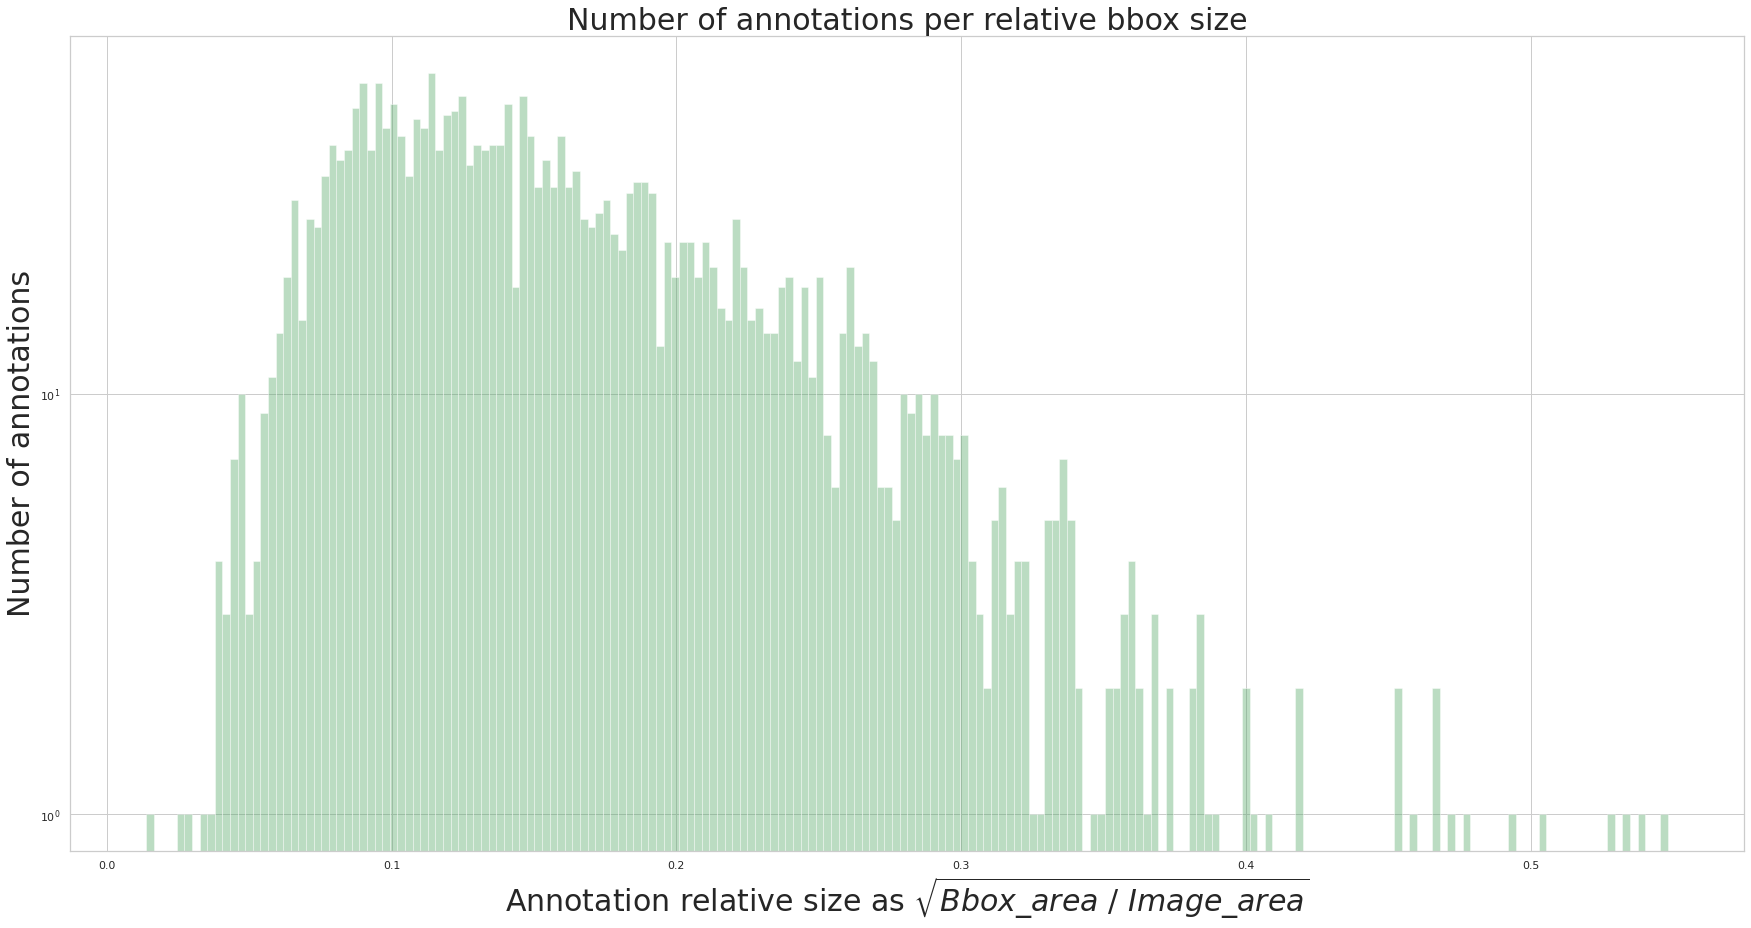

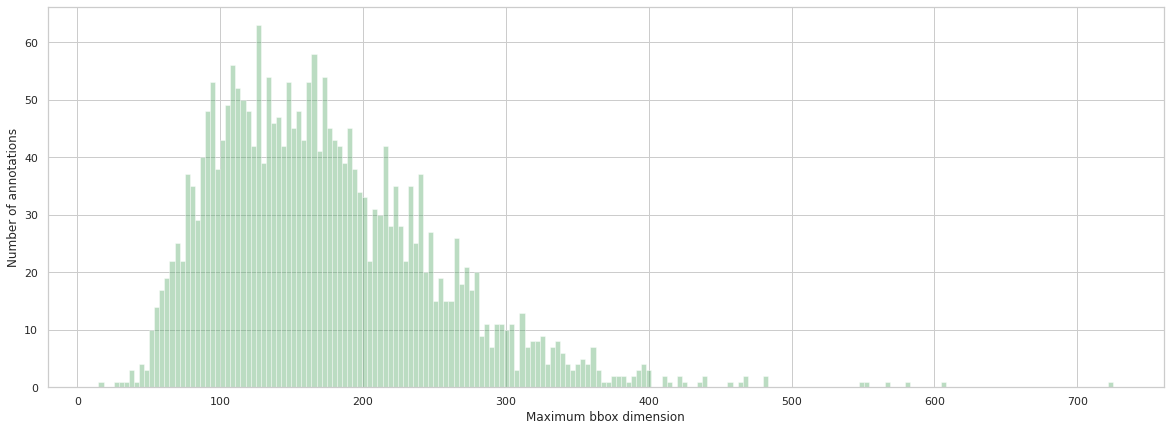

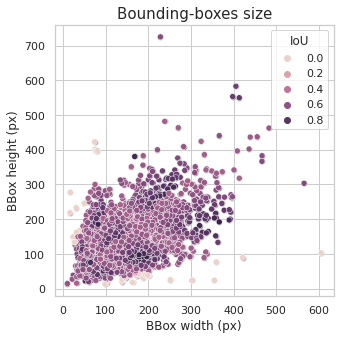

In [74]:
bbox_widths = []
bbox_heights = []
obj_areas_sqrt = []
obj_areas_sqrt_fraction = []
bbox_aspect_ratio = []
max_image_dim = 1024

for ann in anns_detectwaste:
    
    imgs = dataset['images']
    
    resize_scale = max_image_dim/max(imgs[0]['width'], imgs[0]['height'])
    # Uncomment this to work on original image size
#     resize_scale = 1
    
    bbox_widths.append(ann['bbox'][2]*resize_scale)
    bbox_heights.append(ann['bbox'][3]*resize_scale)
    obj_area = ann['bbox'][2]*ann['bbox'][3]*resize_scale**2 # ann['area']
    obj_areas_sqrt.append(np.sqrt(obj_area))
        
    img_area = imgs[0]['width']*imgs[0]['height']*resize_scale**2
    obj_areas_sqrt_fraction.append(np.sqrt(obj_area/img_area))
    

print('According to MS COCO Evaluation. This dataset has:')
print(np.sum(np.array(obj_areas_sqrt)<32), 'small objects (area<32*32 px)')
print(np.sum(np.array(obj_areas_sqrt)<64), 'medium objects (area<96*96 px)')
print(np.sum(np.array(obj_areas_sqrt)<96), 'large objects (area>96*96 px)')
    
# d ={'Bbox width (px)': bbox_widths, 'Bbox height (px)': bbox_heights, 'area': seg_areas}
# df = pd.DataFrame(d)

plt.figure(figsize=(30,15))
ax = sns.distplot(obj_areas_sqrt_fraction,kde=False, bins=200, color='g')
ax.set_yscale('log')
plt.title('Number of annotations per relative bbox size', fontsize=30)
plt.xlabel(r'Annotation relative size as $\sqrt{ Bbox\_area \ /  \ Image\_area}$', fontsize=30)
plt.ylabel('Number of annotations', fontsize=30)

plt.figure(figsize=(20,7))
ax = sns.distplot(np.maximum(np.array(bbox_widths),np.array(bbox_heights)),kde=False, bins=200, color='g')
ax = ax.set(xlabel='Maximum bbox dimension', ylabel='Number of annotations')

import colorsys
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", palette = cmap,data=df)

print('Number of bboxes smaller than 1024:',np.sum(np.array(bbox_widths)<1024))
print('Number of bboxes larger than 1024:',np.sum(np.array(bbox_widths)>1024))

# anchors = [(32,32),(64,64),(128,128),(256,256),(512,512)]
scales, ratios = np.meshgrid(np.array([16,32,64,128,256,512]), np.array([0.5,1,2]))
scales = scales.flatten()
ratios = ratios.flatten()
# Enumerate heights and widths from scales and ratios
anchor_heights = scales / np.sqrt(ratios)
anchor_widths = scales * np.sqrt(ratios)

IoUs = []
for i in range(len(bbox_widths)):
    bbox_area = bbox_widths[i]*bbox_heights[i]
    IoU_max = 0.0
    for j in range(len(anchor_heights)):
        anchor_area = anchor_heights[j]*anchor_widths[j]
        intersection_area = min(anchor_widths[j],bbox_widths[i])*min(anchor_heights[j], bbox_heights[i])
        IoU = intersection_area / (bbox_area + anchor_area - intersection_area)
        if IoU>0.5:
            IoU_max = IoU
    IoUs.append(IoU_max)
    
print('Number of missing annotations', np.sum(np.array(IoUs)==0.0))
  
# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights, 'IoU': IoUs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", hue = 'IoU',data=df)
plt.title('Bounding-boxes size', fontsize=15)

## wade-ai
- background: outside, google maps
- classes: 1
- comment: roads and pavements
- annotation: instance masks

In [75]:
dataDir='/dih4/dih4_2/wimlds/data/wade-ai'
dataType='wade-ai_images'
type_ann='all'
annFile='{}/{}_wade_ai.json'.format(dataDir, type_ann)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


In [76]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(', '.join(nms)))

COCO categories: 
Rubbish

COCO supercategories: 
Waste


Image n°823
Image name: /dih4/dih4_2/wimlds/data/wade-ai/wade-ai_images/1511.jpg


(-0.5, 639.5, 639.5, -0.5)

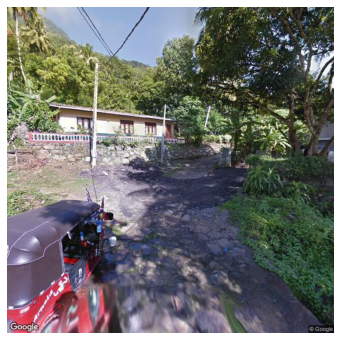

In [77]:
# load and display image
catIds = coco.getCatIds(catNms=['Rubbish']);
imgIds = coco.getImgIds(catIds=catIds);
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
#img_name = '%s/%s'%(dataDir, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)
plt.axis('off')

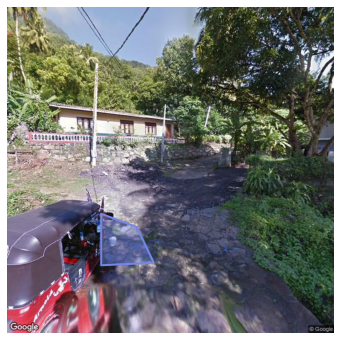

In [78]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)#, draw_bbox=True)

In [79]:
with open(annFile, 'r') as f:
    dataset = json.loads(f.read())

cat_names = [item['name'] for item in dataset['categories'] if item['name']]
trash_categories = dataset['categories']
    
# define variables
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

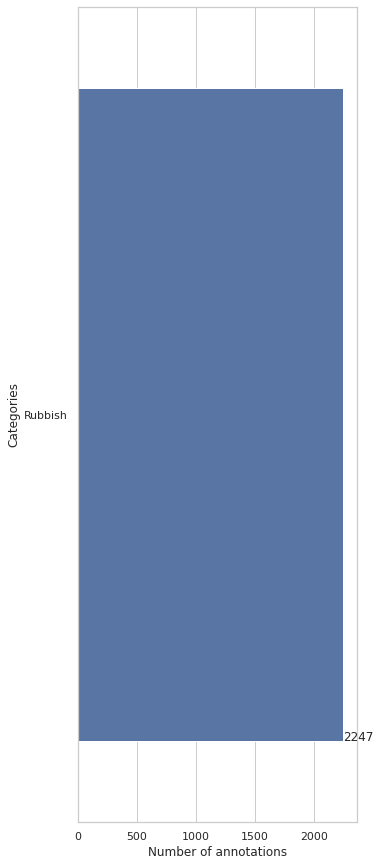

In [80]:
# Count annotations
cat_histogram = np.zeros(len(trash_categories),dtype=int)
for ann in dataset['annotations']:
    ann['category_id'] = 1
    cat_histogram[ann['category_id'] - 1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,15))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
sns.set_color_codes("pastel")
sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")
show_values_on_bars(plot_1, "h", 0.3)

In [81]:
print(len(dataset['images']), len([ann for ann in dataset['annotations'] if ann['image_id'] in [i['id'] for i in dataset['images']]]))

1396 2247


In [82]:
def wadeai_to_detectwaste(label):    
    return "unknown"

In [83]:
# convert all taco anns to detect-waste anns
# let's change supercategory to detectwaste
detectwaste_categories = dataset['categories']
for ann in anns:    
    cat_id = ann['category_id']
    
    cat_wadeai = categories[cat_id-1]['name']
    
    detectwaste_categories[cat_id-1]['supercategory'] = wadeai_to_detectwaste(cat_wadeai)
# # As there is no representation of "Plastified paper bag" in annotated data, change of this supercategory was done manually.
detectwaste_categories

[{'id': 1, 'name': 'Rubbish', 'supercategory': 'unknown'}]

In [84]:
detectwaste_ids = {}
detectwaste_cat_names = []
cat_id = 0
for cat in detectwaste_categories:
    if cat['supercategory'] not in detectwaste_ids:
        detectwaste_cat_names.append(cat['supercategory'])
        detectwaste_ids[cat['supercategory']] = cat_id
        cat_id += 1
        


wadeai_to_detectwaste_ids = {}
for i, cat in enumerate(detectwaste_categories):
    wadeai_to_detectwaste_ids[cat['id']] = detectwaste_ids[cat['supercategory']]
    
# print(taco_to_detectwaste_ids)



anns_detectwaste = anns.copy()
for i, ann in enumerate(anns):
    #print(ann['category_id'])
    anns_detectwaste[i]['category_id'] = wadeai_to_detectwaste_ids[ann['category_id']]
    anns_detectwaste[i].pop('segmentation', None)


Text(0.5, 1.0, 'Annotations per detectwaste category')

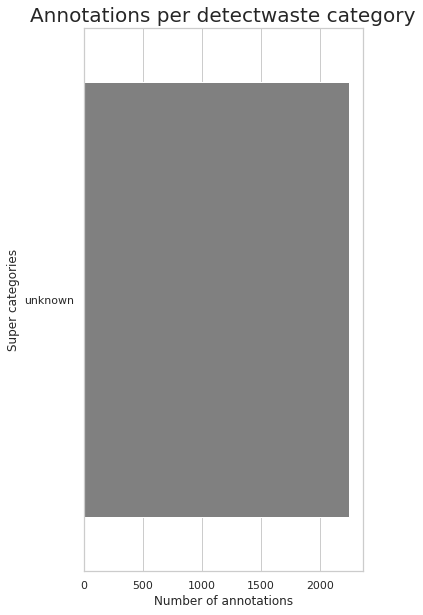

In [85]:
# Count annotations
detectwaste_cat_histogram = np.zeros(len(detectwaste_cat_names),dtype=int)

for ann in anns_detectwaste:
    cat_id = ann['category_id']
    detectwaste_cat_histogram[cat_id] +=1


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,10))

# Convert to DataFrame
d ={'Super categories': detectwaste_cat_names, 'Number of annotations': detectwaste_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)

sup_cat = df.loc[:,'Super categories'].tolist()
colors = [colors_recykling[cat] for cat in sup_cat]

sns.set_palette(sns.color_palette(colors))
plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
            label="Total")
plot_1.set_title('Annotations per detectwaste category',fontsize=20)

### bbox statistics

In [86]:
def bbox_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['bbox'][2] for pic in anns]
    picsh = [pic['bbox'][3] for pic in anns]
    bbox_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(bbox_size)
    if calc == 'median':
        return np.median(bbox_size)

def area_stats(anns, calc = 'mean', verbose = 1):
    picsw = [pic['area'] for pic in anns]
    picsh = [pic['area'] for pic in anns]
    area_size = [w * h for w, h, in zip(picsw,picsh)]
    if calc == 'mean':
        return np.mean(area_size)
    if calc == 'median':
        return np.median(area_size)

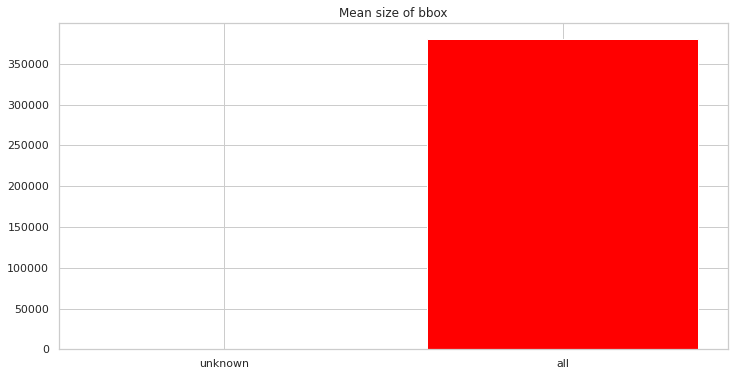

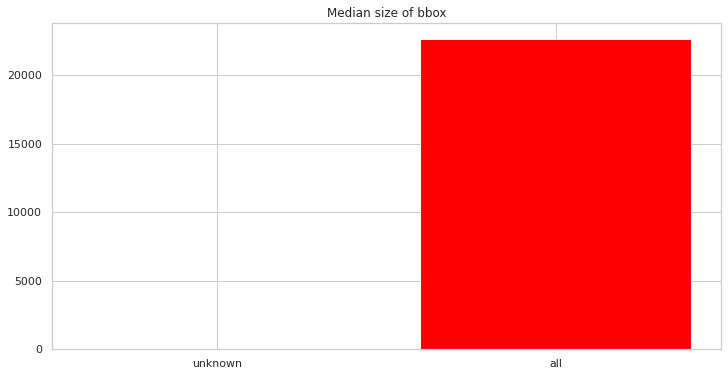

In [87]:
pylab.rcParams['figure.figsize'] = (12,6)

mean_bbox = []
median_bbox = []
for cat_nr, cat in enumerate(detectwaste_cat_names):
    
    temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
    mean_bbox.append(bbox_stats(temp_anns,)) 
    median_bbox.append(bbox_stats(temp_anns,'median'))
mean_bbox[-1] =0
median_bbox[-1] =0


# append stats for all for comparison
temp_detectwaste_cat_names = detectwaste_cat_names.copy()
temp_detectwaste_cat_names.append('all')
mean_bbox.append(bbox_stats(anns_detectwaste)) 
median_bbox.append(bbox_stats(anns_detectwaste,'median'))

colors = [colors_recykling[name] for name in detectwaste_cat_names]
colors.append('red')


plt.bar(temp_detectwaste_cat_names,mean_bbox, color=colors)
plt.title('Mean size of bbox')
plt.show()

plt.bar(temp_detectwaste_cat_names,median_bbox, color=colors)
plt.title('Median size of bbox')
plt.show()


['unknown', 'all']


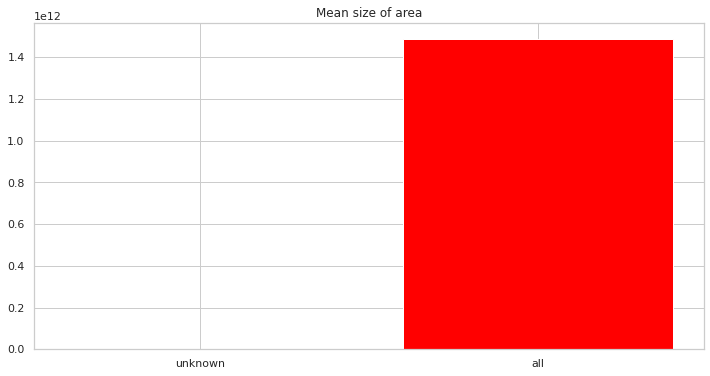

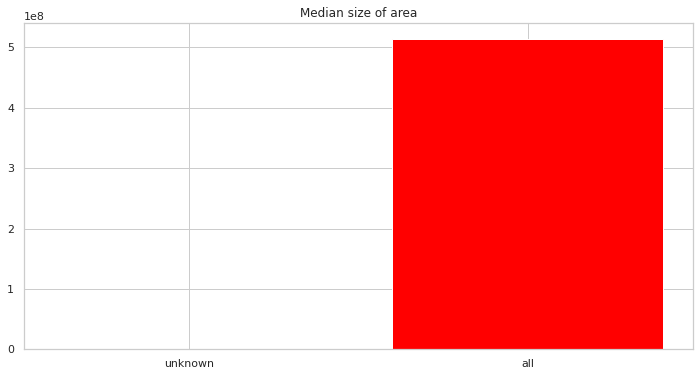

In [94]:
mean_area = []
median_area = []
for cat_nr, cat in enumerate(detectwaste_cat_names):
    temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
    mean_area.append(area_stats(temp_anns,)) 
    median_area.append(area_stats(temp_anns,'median'))

mean_area[-1] = 0
median_area[-1] = 0
mean_area.append(area_stats(anns_detectwaste)) 
median_area.append(area_stats(anns_detectwaste,'median'))
print(temp_detectwaste_cat_names)

plt.bar(temp_detectwaste_cat_names,mean_area, color=colors)
plt.title('Mean size of area')
plt.show()

plt.bar(temp_detectwaste_cat_names,median_area, color=colors)
plt.title('Median size of area')
plt.show()

### Number of bboxes per image

In [89]:
def no_bbox_per_image(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    return np.mean(list_of_duplicates)
def no_bbox_summary(anns):
    temo_im_ids = ([ann['image_id'] for ann in anns])
    temp_im_ids = Counter(temo_im_ids)
    list_of_duplicates = [temp_im_ids[i] for i,im_id in enumerate(temp_im_ids)]
    list_of_duplicates = list(filter(lambda duplicate: duplicate != 0, list_of_duplicates))
    print('Maximum bboxes: ',np.max(list_of_duplicates))
    print('Mean number of bboxes: ',np.mean(list_of_duplicates))
    print('Median number of bboxes: ',np.median(list_of_duplicates))


print('all:',no_bbox_per_image(anns_detectwaste))
for cat_nr, cat in enumerate(detectwaste_cat_names):
    try:
        temp_anns = [ann for ann in anns_detectwaste if(ann['category_id'] == cat_nr)]
        print('\n', cat)
        no_bbox_summary(temp_anns)
    except:
        continue
    

all: 2.2093333333333334

 unknown
Maximum bboxes:  37
Mean number of bboxes:  2.2093333333333334
Median number of bboxes:  1.0


### Number of images per image shape

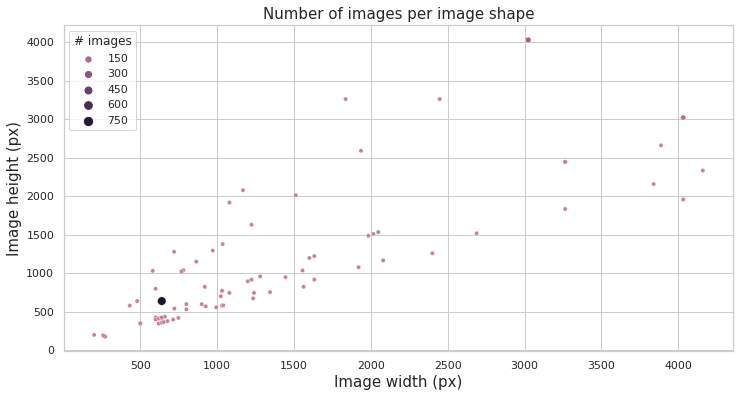

In [90]:
# Parsing image shapes (resolutions)
widths = []
heights = []
shape_freqs = []
img_shapes_keys = {}
for img in dataset['images']:
    key = str(img['width'])+'-'+str(img['height'])
    if key in img_shapes_keys:
        shape_id = img_shapes_keys[key]
        shape_freqs[shape_id] += 1
    else:
        img_shapes_keys[key] = len(widths)
        widths.append(img['width'])
        heights.append(img['height'])
        shape_freqs.append(1)


d ={'Image width (px)': widths, 'Image height (px)': heights, '# images': shape_freqs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
plot = sns.scatterplot(x="Image width (px)", y="Image height (px)", size='# images', hue="# images", palette = cmap,data=df)
plt.xlabel('Image width (px)', fontsize=15)
plt.ylabel('Image height (px)', fontsize=15)
plot = plot.set_title('Number of images per image shape',fontsize=15)

### Placement of central point of the bbox in the image

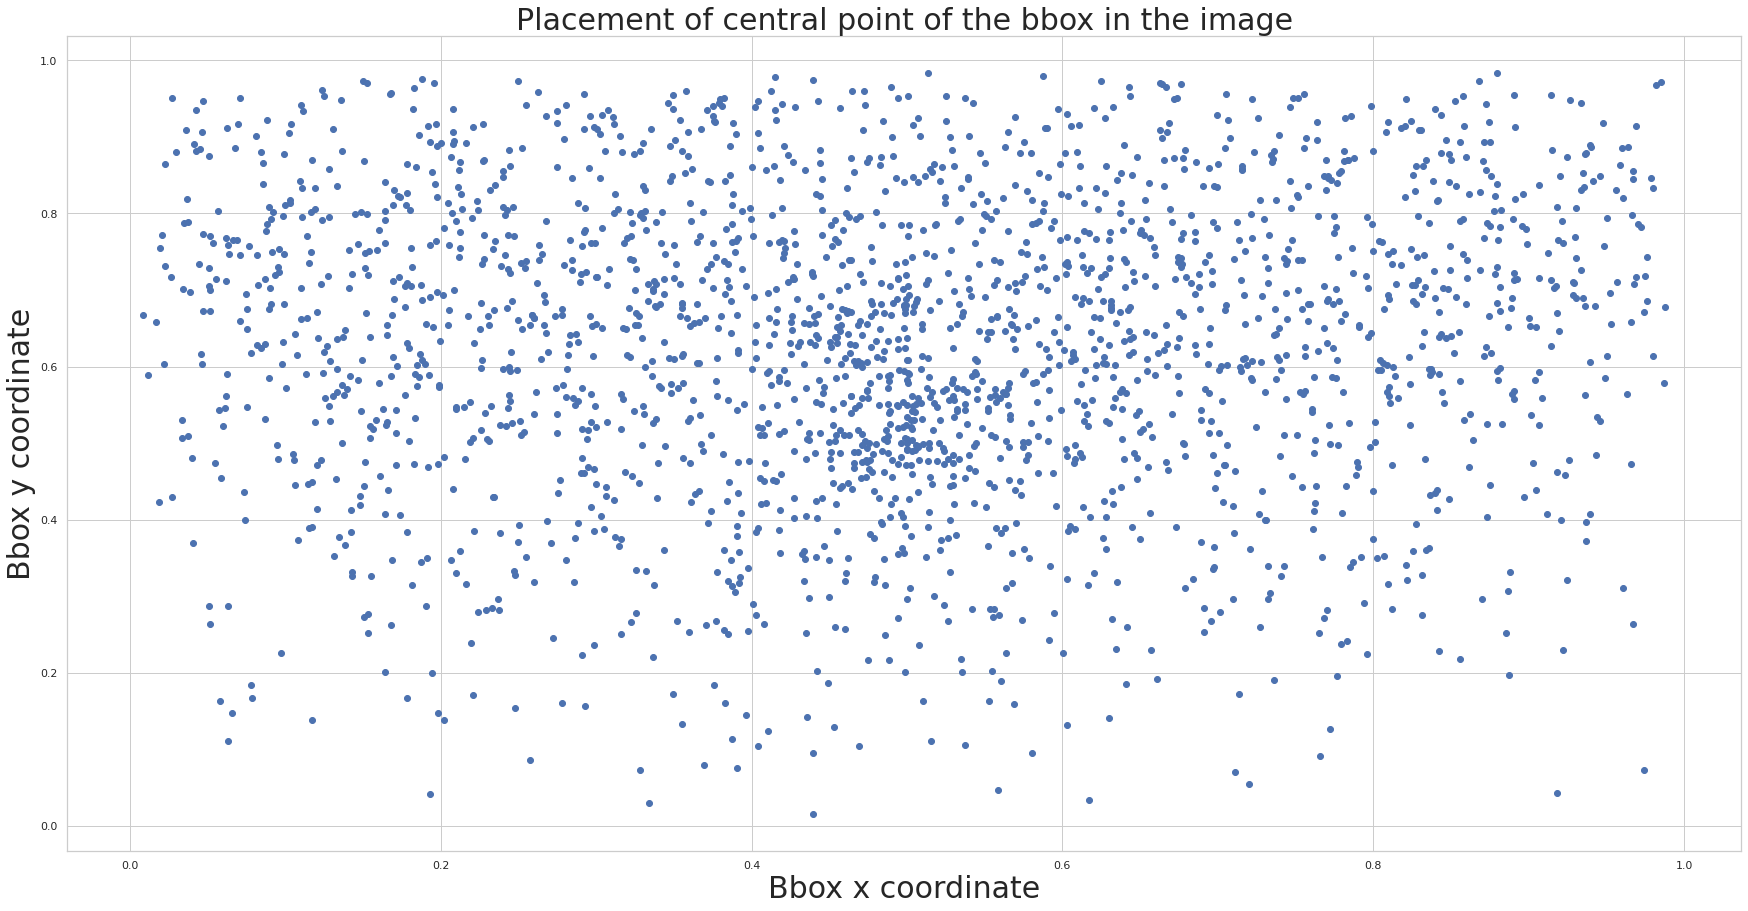

In [91]:
center_x = []
center_y = []
for i in range(0, len(anns_detectwaste)):
    for j in range (0, len(dataset['images'])):
        if dataset['images'][j]['id'] == anns_detectwaste[i]['image_id']:
            
            center_x.append((anns_detectwaste[i]['bbox'][0]+anns_detectwaste[i]['bbox'][2]/2)/dataset['images'][j]['width'])
            center_y.append((anns_detectwaste[i]['bbox'][1]+anns_detectwaste[i]['bbox'][3]/2)/dataset['images'][j]['height'])
plt.figure(figsize=(30,15))
plt.plot(center_x, center_y, 'bo')
plt.title('Placement of central point of the bbox in the image', fontsize=30)
plt.xlabel('Bbox x coordinate', fontsize=30)
plt.ylabel('Bbox y coordinate', fontsize=30)
plt.show()

### Number of annotations per image

/home/zklawikowska/project/env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean number of annotations per image: 1.609598853868195


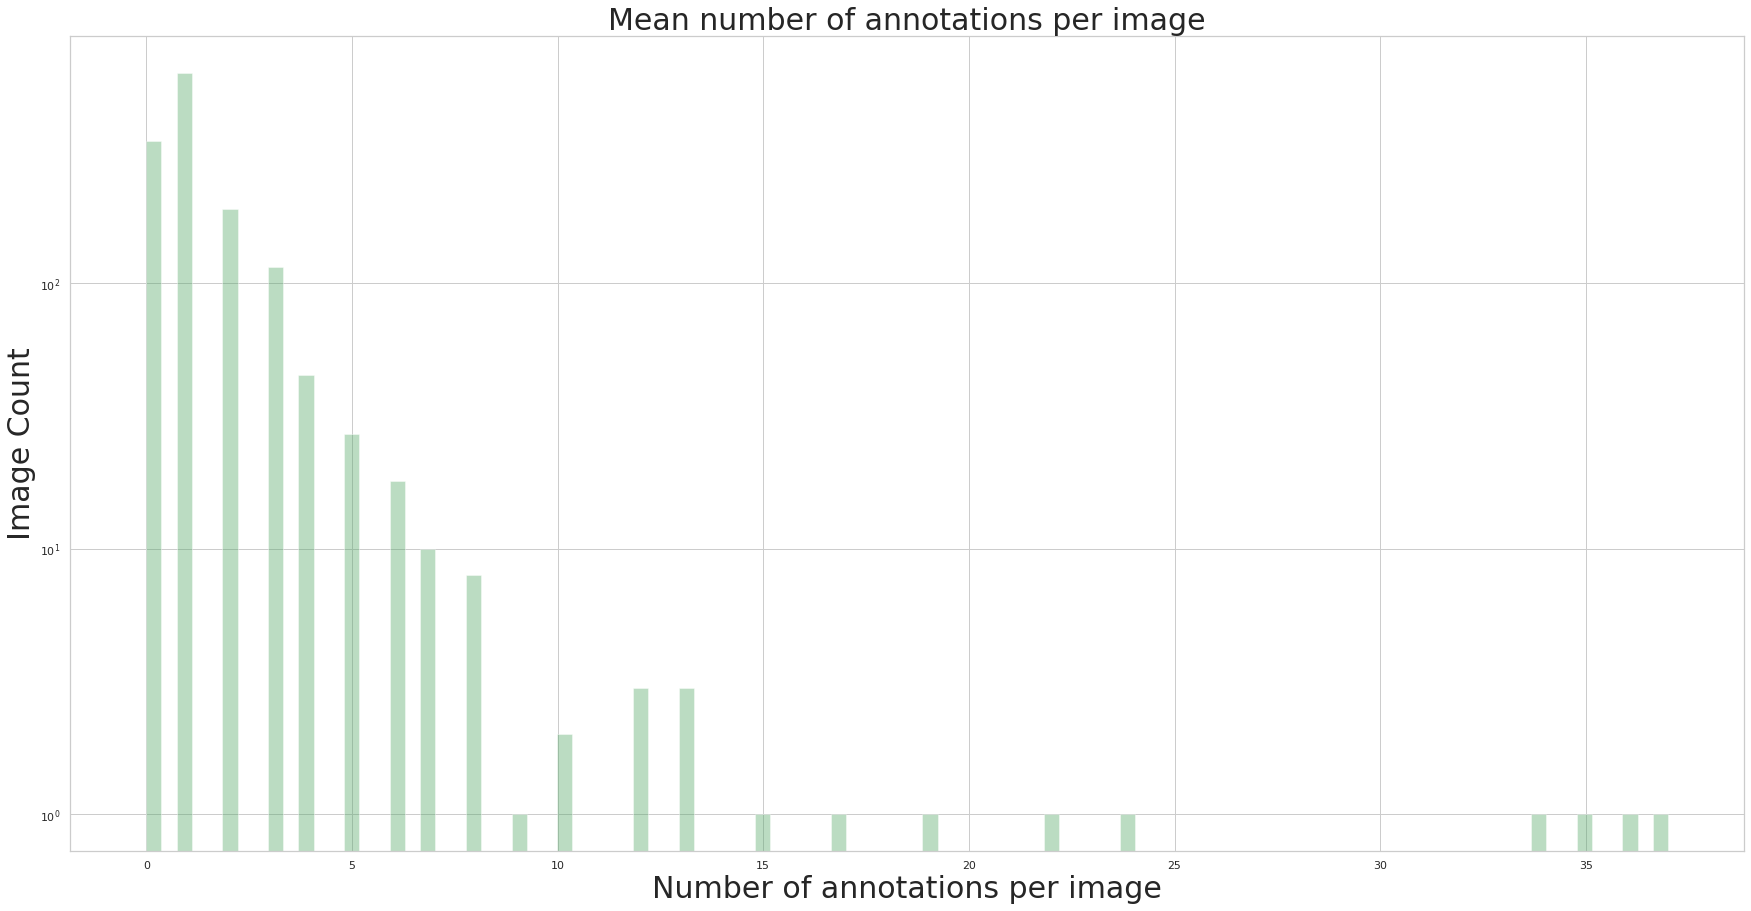

In [92]:
nr_annotation_per_image = []
annotations_per_image = []
for img in dataset['images']:
    annotations_per_image = []
    for i in range(0, len(anns_detectwaste)):
        if img['id'] == anns_detectwaste[i]['image_id']:
            annotations_per_image.append(anns_detectwaste[i]['id'])
    nr_annotation_per_image.append(len(annotations_per_image))

plt.figure(figsize=(30,15))
ax = sns.distplot(nr_annotation_per_image,kde=False,bins=100, color='g')
ax.set_yscale('log')
plt.title('Mean number of annotations per image', fontsize=30)
plt.xlabel('Number of annotations per image', fontsize=30)
plt.ylabel('Image Count', fontsize=30)

print('Mean number of annotations per image:',np.mean(nr_annotation_per_image))

### Bbox size - absolute and relative

According to MS COCO Evaluation. This dataset has:
1020 small objects (area<32*32 px)
1417 medium objects (area<96*96 px)
1636 large objects (area>96*96 px)
Number of bboxes smaller than 1024: 2247
Number of bboxes larger than 1024: 0
Number of missing annotations 433


Text(0.5, 1.0, 'Bounding-boxes size')

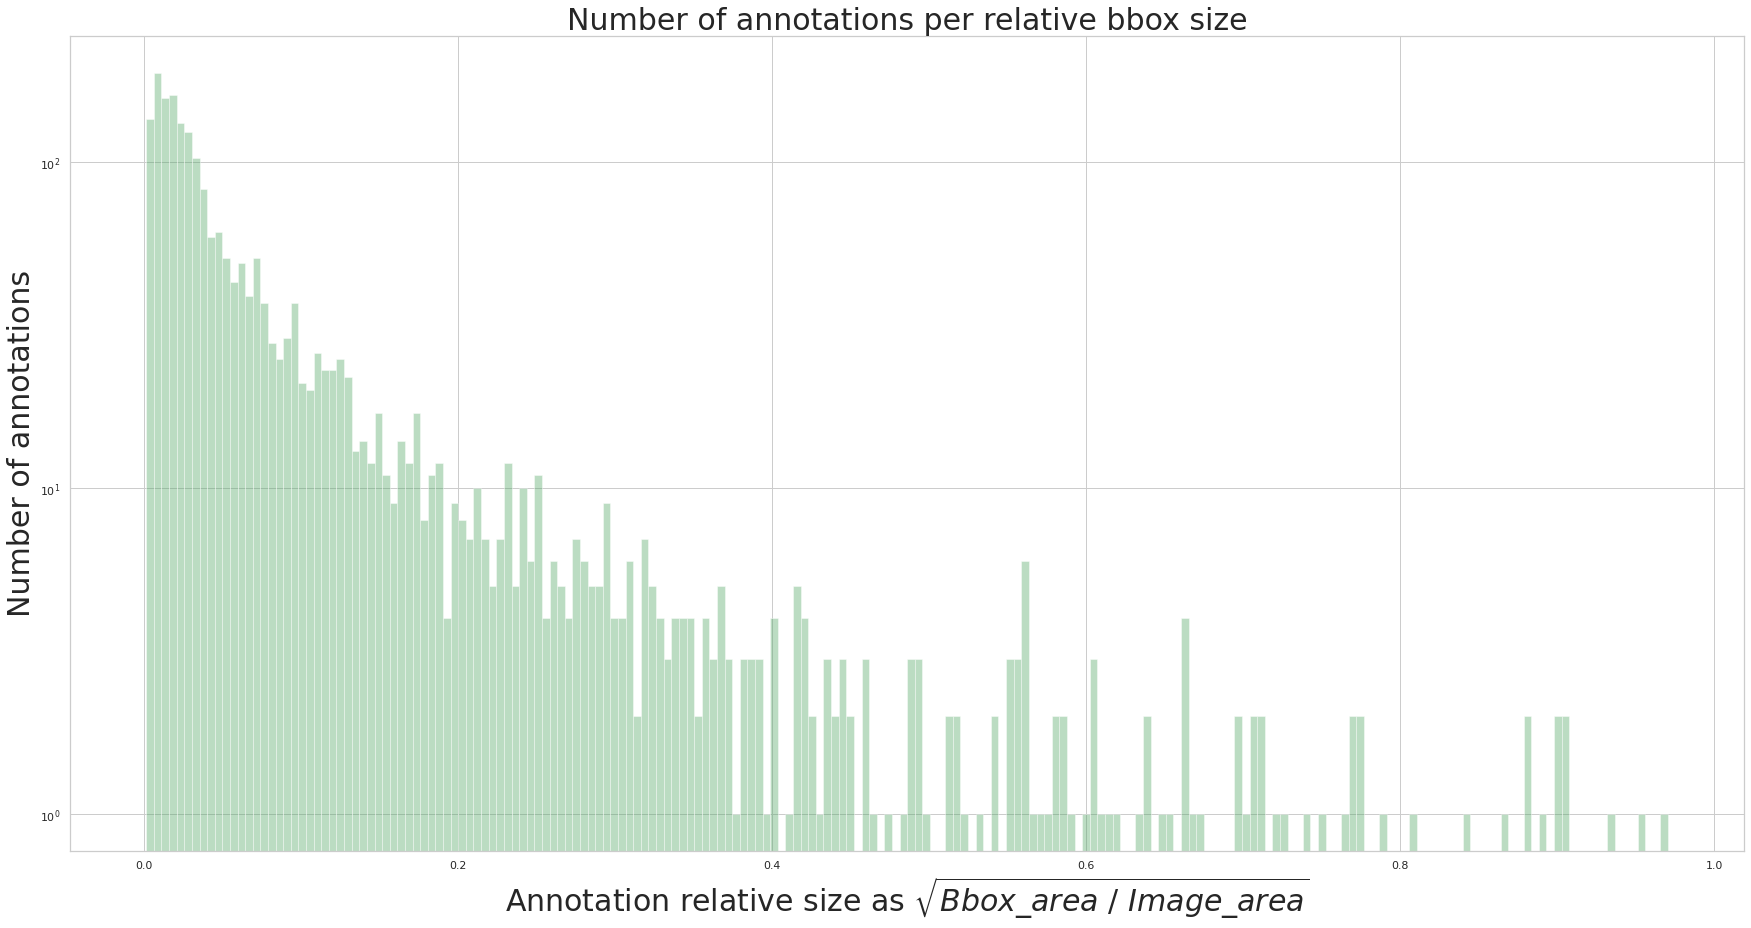

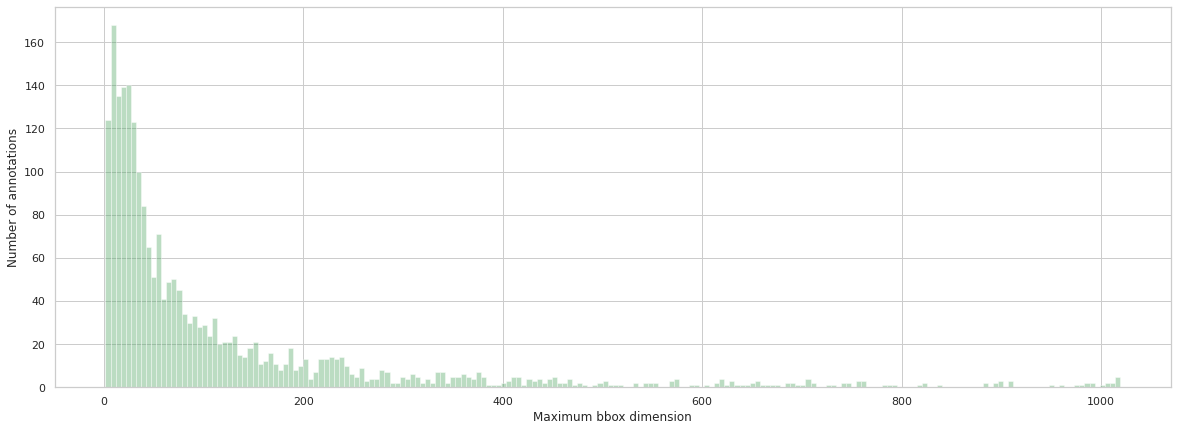

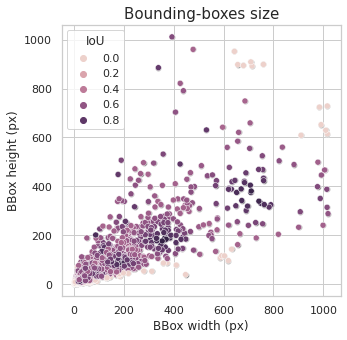

In [93]:
bbox_widths = []
bbox_heights = []
obj_areas_sqrt = []
obj_areas_sqrt_fraction = []
bbox_aspect_ratio = []
max_image_dim = 1024

for ann in anns_detectwaste:
    
    imgs = dataset['images']
    
    resize_scale = max_image_dim/max(imgs[0]['width'], imgs[0]['height'])
    # Uncomment this to work on original image size
#     resize_scale = 1
    
    bbox_widths.append(ann['bbox'][2]*resize_scale)
    bbox_heights.append(ann['bbox'][3]*resize_scale)
    obj_area = ann['bbox'][2]*ann['bbox'][3]*resize_scale**2 # ann['area']
    obj_areas_sqrt.append(np.sqrt(obj_area))
        
    img_area = imgs[0]['width']*imgs[0]['height']*resize_scale**2
    obj_areas_sqrt_fraction.append(np.sqrt(obj_area/img_area))
    

print('According to MS COCO Evaluation. This dataset has:')
print(np.sum(np.array(obj_areas_sqrt)<32), 'small objects (area<32*32 px)')
print(np.sum(np.array(obj_areas_sqrt)<64), 'medium objects (area<96*96 px)')
print(np.sum(np.array(obj_areas_sqrt)<96), 'large objects (area>96*96 px)')
    
# d ={'Bbox width (px)': bbox_widths, 'Bbox height (px)': bbox_heights, 'area': seg_areas}
# df = pd.DataFrame(d)

plt.figure(figsize=(30,15))
ax = sns.distplot(obj_areas_sqrt_fraction,kde=False, bins=200, color='g')
ax.set_yscale('log')
plt.title('Number of annotations per relative bbox size', fontsize=30)
plt.xlabel(r'Annotation relative size as $\sqrt{ Bbox\_area \ /  \ Image\_area}$', fontsize=30)
plt.ylabel('Number of annotations', fontsize=30)

plt.figure(figsize=(20,7))
ax = sns.distplot(np.maximum(np.array(bbox_widths),np.array(bbox_heights)),kde=False, bins=200, color='g')
ax = ax.set(xlabel='Maximum bbox dimension', ylabel='Number of annotations')

import colorsys
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", palette = cmap,data=df)

print('Number of bboxes smaller than 1024:',np.sum(np.array(bbox_widths)<1024))
print('Number of bboxes larger than 1024:',np.sum(np.array(bbox_widths)>1024))

# anchors = [(32,32),(64,64),(128,128),(256,256),(512,512)]
scales, ratios = np.meshgrid(np.array([16,32,64,128,256,512]), np.array([0.5,1,2]))
scales = scales.flatten()
ratios = ratios.flatten()
# Enumerate heights and widths from scales and ratios
anchor_heights = scales / np.sqrt(ratios)
anchor_widths = scales * np.sqrt(ratios)

IoUs = []
for i in range(len(bbox_widths)):
    bbox_area = bbox_widths[i]*bbox_heights[i]
    IoU_max = 0.0
    for j in range(len(anchor_heights)):
        anchor_area = anchor_heights[j]*anchor_widths[j]
        intersection_area = min(anchor_widths[j],bbox_widths[i])*min(anchor_heights[j], bbox_heights[i])
        IoU = intersection_area / (bbox_area + anchor_area - intersection_area)
        if IoU>0.5:
            IoU_max = IoU
    IoUs.append(IoU_max)
    
print('Number of missing annotations', np.sum(np.array(IoUs)==0.0))
  
# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights, 'IoU': IoUs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", hue = 'IoU',data=df)
plt.title('Bounding-boxes size', fontsize=15)